<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirLiquide/AirLiquide_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ai.pa"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   49.28   50.75   49.04   50.75      36.79   900398
2009-01-05   50.97   51.33   50.18   50.93      36.92  1297112
2009-01-06   50.82   51.80   50.75   51.27      37.17   782501
2009-01-07   51.02   51.46   50.14   50.54      36.64  1236360
2009-01-08   50.42   51.15   49.84   50.93      36.92  1148786
...            ...     ...     ...     ...        ...      ...
2018-12-21  106.55  107.90  106.20  107.60     105.19  1937650
2018-12-24  106.80  107.05  106.20  106.80     104.40   208104
2018-12-27  107.50  107.80  104.15  104.85     102.50  1031010
2018-12-28  105.60  106.90  105.40  106.25     103.87   653823
2018-12-31  107.05  108.45  106.90  108.45     106.02   267446

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     87.157735    87.903752    86.419679    87.187473    76.381103  9.943265e+05
std      18.367691    18.402860    18.294407    18.344157    21.169273  4.470137e+05
min      42.290000    42.390000    41.370000    42.080000    30.510000  0.000000e+00
25%      75.210000    75.890000    74.647500    75.257500    60.005000  7.076888e+05
50%      88.550000    89.210000    87.850000    88.550000    76.640000  9.066560e+05
75%     103.392500   103.900000   102.550000   103.200000    96.652500  1.163219e+06
max     120.530000   120.730000   118.830000   120.440000   112.570000  4.401387e+06

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   46.61   47.17   45.68   46.08      33.40  1503690   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   45.462507   44.379546   42.337101   46.101242   45.502670   44.257134      44.980      44.960   42.989629   45.35500   46.532277   45.2320   45.712500   45.35500   46.383333   44.736560               47.823198                 45.35500               42.886802               49.057297                 45.35500               41.652703               50.291395                 45.35500               40.418605               51.525494                 45.35500               39.184506   45.502670   46.121526   44.708683               47.970868                45.502670               43.034472               49.204966                45.502670               41.800373               50.439065                45.502670               40.566274               51.673164   
2009-03-16   45.84   47.45   45.48   47.45      34.39  1297205   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   46.456253   44.898723   42.541217   46.737542   45.935410   44.367076      45.385      44.965   43.345658   45.55125   47.231115   45.6965   46.178056   45.55125   46.765000   44.824720               48.378730                 45.55125               42.723770               49.792470                 45.55125               41.310030               51.206210                 45.55125               39.896290               52.619950                 45.55125               38.482550   45.935410   47.026770   44.825763               48.762890                45.935410               43.107930               50.176630                45.935410               41.694190               51.590370                45.935410               40.280450               53.004110   
2009-03-17   47.00   47.34   45.31   45.74      33.16  1470036

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     87.983180    88.731349    87.248871    88.016261    77.244804  9.810939e+05    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    87.887364    87.652263     2.096841    88.016678    87.930406    87.998398    87.889910    87.812514    87.568423    87.930709    88.016918    87.931003    87.959417    87.930709    87.996927    87.758101               90.112618                87.930709               85.748800               91.203573                87.930709               84.657846               92.294528                87.930709               83.566891               93.385482                87.930709               82.475936    87.930406    87.997910    87.783744               90.112315                87.930406               85.748496               91.203269                87.930406               84.657542               92.294224   
std      17.582357    17.614619    17.495189    17.549121    20.466251  4.362830e+05     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238    17.593099    17.651552    89.539984    17.554417    17.545416    17.641783    17.560573    17.558187    17.776585    17.561989    17.555304    17.570612    17.548870    17.561989    17.538143    17.619731               17.893475                17.561989               17.309123               18.087391                17.561989               17.213297               18.299310                17.561989               17.138358               18.528617                17.561989               17.084578    17.545416    17.538621    17.610403               17.877419                17.545416               17.292091               18.071610                17.545416               17.196062               18.283815   
min      45.760000    46.040000    44.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT        DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2009-03-13  0.011368  0.015129  0.009613  0.011696   0.007895  1503690   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.683502  0.000000e+00  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.006436  0.000000  0.000000  0.000000  0.009022  0.000000                0.004615                 0.000000                0.002186                0.012555                 0.000000                0.004547                0.019946                 0.000000                0.006859                0.026597                 0.000000                0.009123  0.000000  0.004900  0.000000                0.012181                 0.000000                0.000000                0.019601                 0.000000                0.001420                0.026388                 0.000000                0.003785                0.032619                 0.000000   
2009-03-16  0.001070  0.018878  0.006905  0.029904   0.020301  1297205   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.013539  0.007041  0.684357  8.636873e-03  0.005907  0.001488    0.005499    0.000068  0.004580  0.002675  0.015953  0.006307  0.006364  0.002675  0.014214  0.001200                0.011979                 0.002675                0.000000                0.021988                 0.002675                0.000000                0.031288                 0.002675                0.000000                0.039596                 0.002675                0.000000  0.005907  0.017217  0.001591                0.022655                 0.005907                0.000991                0.031878                 0.005907                0.000000                0.040313                 0.005907                0.000000                0.048057                 0.005907   
2009-03-17  0.016584  0.017405  0.00

140235

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_flijma3
  JVM stdout: /tmp/tmp_flijma3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_flijma3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_3jgalu
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190827_130859  0.547428  0.959042              0.472307  0.596152  0.355398
1  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.536924  0.691749              0.461771  0.499301  0.249301
2  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.529093  0.698758              0.500000  0.502730  0.252738
3  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.528966  0.714895              0.500000  0.509662  0.259755
4  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.521772  0.901498              0.500000  0.554774  0.307774
5  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.514388  0.813485              0.500000  0.537052  0.288425
6  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.500000  0.692065              0.500000  0.499459  0.249459
7  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.500000  0.691987              0.500000  0.499419  0.249420
8  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.499554  0.691812              0.500000  0.499332  0.249333
9  DeepLearning_grid_1_AutoML_20190827_130859_mod...  0.465941  2.391019              0.490769  0.666989  0.444875

variable  relative_importance  scaled_importance  percentage
0     BBANDS_lowerband_20_3_5             1.000000           1.000000    0.001538
1                       LOG10             0.985485           0.985485    0.001515
2                          LN             0.972547           0.972547    0.001496
3     BBANDS_lowerband_14_4_4             0.925315           0.925315    0.001423
4         CDLGAPSIDESIDEWHITE             0.923670           0.923670    0.001420
...                       ...                  ...                ...         ...
1037   BBANDS_lowerband_8_7_3             0.326915           0.326915    0.000503
1038  BBANDS_middleband_8_8_5             0.305032           0.305032    0.000469
1039                  TRIX_14             0.304429           0.304429    0.000468
1040              STOCH_slowk             0.301804           0.301804    0.000464
1041                      BOP             0.278764           0.278764    0.000429

[1042 rows x 4 columns]

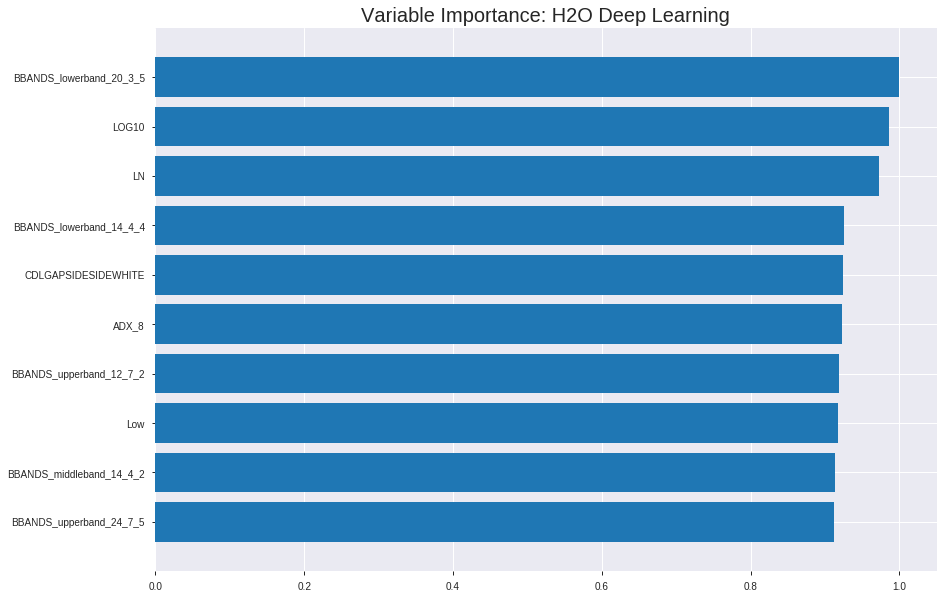

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_130859


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2890411459475678
RMSE: 0.537625469958007
LogLoss: 0.8454081198518121
Mean Per-Class Error: 0.45181963552508697
AUC: 0.558898488571682
pr_auc: 0.5752877762722699
Gini: 0.11779697714336401
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004915244647689245: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    833   0.9952   (833.0/837.0)
1      0    916   0        (0.0/916.0)
Total  4    1749  0.4752   (833.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00491524   0.68743    398
max f2                       0.00491524   0.846111   398
max f0point5                 0.0750831    0.583864   369
max accuracy                 0.248735     0.550485   274
max precision                0.996893     0.833333   2
max recall                   0.00491524   1          398
max specificity              0.999623     0.997611   0
max absolute_mcc             0.564197     0.0973113  127
max min_per_class_accuracy   0.447179     0.545998   175
max mean_per_class_accuracy  0.459344     0.54818    170

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 40.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.993742           1.27584   1.27584            0.666667         0.997698   0.666667                    0.997698            0.0131004       0.0131004                  27.5837   27.5837
    2        0.0205362                   0.971045           1.27584   1.27584            0.666667         0.982857   0.666667                    0.990278            0.0131004       0.0262009                  27.5837   27.5837
    3        0.0302339                   0.920882           1.46346   1.33602            0.764706         0.94852    0.698113                    0.976884            0.0141921       0.040393                   46.346    33.6018
    4        0.040502                    0.860561           0.850558  1.21294            0.444444         0.893132   0.633803                    0.955651            0.00873362      0.0491266                  -14.9442  21.2944
    5        0.0501997                   0.80841            1.68861   1.30483            0.882353         0.835911   0.681818                    0.932519            0.0163755       0.0655022                  68.8608   30.4833
    6        0.100399                    0.675544           1.13086   1.21784            0.590909         0.728302   0.636364                    0.830411            0.0567686       0.122271                   13.0855   21.7844
    7        0.150029                    0.593133           1.16585   1.20065            0.609195         0.629001   0.627376                    0.763785            0.0578603       0.180131                   16.5851   20.0645
    8        0.200228                    0.538925           1.02212   1.15589            0.534091         0.567232   0.603989                    0.714507            0.05131         0.231441                   2.21194   15.5886
    9        0.462065                    0.49536            1.02984   1.08446            0.538126         0.497875   0.566667                    0.591748            0.269651        0.501092                   2.98423   8.44614
    10       0.500285                    0.449922           1.14254   1.0889             0.597015         0.471392   0.568985                    0.582554            0.0436681       0.54476                    14.2541   8.88985
    11       0.600114                    0.386676           0.962346  1.06785            0.502857         0.417528   0.557985                    0.555102            0.0960699       0.64083                    -3.76544  6.78464
    12       0.699943                    0.266177           0.95141   1.05124            0.497143         0.333797   0.549307                    0.523538            0.0949782       0.735808                   -4.85901  5.12398
    13       0.799772                    0.162425           0.885795  1.03059            0.462857         0.215068   0.538516                    0.485035            0.0884279       0.824236                   -11.4205  3.05887
    14       0.899601                    0.0904756          0.907667  1.01695            0.474286         0.119688   0.531389                    0.444492            0.0906114       0.914847                   -9.23331  1.6948
    15       1                           0.00212962         0.848142  1                  0.443182         0.0600699  0.522533                    0.405896            0.0851528       1                          -15.1858  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31289786562818905
RMSE: 0.559372743015057
LogLoss: 0.8454179083746359
Mean Per-Class Error: 0.4604190640583046
AUC: 0.5382783531517709
pr_auc: 0.5518748839258009
Gini: 0.07655670630354172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12032651842384343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    233  0.9831   (233.0/237.0)
1      0    264  0        (0.0/264.0)
Total  4    497  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.120327     0.693824  396
max f2                       0.120327     0.849968  396
max f0point5                 0.177982     0.596076  341
max accuracy                 0.177982     0.558882  341
max precision                0.491347     0.666667  5
max recall                   0.120327     1         396
max specificity              0.870161     0.995781  0
max absolute_mcc             0.177982     0.114     341
max min_per_class_accuracy   0.262353     0.531646  209
max mean_per_class_accuracy  0.177982     0.539581  341

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 28.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.491347           1.26515   1.26515            0.666667         0.597125  0.666667                    0.597125            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.441775           0.759091  1.03512            0.4              0.466975  0.545455                    0.537966            0.00757576      0.0227273                  -24.0909  3.5124
    3        0.0319361                   0.437975           0.759091  0.948864           0.4              0.440128  0.5                         0.507392            0.00757576      0.030303                   -24.0909  -5.11364
    4        0.0419162                   0.432888           1.13864   0.994048           0.6              0.434813  0.52381                     0.490111            0.0113636       0.0416667                  13.8636   -0.595238
    5        0.0518962                   0.43069            1.13864   1.02185            0.6              0.431191  0.538462                    0.47878             0.0113636       0.0530303                  13.8636   2.18531
    6        0.101796                    0.416172           1.21455   1.11631            0.64             0.422001  0.588235                    0.450947            0.0606061       0.113636                   21.4545   11.631
    7        0.151697                    0.401773           0.986818  1.07371            0.52             0.40959   0.565789                    0.437343            0.0492424       0.162879                   -1.31818  7.37141
    8        0.201597                    0.388169           1.29045   1.12736            0.68             0.394211  0.594059                    0.426667            0.0643939       0.227273                   29.0455   12.7363
    9        0.301397                    0.356204           0.986818  1.08082            0.52             0.375756  0.569536                    0.409809            0.0984848       0.325758                   -1.31818  8.08248
    10       0.401198                    0.306611           0.910909  1.03856            0.48             0.331187  0.547264                    0.390251            0.0909091       0.416667                   -8.90909  3.85572
    11       0.500998                    0.263216           1.13864   1.05849            0.6              0.282164  0.557769                    0.36872             0.113636        0.530303                   13.8636   5.84933
    12       0.600798                    0.23561            0.835     1.02137            0.44             0.249712  0.538206                    0.348951            0.0833333       0.613636                   -16.5     2.13682
    13       0.700599                    0.210572           1.06273   1.02726            0.56             0.22143   0.541311                    0.330786            0.106061        0.719697                   6.27273   2.72598
    14       0.800399                    0.191484           1.10068   1.03641            0.58             0.201267  0.546135                    0.314636            0.109848        0.829545                   10.0682   3.64146
    15       0.9002                      0.162901           0.872955  1.01829            0.46             0.17877   0.536585                    0.299573            0.0871212       0.916667                   -12.7045  1.82927
    16       1                           0.0908695          0.835     1                  0.44             0.140845  0.526946                    0.283732        


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:09:01  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:09:05  4.740 sec   1331 obs/sec      1         1             1753       0.537625         0.845408            -0.158517      0.558898        0.575288           1.27584          0.475185                         0.559373           0.845418              -0.255237        0.538278          0.551875             1.26515            0.46507
    2019-08-27 13:09:07  6.790 sec   5597 obs/sec      10        10            17530      0.53893          0.792629            -0.164148      0.611272        0.64676            1.91376          0.462065                         0.572815           0.875085              -0.316291        0.527922          0.543259             0.948864           0.46507
    2019-08-27 13:09:07  7.058 sec   5552 obs/sec      10        10            17530      0.537625         0.845408            -0.158517      0.558898        0.575288           1.27584          0.475185                         0.559373           0.845418              -0.255237        0.538278          0.551875             1.26515            0.46507

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ----------------------
BBANDS_lowerband_20_3_5  1.0                    1.0                  0.0015377889922304007
LOG10                    0.9854851365089417     0.9854851365089417   0.0015154681949301242
LN                       0.9725471138954163     0.9725471138954163   0.001495572246173817
BBANDS_lowerband_14_4_4  0.925314724445343      0.925314724445343    0.0014229387976007549
CDLGAPSIDESIDEWHITE      0.9236695766448975     0.9236695766448975   0.0014204089074226376
---                      ---                    ---                  ---
BBANDS_lowerband_8_7_3   0.32691484689712524    0.32691484689712524  0.000502726052955086
BBANDS_middleband_8_8_5  0.30503150820732117    0.30503150820732117  0.0004690740956046556
TRIX_14                  0.30442914366722107    0.30442914366722107  0.00046814778604557973
STOCH_slowk              0.30180415511131287    0.30180415511131287  0.00046411110753957334
BOP                      0.27876365184783936    0.27876365184783936  0.00042867967524555517


See the whole table with table.as_data_frame()


('accuracy', 0.5657370517928287)

('F1', 0.6904109589041098)

('auc', 0.5474280621339445)

('logloss', 0.9590421669604323)

('mean_per_class_error', 0.4365928189457601)

('rmse', 0.5961522973752162)

('mse', 0.35539756166574826)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


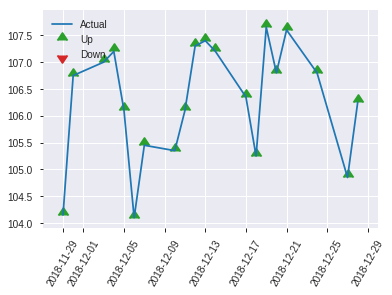


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.35539756166574826
RMSE: 0.5961522973752162
LogLoss: 0.9590421669604323
Mean Per-Class Error: 0.4365928189457601
AUC: 0.5474280621339445
pr_auc: 0.5500301282669635
Gini: 0.09485612426788892
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13929608203861943: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   107  0.8992   (107.0/119.0)
1      6    126  0.0455   (6.0/132.0)
Total  18   233  0.4502   (113.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.139296     0.690411  232
max f2                       0.117468     0.84724   250
max f0point5                 0.1731       0.594363  170
max accuracy                 0.1731       0.565737  170
max precision                0.323505     0.666667  5
max recall                   0.117468     1         250
max specificity              0.337904     0.991597  0
max absolute_mcc             0.20334      0.129566  98
max min_per_class_accuracy   0.191922     0.521008  125
max mean_per_class_accuracy  0.20334      0.563407  98

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 19.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.331534           0.633838  0.633838           0.333333         0.334607  0.333333                    0.334607            0.00757576      0.00757576                 -36.6162  -36.6162
    2        0.0239044                   0.323505           1.90152   1.26768            1                0.32694   0.666667                    0.330774            0.0227273       0.030303                   90.1515   26.7677
    3        0.0318725                   0.312815           0.950758  1.18845            0.5              0.319069  0.625                       0.327847            0.00757576      0.0378788                  -4.92424  18.8447
    4        0.0438247                   0.3033             0.633838  1.03719            0.333333         0.305985  0.545455                    0.321885            0.00757576      0.0454545                  -36.6162  3.71901
    5        0.0517928                   0.292426           0.950758  1.02389            0.5              0.298247  0.538462                    0.318248            0.00757576      0.0530303                  -4.92424  2.38928
    6        0.103586                    0.256681           0.877622  0.950758           0.461538         0.275742  0.5                         0.296995            0.0454545       0.0984848                  -12.2378  -4.92424
    7        0.151394                    0.252053           0.950758  0.950758           0.5              0.254056  0.5                         0.283436            0.0454545       0.143939                   -4.92424  -4.92424
    8        0.203187                    0.23549            1.4627    1.08125            0.769231         0.242939  0.568627                    0.273113            0.0757576       0.219697                   46.2704   8.12537
    9        0.302789                    0.213378           1.14091   1.10088            0.6              0.223906  0.578947                    0.256926            0.113636        0.333333                   14.0909   10.0877
    10       0.40239                     0.202748           1.21697   1.12961            0.64             0.207877  0.594059                    0.244785            0.121212        0.454545                   21.697    12.9613
    11       0.501992                    0.191922           0.684545  1.04131            0.36             0.197233  0.547619                    0.23535             0.0681818       0.522727                   -31.5455  4.13059
    12       0.601594                    0.183515           1.06485   1.0452             0.56             0.186961  0.549669                    0.227339            0.106061        0.628788                   6.48485   4.52037
    13       0.701195                    0.171204           1.06485   1.04799            0.56             0.177057  0.551136                    0.220197            0.106061        0.734848                   6.48485   4.79941
    14       0.800797                    0.156837           0.836667  1.02171            0.44             0.163453  0.537313                    0.213139            0.0833333       0.818182                   -16.3333  2.17096
    15       0.900398                    0.145014           0.988788  1.01807            0.52             0.151014  0.535398                    0.206267            0.0984848       0.916667                   -1.12121  1.80678
    16       1                           0.117468           0.836667  1                  0.44             0.133608  0.525896                    0.19903       

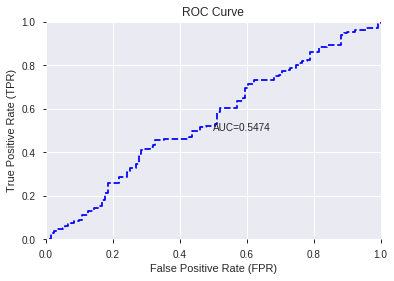

This function is available for GLM models only


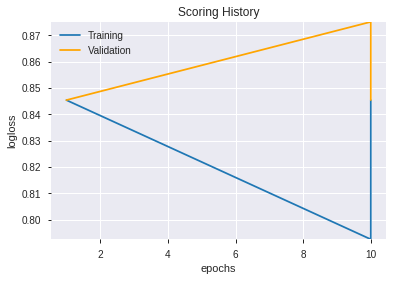

--2019-08-27 13:33:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  43.7MB/s    in 11s     

2019-08-27 13:33:38 (32.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_130859',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_130859',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_b27e',


In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_133346_model_5  0.525847  0.693408              0.464318  0.500130  0.250130
1               DeepLearning_1_AutoML_20190827_133346  0.509995  0.733331              0.487395  0.518897  0.269254
2  DeepLearning_grid_1_AutoML_20190827_133346_model_6  0.500000  0.691905              0.500000  0.499379  0.249379
3  DeepLearning_grid_1_AutoML_20190827_133346_model_8  0.498408  0.691543              0.500000  0.499202  0.249203
4  DeepLearning_grid_1_AutoML_20190827_133346_model_3  0.488095  0.725890              0.487395  0.513781  0.263970
5  DeepLearning_grid_1_AutoML_20190827_133346_model_2  0.479565  0.746916              0.495798  0.521666  0.272136
6  DeepLearning_grid_1_AutoML_20190827_133346_model_7  0.465686  0.694351              0.500000  0.500602  0.250602
7  DeepLearning_grid_1_AutoML_20190827_133346_model_1  0.459638  0.788750              0.495798  0.538292  0.289759
8  DeepLearning_grid_1_AutoML_20190827_133346_model_4  0.458365  0.700435              0.491183  0.503602  0.253615

variable  relative_importance  scaled_importance  percentage
0                    ROCR_24             1.000000           1.000000    0.029929
1             CDLHARAMICROSS             0.901324           0.901324    0.026975
2                MINUS_DM_12             0.867677           0.867677    0.025968
3                     ADXR_8             0.857133           0.857133    0.025653
4                  MACD_hist             0.822658           0.822658    0.024621
5                      DX_12             0.809541           0.809541    0.024229
6                      ADX_8             0.804412           0.804412    0.024075
7                    NATR_24             0.764094           0.764094    0.022868
8    BBANDS_lowerband_14_4_4             0.690811           0.690811    0.020675
9    BBANDS_upperband_12_7_2             0.677406           0.677406    0.020274
10   BBANDS_upperband_30_2_5             0.673208           0.673208    0.020148
11  BBANDS_middleband_14_4_2             0.669501           0.669501    0.020037
12   BBANDS_upperband_30_1_3             0.660643           0.660643    0.019772
13                 MAVP_20_3             0.659843           0.659843    0.019748
14   BBANDS_upperband_12_7_5             0.652711           0.652711    0.019535
15   BBANDS_middleband_8_2_4             0.652336           0.652336    0.019524
16   BBANDS_upperband_24_7_5             0.649659           0.649659    0.019443
17                   MA_24_6             0.648394           0.648394    0.019406
18                     LOG10             0.646756           0.646756    0.019357
19   BBANDS_lowerband_20_3_5             0.646276           0.646276    0.019342
20   BBANDS_lowerband_24_6_2             0.645166           0.645166    0.019309
21   BBANDS_upperband_30_5_5             0.644448           0.644448    0.019287
22  BBANDS_middleband_24_5_5             0.644265           0.644265    0.019282
23    BBANDS_upperband_8_8_3             0.643131           0.643131    0.019248
24    BBANDS_lowerband_8_4_5             0.639788           0.639788    0.019148
25                 MAVP_24_5             0.638948           0.638948    0.019123
26    BBANDS_lowerband_8_1_2             0.638705           0.638705    0.019116
27                        LN             0.637312           0.637312    0.019074
28                 MAVP_24_0             0.636627           0.636627    0.019053
29  BBANDS_middleband_12_7_3             0.631943           0.631943    0.018913
30    BBANDS_upperband_8_3_5             0.631268           0.631268    0.018893
31                       Low             0.630405           0.630405    0.018867
32                  TYPPRICE             0.628517           0.628517    0.018811
33                  MEDPRICE             0.626535           0.626535    0.018751
34                  TRIMA_20             0.623619           0.623619    0.018664
35  BBANDS_middleband_20_0_3             0.620884           0.620884    0.018582
36                   DEMA_12             0.619829           0.619829    0.018551
37                 CDLINNECK             0.619623           0.619623    0.018545
38   BBANDS_upperband_24_3_2             0.618689           0.618689    0.018517
39  BBANDS_middleband_14_5_5             0.617726           0.617726    0.018488
40   BBANDS_upperband_20_6_2             0.614680           0.614680    0.018397
41   BBANDS_lowerband_20_0_4             0.614422           0.614422    0.018389
42                      Open             0.613290           0.613290    0.018355
43                   KAMA_30             0.611458           0.611458    0.018300
44    BBANDS_lowerband_8_5_3             0.609500           0.609500    0.018242
45                 MAVP_12_0             0.602542           0.602542    0.018033
46   BBANDS_lowerband_30_2_3             0.600253           0.600253    0.017965
47  BBANDS_middleband_14_7_2             0.598935           0.598935    0.017925
48    BBANDS_upperband_8_7_5             0.596514  

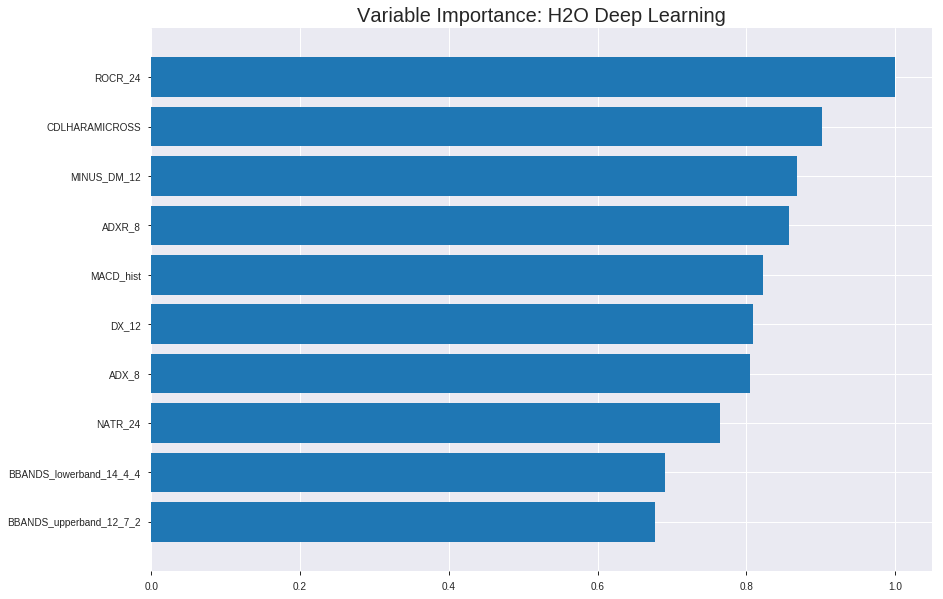

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_133346_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2459343126925303
RMSE: 0.49591764708722585
LogLoss: 0.6846159298217069
Mean Per-Class Error: 0.46140431881381305
AUC: 0.5568663818065143
pr_auc: 0.5814599242194837
Gini: 0.11373276361302853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4678520956614579: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      39   798   0.9534   (798.0/837.0)
1      11   905   0.012    (11.0/916.0)
Total  50   1703  0.4615   (809.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467852     0.691103  357
max f2                       0.291121     0.845955  396
max f0point5                 0.483726     0.587717  333
max accuracy                 0.514487     0.549914  268
max precision                0.943658     1         0
max recall                   0.291121     1         396
max specificity              0.943658     1         0
max absolute_mcc             0.467852     0.103782  357
max min_per_class_accuracy   0.53866      0.530466  192
max mean_per_class_accuracy  0.552353     0.538596  145

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 53.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.694489           1.5948    1.5948             0.833333         0.784314  0.833333                    0.784314            0.0163755       0.0163755                  59.4796   59.4796
    2        0.0205362                   0.651843           1.27584   1.43532            0.666667         0.67263   0.75                        0.728472            0.0131004       0.029476                   27.5837   43.5317
    3        0.0302339                   0.61418            1.23831   1.37213            0.647059         0.627321  0.716981                    0.696028            0.0120087       0.0414847                  23.8312   37.2127
    4        0.040502                    0.597678           1.48848   1.40162            0.777778         0.605445  0.732394                    0.673063            0.0152838       0.0567686                  48.8476   40.1624
    5        0.0501997                   0.584874           1.01316   1.32658            0.529412         0.591404  0.693182                    0.657288            0.00982533      0.0665939                  1.31647   32.658
    6        0.100399                    0.561944           1.10911   1.21784            0.579545         0.570006  0.636364                    0.613647            0.0556769       0.122271                   10.9108   21.7844
    7        0.150029                    0.557584           1.09986   1.17882            0.574713         0.559666  0.61597                     0.59579             0.0545852       0.176856                   9.98595   17.8815
    8        0.200228                    0.555338           0.956878  1.12317            0.5              0.556429  0.586895                    0.585922            0.0480349       0.224891                   -4.31223  12.3173
    9        0.300057                    0.552159           1.09357   1.11333            0.571429         0.55367   0.581749                    0.575192            0.10917         0.334061                   9.35745   11.3325
    10       0.399886                    0.548539           0.95141   1.0729             0.497143         0.550527  0.560628                    0.569034            0.0949782       0.429039                   -4.85901  7.29043
    11       0.500285                    0.538604           0.989499  1.05617            0.517045         0.544211  0.551881                    0.564053            0.099345        0.528384                   -1.05014  5.61661
    12       0.600114                    0.528778           1.0389    1.05329            0.542857         0.533815  0.55038                     0.559023            0.103712        0.632096                   3.88958   5.32932
    13       0.699943                    0.520631           1.02796   1.04968            0.537143         0.525473  0.548492                    0.554238            0.10262         0.734716                   2.79601   4.96801
    14       0.799772                    0.509407           0.973281  1.04014            0.508571         0.515679  0.543509                    0.549425            0.0971616       0.831878                   -2.67187  4.01438
    15       0.899601                    0.48555            0.940474  1.02908            0.491429         0.497669  0.53773                     0.543681            0.0938865       0.925764                   -5.95259  2.90835
    16       1                           0.271786           0.739406  1                  0.386364         0.461081  0.522533                    0.535388          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2490631635685116
RMSE: 0.4990622842576982
LogLoss: 0.6913463587014925
Mean Per-Class Error: 0.45739835059455314
AUC: 0.5560350338831351
pr_auc: 0.5881585687346329
Gini: 0.11207006776627026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4897054936106497: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   216  0.9114   (216.0/237.0)
1      7    257  0.0265   (7.0/264.0)
Total  28   473  0.4451   (223.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489705     0.697422  375
max f2                       0.486809     0.849421  396
max f0point5                 0.492991     0.597826  348
max accuracy                 0.492991     0.560878  348
max precision                0.780838     1         0
max recall                   0.486809     1         396
max specificity              0.780838     1         0
max absolute_mcc             0.52796      0.17509   21
max min_per_class_accuracy   0.5036       0.523207  203
max mean_per_class_accuracy  0.523533     0.542602  59

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.531497           1.26515   1.26515            0.666667         0.64439   0.666667                    0.64439             0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.52999            1.89773   1.55269            1                0.530569  0.818182                    0.592654            0.0189394       0.0340909                  89.7727   55.2686
    3        0.0319361                   0.529155           1.89773   1.66051            1                0.529303  0.875                       0.572856            0.0189394       0.0530303                  89.7727   66.0511
    4        0.0419162                   0.528262           1.89773   1.71699            1                0.528411  0.904762                    0.562274            0.0189394       0.0719697                  89.7727   71.6991
    5        0.0518962                   0.527945           1.51818   1.67876            0.8              0.527993  0.884615                    0.555682            0.0151515       0.0871212                  51.8182   67.8759
    6        0.101796                    0.524832           0.683182  1.19073            0.36             0.526092  0.627451                    0.541177            0.0340909       0.121212                   -31.6818  19.0731
    7        0.151697                    0.523078           1.29045   1.22353            0.68             0.523942  0.644737                    0.535507            0.0643939       0.185606                   29.0455   22.3535
    8        0.201597                    0.521467           0.835     1.12736            0.44             0.522172  0.594059                    0.532206            0.0416667       0.227273                   -16.5     12.7363
    9        0.301397                    0.51892            1.02477   1.09339            0.54             0.520281  0.576159                    0.528258            0.102273        0.329545                   2.47727   9.33925
    10       0.401198                    0.516078           0.986818  1.06688            0.52             0.517611  0.562189                    0.525609            0.0984848       0.42803                    -1.31818  6.68815
    11       0.500998                    0.503818           0.948864  1.04337            0.5              0.510592  0.549801                    0.522618            0.094697        0.522727                   -5.11364  4.3372
    12       0.600798                    0.500535           1.13864   1.0592             0.6              0.502173  0.55814                     0.519221            0.113636        0.636364                   13.8636   5.91966
    13       0.700599                    0.497765           0.948864  1.04348            0.5              0.49907   0.549858                    0.516351            0.094697        0.731061                   -5.11364  4.34797
    14       0.800399                    0.495209           1.02477   1.04115            0.54             0.496359  0.548628                    0.513858            0.102273        0.833333                   2.47727   4.11471
    15       0.9002                      0.49194            0.948864  1.03092            0.5              0.493975  0.543237                    0.511654            0.094697        0.92803                    -5.11364  3.09161
    16       1                           0.486079           0.721136  1                  0.38             0.489323  0.526946                    0.509425          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:37:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:37:24  1 min 26.882 sec  1286 obs/sec      0.862521  1             1512       0.506506         0.706964            -0.0282834     0.538642        0.566485           1.38216          0.475756                         0.515904           0.727532              -0.0677296       0.515407          0.538566             0.948864           0.473054
    2019-08-27 13:37:29  1 min 32.373 sec  2738 obs/sec      9.56931   11            16775      0.501071         0.695315            -0.00633104    0.54066         0.569701           1.48848          0.463206                         0.501863           0.696965              -0.0103999       0.496228          0.52599              0.948864           0.463074
    2019-08-27 13:37:35  1 min 38.091 sec  3237 obs/sec      20.854    24            36557      0.495918         0.684616            0.0142608      0.556866        0.58146            1.5948           0.461495                         0.499062           0.691346              0.00084543       0.556035          0.588159             1.26515            0.44511
    2019-08-27 13:37:41  1 min 43.863 sec  3601 obs/sec      33.8608   39            59358      0.494896         0.682294            0.0183163      0.555874        0.591299           1.5948           0.459783                         0.499302           0.691753              -0.000116367     0.515743          0.560858             1.01819            0.473054
    2019-08-27 13:37:47  1 min 49.855 sec  3882 obs/sec      48.6195   56            85230      0.493477         0.678457            0.0239377      0.55571         0.601696           1.80744          0.457501                         0.49927            0.691687              1.45297e-05      0.503324          0.593824             1.26515            0.473054
    2019-08-27 13:37:52  1 min 55.275 sec  4082 obs/sec      62.4889   72            109543     0.493422         0.678114            0.0241578      0.551277        0.595399           1.91376          0.45579                          0.499592           0.692334              -0.001275        0.499568          0.560126             0.998205           0.473054
    2019-08-27 13:37:53  1 min 55.823 sec  4079 obs/sec      62.4889   72            109543     0.495918         0.684616            0.0142608      0.556866        0.58146            1.5948           0.461495                         0.499062           0.691346              0.00084543       0.556035          0.588159             1.26515            0.44511

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
ROCR_24                   1.0                    1.0                  0.029928727500318053
CDLHARAMICROSS            0.9013238549232483     0.9013238549232483   0.0269754760435341
MINUS_DM_12               0.8676771521568298     0.8676771521568298   0.025968473045153765
ADXR_8                    0.8571332693099976     0.8571332693099976   0.025652908048635646
MACD_hist                 0.8226582407951355     0.8226582407951355   0.024621114314648643
---                       ---                    ---                  ---
MAVP_12_0                 0.6025415062904358     0.6025415062904358   0.01803330054939763
BBANDS_lowerband_30_2_3   0.6002525687217712     0.6002525687217712   0.01796479556063983
BBANDS_middleband_14_7_2  0.598934531211853      0.598934531211853    0.017925348375170288
BBANDS_upperband_8_7_5    0.5965136289596558     0.5965136289596558   0.01785289385135937
CDLGAPSIDESIDEWHITE       0.5593104958534241     0.5593104958534241   0.0167394514184649


See the whole table with table.as_data_frame()


('accuracy', 0.5816733067729084)

('F1', 0.6958904109589042)

('auc', 0.5258467023172906)

('logloss', 0.6934078070574247)

('mean_per_class_error', 0.43124522536287246)

('rmse', 0.5001303121151613)

('mse', 0.25013032909640875)

deeplearning prediction progress: |███████████████████████████████████████| 100%


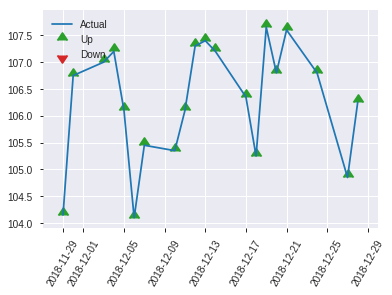


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25013032909640875
RMSE: 0.5001303121151613
LogLoss: 0.6934078070574247
Mean Per-Class Error: 0.43124522536287246
AUC: 0.5258467023172906
pr_auc: 0.5190162944771959
Gini: 0.051693404634581164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49061133356745984: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   106  0.8908   (106.0/119.0)
1      5    127  0.0379   (5.0/132.0)
Total  18   233  0.4422   (111.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.490611     0.69589   232
max f2                       0.48674      0.84724   250
max f0point5                 0.492417     0.608553  194
max accuracy                 0.492548     0.581673  188
max precision                0.492548     0.571429  188
max recall                   0.48674      1         250
max specificity              0.512724     0.991597  0
max absolute_mcc             0.492417     0.161946  194
max min_per_class_accuracy   0.495467     0.504202  125
max mean_per_class_accuracy  0.492548     0.568755  188

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 49.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.508915           0.633838  0.633838           0.333333         0.510497  0.333333                    0.510497            0.00757576      0.00757576                 -36.6162  -36.6162
    2        0.0239044                   0.50851            0.633838  0.633838           0.333333         0.508662  0.333333                    0.50958             0.00757576      0.0151515                  -36.6162  -36.6162
    3        0.0318725                   0.507647           0.950758  0.713068           0.5              0.50818   0.375                       0.50923             0.00757576      0.0227273                  -4.92424  -28.6932
    4        0.0438247                   0.507081           0.633838  0.69146            0.333333         0.507208  0.363636                    0.508678            0.00757576      0.030303                   -36.6162  -30.854
    5        0.0517928                   0.506812           0         0.585082           0                0.50694   0.307692                    0.508411            0               0.030303                   -100      -41.4918
    6        0.103586                    0.505667           1.31643   0.950758           0.692308         0.506076  0.5                         0.507243            0.0681818       0.0984848                  31.6434   -4.92424
    7        0.151394                    0.504427           0.950758  0.950758           0.5              0.504928  0.5                         0.506512            0.0454545       0.143939                   -4.92424  -4.92424
    8        0.203187                    0.502554           0.877622  0.932115           0.461538         0.503505  0.490196                    0.505746            0.0454545       0.189394                   -12.2378  -6.78847
    9        0.302789                    0.498754           1.21697   1.02582            0.64             0.500329  0.539474                    0.503964            0.121212        0.310606                   21.697    2.58174
    10       0.40239                     0.497212           0.912727  0.997825           0.48             0.497846  0.524752                    0.502449            0.0909091       0.401515                   -8.72727  -0.217522
    11       0.501992                    0.495467           1.06485   1.01112            0.56             0.496195  0.531746                    0.501208            0.106061        0.507576                   6.48485   1.11231
    12       0.601594                    0.494403           1.14091   1.03261            0.6              0.494884  0.543046                    0.500161            0.113636        0.621212                   14.0909   3.26109
    13       0.701195                    0.492925           1.29303   1.0696             0.68             0.4936    0.5625                      0.499229            0.128788        0.75                       29.303    6.96023
    14       0.800797                    0.492274           0.988788  1.05955            0.52             0.492545  0.557214                    0.498398            0.0984848       0.848485                   -1.12121  5.95507
    15       0.900398                    0.491201           0.836667  1.0349             0.44             0.49173   0.544248                    0.49766             0.0833333       0.931818                   -16.3333  3.48954
    16       1                           0.48674            0.684545  1                  0.36             0.489523  0.525896                    0.49685 

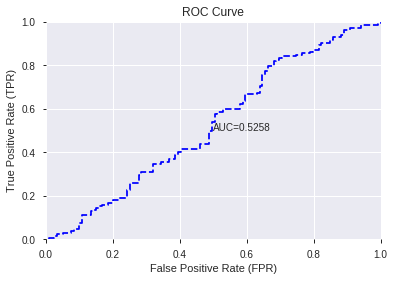

This function is available for GLM models only


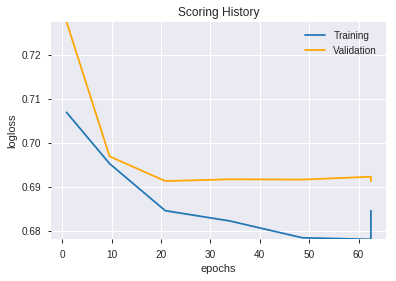

--2019-08-27 13:40:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_133346_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_133346_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['ROCR_24',
 'CDLHARAMICROSS',
 'MINUS_DM_12',
 'ADXR_8',
 'MACD_hist',
 'DX_12',
 'ADX_8',
 'NATR_24',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_12_7_2',
 'BBANDS_upperband_30_2_5',
 'BBANDS_middleband_14_4_2',
 'BBANDS_upperband_30_1_3',
 'MAVP_20_3',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_8_2_4',
 'BBANDS_upperband_24_7_5',
 'MA_24_6',
 'LOG10',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_lowerband_24_6_2',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_24_5_5',
 'BBANDS_upperband_8_8_3',
 'BBANDS_lowerband_8_4_5',
 'MAVP_24_5',
 'BBANDS_lowerband_8_1_2',
 'LN',
 'MAVP_24_0',
 'BBANDS_middleband_12_7_3',
 'BBANDS_upperband_8_3_5',
 'Low',
 'TYPPRICE',
 'MEDPRICE',
 'TRIMA_20',
 'BBANDS_middleband_20_0_3',
 'DEMA_12',
 'CDLINNECK',
 'BBANDS_upperband_24_3_2',
 'BBANDS_middleband_14_5_5',
 'BBANDS_upperband_20_6_2',
 'BBANDS_lowerband_20_0_4',
 'Open',
 'KAMA_30',
 'BBANDS_lowerband_8_5_3',
 'MAVP_12_0',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_middleband_14_7_2',
 'BBANDS_upperba

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_134057_model_1  0.487586  0.698306              0.495385  0.502546  0.252553

variable  relative_importance  scaled_importance  percentage
0             CDLHARAMICROSS             0.057101           1.000000    0.135526
1        CDLGAPSIDESIDEWHITE             0.049256           0.862609    0.116906
2                    ROCR_24             0.035406           0.620055    0.084034
3                      DX_12             0.033079           0.579301    0.078511
4                         LN             0.017970           0.314702    0.042650
5                      LOG10             0.017800           0.311721    0.042246
6    BBANDS_lowerband_20_3_5             0.017218           0.301530    0.040865
7                    NATR_24             0.016687           0.292230    0.039605
8    BBANDS_lowerband_20_0_4             0.015318           0.268255    0.036356
9     BBANDS_lowerband_8_4_5             0.010442           0.182875    0.024784
10                 MACD_hist             0.009800           0.171627    0.023260
11                 CDLINNECK             0.009242           0.161860    0.021936
12   BBANDS_upperband_24_7_5             0.008838           0.154779    0.020977
13   BBANDS_lowerband_14_4_4             0.008662           0.151690    0.020558
14    BBANDS_upperband_8_3_5             0.008640           0.151305    0.020506
15   BBANDS_upperband_20_6_2             0.008128           0.142346    0.019292
16                    ADXR_8             0.007806           0.136697    0.018526
17    BBANDS_upperband_8_7_5             0.007627           0.133573    0.018103
18    BBANDS_upperband_8_8_3             0.006888           0.120624    0.016348
19                 MAVP_20_3             0.006765           0.118481    0.016057
20   BBANDS_lowerband_30_2_3             0.006339           0.111008    0.015045
21                  TYPPRICE             0.005892           0.103194    0.013985
22                      Open             0.005883           0.103031    0.013963
23               MINUS_DM_12             0.005288           0.092600    0.012550
24                   MA_24_6             0.004145           0.072599    0.009839
25    BBANDS_lowerband_8_1_2             0.003682           0.064483    0.008739
26    BBANDS_lowerband_8_5_3             0.003645           0.063838    0.008652
27                  MEDPRICE             0.003598           0.063013    0.008540
28   BBANDS_upperband_12_7_5             0.003334           0.058396    0.007914
29                   KAMA_30             0.003037           0.053193    0.007209
30  BBANDS_middleband_20_0_3             0.002729           0.047792    0.006477
31   BBANDS_upperband_24_3_2             0.002635           0.046150    0.006255
32  BBANDS_middleband_14_7_2             0.002198           0.038493    0.005217
33                       Low             0.001687           0.029540    0.004003
34  BBANDS_middleband_24_5_5             0.001652           0.028938    0.003922
35  BBANDS_middleband_12_7_3             0.001644           0.028795    0.003902
36  BBANDS_middleband_14_5_5             0.001502           0.026305    0.003565
37                 MAVP_24_0             0.001282           0.022458    0.003044
38                  TRIMA_20             0.001279           0.022399    0.003036
39   BBANDS_upperband_30_2_5             0.001101           0.019274    0.002612
40   BBANDS_middleband_8_2_4             0.000973           0.017047    0.002310
41                 MAVP_12_0             0.000960           0.016815    0.002279
42   BBANDS_upperband_30_1_3             0.000942           0.016497    0.002236
43   BBANDS_upperband_30_5_5             0.000868           0.015194    0.002059
44   BBANDS_upperband_12_7_2             0.000688           0.012040    0.001632
45                     ADX_8             0.000561           0.009820    0.001331
46                   DEMA_12             0.000451           0.007900    0.001071
47   BBANDS_lowerband_24_6_2             0.000362           0.006346    0.000860
48                 MAVP_24_5             0.000291  

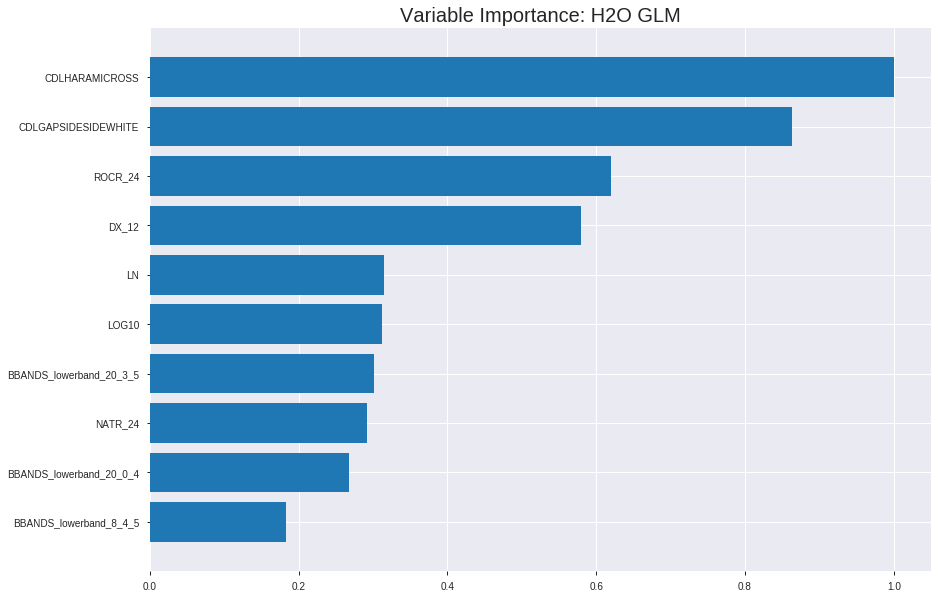

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_134057_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24788534912253066
RMSE: 0.49788085836124557
LogLoss: 0.6888587956678192
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2426.6126264514623
Residual deviance: 2415.138937611374
AIC: 2517.138937611374
AUC: 0.5434183479154602
pr_auc: 0.57158442490716
Gini: 0.08683669583092035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35848406313849845: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    836   0.9988   (836.0/837.0)
1      0    916   0        (0.0/916.0)
Total  1    1752  0.4769   (836.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.358484     0.686657   398
max f2                       0.358484     0.845643   398
max f0point5                 0.473448     0.581773   359
max accuracy                 0.512443     0.542499   247
max precision                0.752576     1          0
max recall                   0.358484     1          398
max specificity              0.752576     1          0
max absolute_mcc             0.551574     0.0879874  89
max min_per_class_accuracy   0.521425     0.520742   206
max mean_per_class_accuracy  0.527811     0.536245   179

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.610309           1.70112   1.70112            0.888889         0.661141  0.888889                    0.661141            0.0174672       0.0174672                  70.1116    70.1116
    2        0.0205362                   0.580509           0.956878  1.329              0.5              0.588947  0.694444                    0.625044            0.00982533      0.0272926                  -4.31223   32.8997
    3        0.0302339                   0.576564           1.35089   1.33602            0.705882         0.57906   0.698113                    0.610295            0.0131004       0.040393                   35.0886    33.6018
    4        0.040502                    0.571295           1.38216   1.34772            0.722222         0.573805  0.704225                    0.601044            0.0141921       0.0545852                  38.2157    34.7715
    5        0.0501997                   0.568319           0.900591  1.26134            0.470588         0.569721  0.659091                    0.594993            0.00873362      0.0633188                  -9.94092   26.1339
    6        0.100399                    0.554326           1.17435   1.21784            0.613636         0.560123  0.636364                    0.577558            0.058952        0.122271                   17.435     21.7844
    7        0.150029                    0.546736           1.05587   1.16426            0.551724         0.550194  0.608365                    0.568506            0.0524017       0.174672                   5.58651    16.4262
    8        0.200228                    0.541463           1.06561   1.13953            0.556818         0.543841  0.595442                    0.562322            0.0534934       0.228166                   6.56138    13.953
    9        0.300057                    0.533679           0.973281  1.08422            0.508571         0.537417  0.56654                     0.554036            0.0971616       0.325328                   -2.67187   8.42189
    10       0.399886                    0.527603           1.09357   1.08655            0.571429         0.530954  0.56776                     0.548274            0.10917         0.434498                   9.35745    8.65545
    11       0.500285                    0.521204           0.869889  1.04307            0.454545         0.524243  0.54504                     0.543451            0.0873362       0.521834                   -13.0111   4.30731
    12       0.600114                    0.515534           1.09357   1.05147            0.571429         0.518239  0.54943                     0.539257            0.10917         0.631004                   9.35745    5.1474
    13       0.699943                    0.510623           0.918603  1.03252            0.48             0.513208  0.539527                    0.535542            0.0917031       0.722707                   -8.13974   3.25233
    14       0.799772                    0.503596           0.984217  1.02649            0.514286         0.507088  0.536377                    0.53199             0.0982533       0.820961                   -1.57829   2.64937
    15       0.899601                    0.490681           0.787374  0.999958           0.411429         0.498676  0.522511                    0.528293            0.0786026       0.899563                   -21.2626   -0.00415359
    16       1                           0.300761           1.00037   1                  0.522727         0.470883  0.522533                  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24878955567796177
RMSE: 0.49878808694470816
LogLoss: 0.6907197403209432
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.1168027311257
Residual deviance: 692.1011798015851
AIC: 794.1011798015851
AUC: 0.5401483186293312
pr_auc: 0.5687121554562443
Gini: 0.08029663725866243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.465022924193511: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    231  0.9747   (231.0/237.0)
1      2    262  0.0076   (2.0/264.0)
Total  8    493  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465023     0.692206  391
max f2                       0.386283     0.847784  399
max f0point5                 0.468352     0.587294  379
max accuracy                 0.509986     0.550898  132
max precision                0.63204      1         0
max recall                   0.386283     1         399
max specificity              0.63204      1         0
max absolute_mcc             0.509986     0.1316    132
max min_per_class_accuracy   0.501753     0.540084  208
max mean_per_class_accuracy  0.509986     0.561133  132

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.59719            1.26515   1.26515            0.666667         0.620227  0.666667                    0.620227            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.547517           0.759091  1.03512            0.4              0.559542  0.545455                    0.592643            0.00757576      0.0227273                  -24.0909  3.5124
    3        0.0319361                   0.540604           0.759091  0.948864           0.4              0.542536  0.5                         0.576985            0.00757576      0.030303                   -24.0909  -5.11364
    4        0.0419162                   0.537701           1.51818   1.08442            0.8              0.538671  0.571429                    0.567862            0.0151515       0.0454545                  51.8182   8.44156
    5        0.0518962                   0.536314           1.51818   1.16783            0.8              0.536944  0.615385                    0.561916            0.0151515       0.0606061                  51.8182   16.7832
    6        0.101796                    0.528558           1.13864   1.15352            0.6              0.531312  0.607843                    0.546914            0.0568182       0.117424                   13.8636   15.352
    7        0.151697                    0.520966           1.29045   1.19856            0.68             0.524787  0.631579                    0.539635            0.0643939       0.181818                   29.0455   19.8565
    8        0.201597                    0.516798           1.06273   1.16494            0.56             0.51863   0.613861                    0.534436            0.0530303       0.234848                   6.27273   16.4941
    9        0.301397                    0.510729           1.17659   1.1688             0.62             0.513562  0.615894                    0.527524            0.117424        0.352273                   17.6591   16.8799
    10       0.401198                    0.506498           0.872955  1.09521            0.46             0.508381  0.577114                    0.522762            0.0871212       0.439394                   -12.7045  9.52058
    11       0.500998                    0.501762           0.986818  1.07361            0.52             0.503665  0.565737                    0.518958            0.0984848       0.537879                   -1.31818  7.36146
    12       0.600798                    0.497958           0.683182  1.00876            0.36             0.499698  0.531561                    0.515759            0.0681818       0.606061                   -31.6818  0.875868
    13       0.700599                    0.495025           1.02477   1.01104            0.54             0.496532  0.532764                    0.51302             0.102273        0.708333                   2.47727   1.10399
    14       0.800399                    0.489276           0.910909  0.998555           0.48             0.492349  0.526185                    0.510442            0.0909091       0.799242                   -8.90909  -0.144525
    15       0.9002                      0.477774           0.948864  0.993046           0.5              0.485232  0.523282                    0.507647            0.094697        0.893939                   -5.11364  -0.695424
    16       1                           0.386283           1.06273   1                  0.56             0.463378  0.526946                    0.503229     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:40:57  0.000 sec   2            2.3       51            1.38165           1.3828
    2019-08-27 13:40:57  0.037 sec   3            1.4       51            1.38114           1.38259
    2019-08-27 13:40:57  0.074 sec   4            0.88      51            1.38051           1.38228
    2019-08-27 13:40:57  0.129 sec   6            0.54      51            1.3798            1.38193
    2019-08-27 13:40:57  0.153 sec   8            0.34      51            1.37906           1.38163
    2019-08-27 13:40:57  0.178 sec   10           0.21      51            1.37835           1.38145
    2019-08-27 13:40:57  0.196 sec   11           0.13      51            1.37772           1.38144
    2019-08-27 13:40:57  0.214 sec   12           0.081     51            1.37716           1.3816
    2019-08-27 13:40:57  0.230 sec   13           0.05      51            1.37664           1.38191
    2019-08-27 13:40:58  0.247 sec   14           0.031     51            1.37611           1.38235
    2019-08-27 13:40:58  0.263 sec   15           0.019     51            1.37556           1.38291
    2019-08-27 13:40:58  0.279 sec   16           0.012     51            1.37495           1.38355

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6894736842105263)

('auc', 0.4875859434682964)

('logloss', 0.6983058643584432)

('mean_per_class_error', 0.47434428316781263)

('rmse', 0.5025460803774406)

('mse', 0.252552562902729)

glm prediction progress: |████████████████████████████████████████████████| 100%


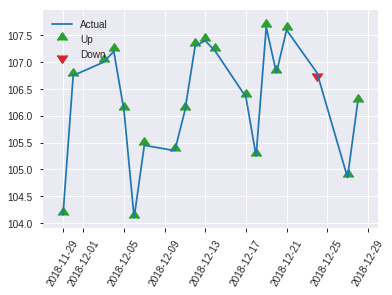


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.252552562902729
RMSE: 0.5025460803774406
LogLoss: 0.6983058643584432
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.29766117999407
Residual deviance: 350.54954390793847
AIC: 452.54954390793847
AUC: 0.4875859434682964
pr_auc: 0.4952671014431624
Gini: -0.024828113063407153
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39559224881779037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    117  0.9832   (117.0/119.0)
1      1    131  0.0076   (1.0/132.0)
Total  3    248  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395592     0.689474  247
max f2                       0.378095     0.84724   250
max f0point5                 0.395592     0.58274   247
max accuracy                 0.488318     0.537849  199
max precision                0.496025     0.551181  126
max recall                   0.378095     1         250
max specificity              0.591026     0.991597  0
max absolute_mcc             0.525214     0.150152  4
max min_per_class_accuracy   0.496028     0.521008  125
max mean_per_class_accuracy  0.496025     0.525656  126

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.584              0         0                  0                0.589929  0                           0.589929            0               0                          -100      -100
    2        0.0239044                   0.524675           0.633838  0.316919           0.333333         0.543256  0.166667                    0.566592            0.00757576      0.00757576                 -36.6162  -68.3081
    3        0.0318725                   0.522386           0.950758  0.475379           0.5              0.522462  0.25                        0.55556             0.00757576      0.0151515                  -4.92424  -52.4621
    4        0.0438247                   0.520906           1.26768   0.69146            0.666667         0.52176   0.363636                    0.546341            0.0151515       0.030303                   26.7677   -30.854
    5        0.0517928                   0.519541           0.950758  0.731352           0.5              0.520162  0.384615                    0.542314            0.00757576      0.0378788                  -4.92424  -26.8648
    6        0.103586                    0.511938           0.877622  0.804487           0.461538         0.515929  0.423077                    0.529121            0.0454545       0.0833333                  -12.2378  -19.5513
    7        0.151394                    0.509105           0.633838  0.750598           0.333333         0.510487  0.394737                    0.523237            0.030303        0.113636                   -36.6162  -24.9402
    8        0.203187                    0.505736           1.02389   0.820261           0.538462         0.507252  0.431373                    0.519162            0.0530303       0.166667                   2.38928   -17.9739
    9        0.302789                    0.502324           1.21697   0.950758           0.64             0.503888  0.5                         0.514138            0.121212        0.287879                   21.697    -4.92424
    10       0.40239                     0.498697           1.29303   1.03548            0.68             0.500326  0.544554                    0.510719            0.128788        0.416667                   29.303    3.54785
    11       0.501992                    0.496028           1.06485   1.04131            0.56             0.497124  0.547619                    0.508022            0.106061        0.522727                   6.48485   4.13059
    12       0.601594                    0.494087           0.684545  0.98224            0.36             0.495213  0.516556                    0.505901            0.0681818       0.590909                   -31.5455  -1.77604
    13       0.701195                    0.492262           1.21697   1.01558            0.64             0.493028  0.534091                    0.504072            0.121212        0.712121                   21.697    1.5582
    14       0.800797                    0.488138           1.06485   1.02171            0.56             0.490406  0.537313                    0.502373            0.106061        0.818182                   6.48485   2.17096
    15       0.900398                    0.478288           0.760606  0.992826           0.4              0.483456  0.522124                    0.50028             0.0757576       0.893939                   -23.9394  -0.71735
    16       1                           0.378095           1.06485   1                  0.56             0.454542  0.525896                    0.495724    

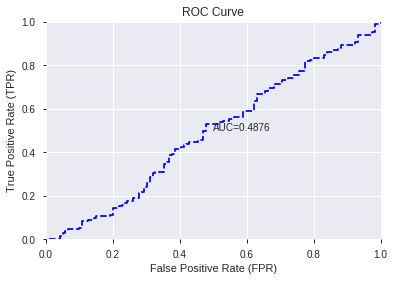

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


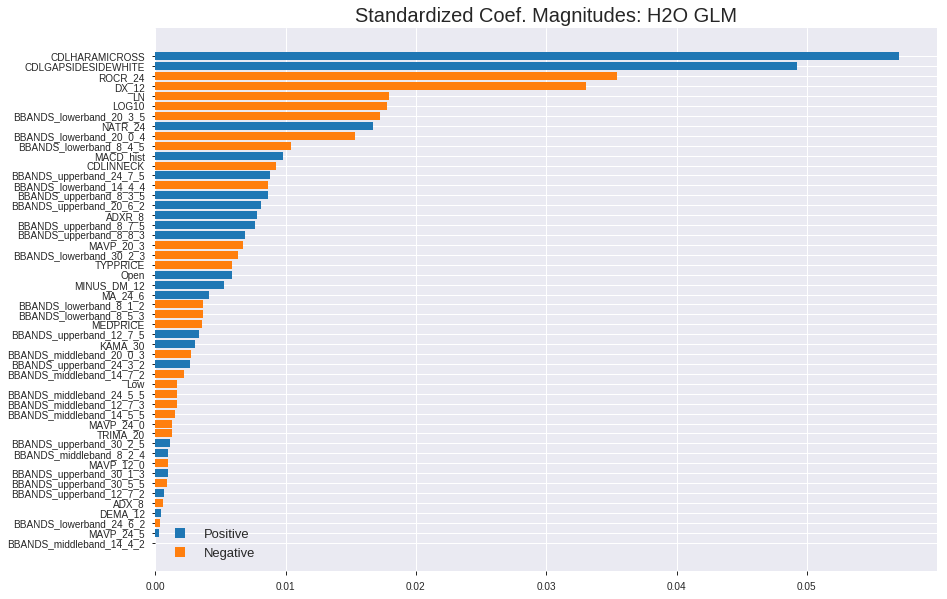

'log_likelihood'
--2019-08-27 13:41:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.192
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.192|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_134057_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_134057_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLHARAMICROSS',
 'CDLGAPSIDESIDEWHITE',
 'ROCR_24',
 'DX_12',
 'LN',
 'LOG10',
 'BBANDS_lowerband_20_3_5',
 'NATR_24',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_8_4_5',
 'MACD_hist',
 'CDLINNECK',
 'BBANDS_upperband_24_7_5',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_upperband_20_6_2',
 'ADXR_8',
 'BBANDS_upperband_8_7_5',
 'BBANDS_upperband_8_8_3',
 'MAVP_20_3',
 'BBANDS_lowerband_30_2_3',
 'TYPPRICE',
 'Open',
 'MINUS_DM_12',
 'MA_24_6',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_lowerband_8_5_3',
 'MEDPRICE',
 'BBANDS_upperband_12_7_5',
 'KAMA_30',
 'BBANDS_middleband_20_0_3',
 'BBANDS_upperband_24_3_2',
 'BBANDS_middleband_14_7_2',
 'Low',
 'BBANDS_middleband_24_5_5',
 'BBANDS_middleband_12_7_3',
 'BBANDS_middleband_14_5_5',
 'MAVP_24_0',
 'TRIMA_20',
 'BBANDS_upperband_30_2_5',
 'BBANDS_middleband_8_2_4',
 'MAVP_12_0',
 'BBANDS_upperband_30_1_3',
 'BBANDS_upperband_30_5_5',
 'BBANDS_upperband_12_7_2',
 'ADX_8',
 'DEMA_12',
 'BBANDS_lowerband_24_6_2',
 'MAVP_2

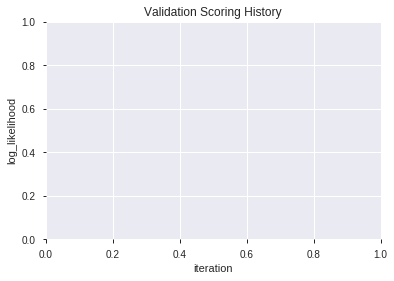

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_134108_model_4  0.564649  0.687234              0.495798  0.497055  0.247064
1  XGBoost_grid_1_AutoML_20190827_134108_model_1  0.556118  0.687684              0.486154  0.497268  0.247276
2  XGBoost_grid_1_AutoML_20190827_134108_model_7  0.554049  0.698880              0.482366  0.502225  0.252230
3               XGBoost_1_AutoML_20190827_134108  0.553731  0.709180              0.477336  0.507018  0.257067
4               XGBoost_2_AutoML_20190827_134108  0.538897  0.705133              0.481952  0.505583  0.255614
5  XGBoost_grid_1_AutoML_20190827_134108_model_5  0.533550  0.721526              0.491597  0.512638  0.262798
6  XGBoost_grid_1_AutoML_20190827_134108_model_2  0.533359  0.690525              0.500000  0.498693  0.248695
7  XGBoost_grid_1_AutoML_20190827_134108_model_6  0.526547  0.703675              0.474376  0.504912  0.254936
8               XGBoost_3_AutoML_20190827_134108  0.519321  0.696731              0.482779  0.501705  0.251708
9  XGBoost_grid_1_AutoML_20190827_134108_model_3  0.484371  0.712239              0.486981  0.508917  0.258996

variable  relative_importance  scaled_importance  percentage
0                  MACD_hist           301.897583           1.000000    0.147096
1                      DX_12           182.565552           0.604727    0.088953
2                    ROCR_24           173.103088           0.573383    0.084342
3                      ADX_8           157.706299           0.522383    0.076841
4                     ADXR_8           156.075562           0.516982    0.076046
5                MINUS_DM_12           137.298172           0.454784    0.066897
6                    NATR_24           105.413490           0.349170    0.051361
7    BBANDS_upperband_30_2_5            84.585648           0.280180    0.041213
8    BBANDS_upperband_24_7_5            74.470573           0.246675    0.036285
9    BBANDS_upperband_12_7_5            65.636993           0.217415    0.031981
10    BBANDS_lowerband_8_4_5            61.120041           0.202453    0.029780
11   BBANDS_lowerband_24_6_2            50.078934           0.165881    0.024400
12   BBANDS_lowerband_14_4_4            45.375809           0.150302    0.022109
13   BBANDS_lowerband_20_0_4            41.802238           0.138465    0.020368
14    BBANDS_upperband_8_3_5            37.147770           0.123048    0.018100
15   BBANDS_lowerband_20_3_5            35.220200           0.116663    0.017161
16   BBANDS_upperband_30_5_5            32.447319           0.107478    0.015810
17   BBANDS_lowerband_30_2_3            31.687212           0.104960    0.015439
18                        LN            31.036980           0.102806    0.015122
19   BBANDS_upperband_30_1_3            25.337652           0.083928    0.012345
20                 MAVP_20_3            25.248550           0.083633    0.012302
21   BBANDS_upperband_20_6_2            24.560614           0.081354    0.011967
22                      Open            23.613701           0.078218    0.011505
23    BBANDS_upperband_8_7_5            20.309996           0.067274    0.009896
24  BBANDS_middleband_12_7_3            14.643946           0.048506    0.007135
25  BBANDS_middleband_14_5_5            14.164571           0.046918    0.006902
26                       Low            12.989798           0.043027    0.006329
27   BBANDS_upperband_24_3_2            12.401467           0.041078    0.006042
28    BBANDS_lowerband_8_5_3            10.798357           0.035768    0.005261
29                  TRIMA_20            10.259775           0.033984    0.004999
30   BBANDS_upperband_12_7_2             7.482402           0.024785    0.003646
31                  TYPPRICE             7.157703           0.023709    0.003488
32                  MEDPRICE             6.991628           0.023159    0.003407
33                   MA_24_6             6.774748           0.022441    0.003301
34    BBANDS_lowerband_8_1_2             6.634328           0.021975    0.003232
35  BBANDS_middleband_24_5_5             6.239518           0.020668    0.003040
36                 MAVP_12_0             5.971739           0.019781    0.002910
37                   DEMA_12             4.163189           0.013790    0.002028
38    BBANDS_upperband_8_8_3             1.971753           0.006531    0.000961

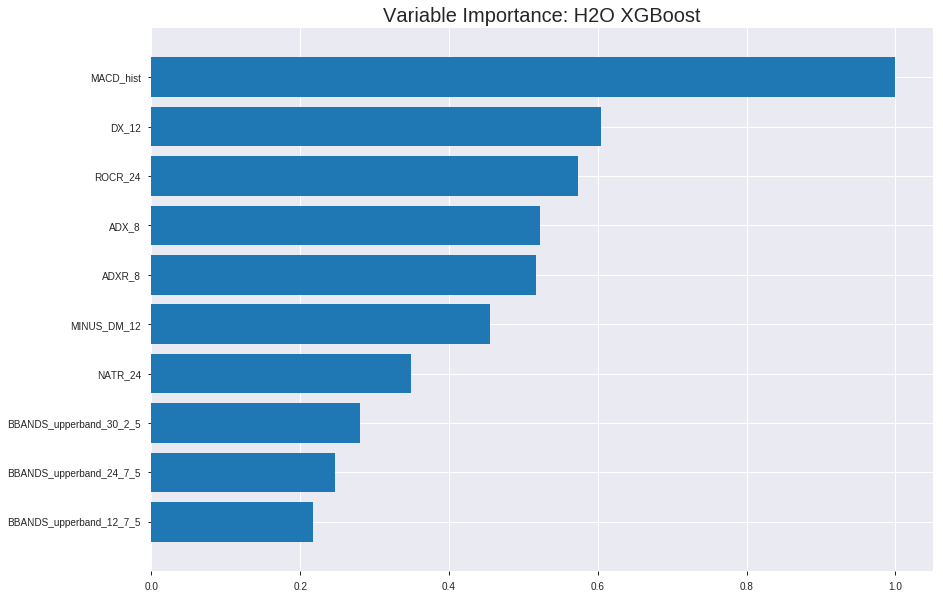

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_134108_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22819151276424315
RMSE: 0.47769395303294676
LogLoss: 0.6489274312029158
Mean Per-Class Error: 0.3234695288329603
AUC: 0.7263373036369233
pr_auc: 0.7356248725467455
Gini: 0.45267460727384656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4505987564722697: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      229  608   0.7264   (608.0/837.0)
1      63   853   0.0688   (63.0/916.0)
Total  292  1461  0.3828   (671.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450599     0.717711  307
max f2                       0.404649     0.849356  366
max f0point5                 0.523836     0.693662  191
max accuracy                 0.51308      0.676554  209
max precision                0.688472     1         0
max recall                   0.385313     1         385
max specificity              0.688472     1         0
max absolute_mcc             0.52311      0.352902  192
max min_per_class_accuracy   0.519195     0.671397  199
max mean_per_class_accuracy  0.52311      0.67653   192

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.656067           1.70112   1.70112            0.888889         0.674389  0.888889                    0.674389            0.0174672       0.0174672                  70.1116   70.1116
    2        0.0205362                   0.646683           1.91376   1.80744            1                0.650705  0.944444                    0.662547            0.0196507       0.0371179                  91.3755   80.7436
    3        0.0302339                   0.639164           1.68861   1.76932            0.882353         0.642953  0.924528                    0.656262            0.0163755       0.0534934                  68.8608   76.9321
    4        0.040502                    0.635598           1.48848   1.69812            0.777778         0.637345  0.887324                    0.651466            0.0152838       0.0687773                  48.8476   69.8121
    5        0.0501997                   0.628689           1.57603   1.67454            0.823529         0.632228  0.875                       0.64775             0.0152838       0.0840611                  57.6034   67.4536
    6        0.100399                    0.607066           1.5658    1.62017            0.818182         0.615357  0.846591                    0.631554            0.0786026       0.162664                   56.58     62.0168
    7        0.150029                    0.589986           1.38582   1.54265            0.724138         0.597309  0.806084                    0.620226            0.0687773       0.231441                   38.5823   54.2647
    8        0.200228                    0.578297           1.34833   1.49393            0.704545         0.583951  0.780627                    0.611131            0.0676856       0.299127                   34.8328   49.3929
    9        0.300057                    0.558671           1.33416   1.44077            0.697143         0.568379  0.752852                    0.596908            0.133188        0.432314                   33.4161   44.0774
    10       0.399886                    0.539451           1.20293   1.3814             0.628571         0.548799  0.721826                    0.584898            0.120087        0.552402                   20.2932   38.1398
    11       0.500285                    0.520049           1.13086   1.33112            0.590909         0.529868  0.695553                    0.573854            0.113537        0.665939                   13.0855   33.1118
    12       0.600114                    0.501777           0.885795  1.25704            0.462857         0.511104  0.656844                    0.563416            0.0884279       0.754367                   -11.4205  25.7039
    13       0.699943                    0.48298            0.743631  1.18381            0.388571         0.492651  0.618582                    0.553323            0.0742358       0.828603                   -25.6369  18.3815
    14       0.799772                    0.460315           0.754566  1.13024            0.394286         0.472123  0.590585                    0.543187            0.0753275       0.90393                    -24.5434  13.0235
    15       0.899601                    0.435119           0.568659  1.06792            0.297143         0.446842  0.558022                    0.532496            0.0567686       0.960699                   -43.1341  6.79168
    16       1                           0.342861           0.39145   1                  0.204545         0.411491  0.522533                    0.520347         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25196127727338513
RMSE: 0.5019574456797958
LogLoss: 0.6971625526535734
Mean Per-Class Error: 0.47986191024165703
AUC: 0.49530910369517966
pr_auc: 0.5144047479094656
Gini: -0.009381792609640671
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3926870822906494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.392687     0.690196   399
max f2                       0.392687     0.847784   399
max f0point5                 0.439813     0.585793   375
max accuracy                 0.463617     0.538922   346
max precision                0.645536     0.666667   2
max recall                   0.392687     1          399
max specificity              0.661132     0.995781   0
max absolute_mcc             0.553651     0.0669075  86
max min_per_class_accuracy   0.517226     0.493671   207
max mean_per_class_accuracy  0.488238     0.520138   289

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 51.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.640334           0.632576  0.632576           0.333333         0.646942  0.333333                    0.646942            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.626383           1.51818   1.03512            0.8              0.631908  0.545455                    0.640108            0.0151515       0.0227273                  51.8182   3.5124
    3        0.0319361                   0.611932           0.379545  0.830256           0.2              0.614318  0.4375                      0.632049            0.00378788      0.0265152                  -62.0455  -16.9744
    4        0.0419162                   0.603303           0.759091  0.813312           0.4              0.607588  0.428571                    0.626225            0.00757576      0.0340909                  -24.0909  -18.6688
    5        0.0518962                   0.599962           1.13864   0.875874           0.6              0.601506  0.461538                    0.621471            0.0113636       0.0454545                  13.8636   -12.4126
    6        0.101796                    0.579125           0.910909  0.893048           0.48             0.589317  0.470588                    0.605709            0.0454545       0.0909091                  -8.90909  -10.6952
    7        0.151697                    0.564106           0.986818  0.923894           0.52             0.570824  0.486842                    0.594234            0.0492424       0.140152                   -1.31818  -7.61065
    8        0.201597                    0.552317           0.835     0.90189            0.44             0.557243  0.475248                    0.585078            0.0416667       0.181818                   -16.5     -9.81098
    9        0.301397                    0.5381             1.02477   0.94258            0.54             0.544347  0.496689                    0.571591            0.102273        0.284091                   2.47727   -5.74202
    10       0.401198                    0.527301           1.13864   0.99135            0.6              0.532452  0.522388                    0.561855            0.113636        0.397727                   13.8636   -0.864993
    11       0.500998                    0.517226           0.986818  0.990447           0.52             0.523916  0.521912                    0.554297            0.0984848       0.496212                   -1.31818  -0.95527
    12       0.600798                    0.503592           0.986818  0.989844           0.52             0.510134  0.521595                    0.546961            0.0984848       0.594697                   -1.31818  -1.01555
    13       0.700599                    0.492206           1.21455   1.02185            0.64             0.497819  0.538462                    0.539961            0.121212        0.715909                   21.4545   2.18531
    14       0.800399                    0.479886           0.986818  1.01748            0.52             0.486173  0.53616                     0.533254            0.0984848       0.814394                   -1.31818  1.74847
    15       0.9002                      0.458351           0.948864  1.00988            0.5              0.469532  0.532151                    0.52619             0.094697        0.909091                   -5.11364  0.987704
    16       1                           0.392687           0.910909  1                  0.48             0.436758  0.526946                    0.517


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:41:16  2.685 sec   0                  0.5              0.693147            0.5             0                  1                0.477467                         0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 13:41:16  2.787 sec   5                  0.496373         0.685913            0.634753        0.622164           1.2065           0.444381                         0.500568           0.694285              0.446234          0.481929             0.79072            0.469062
    2019-08-27 13:41:16  2.842 sec   10                 0.493217         0.679642            0.657283        0.652065           1.30941          0.411865                         0.500583           0.694315              0.471711          0.502734             0.632576           0.469062
    2019-08-27 13:41:16  2.901 sec   15                 0.490575         0.674405            0.677811        0.676158           1.5948           0.3919                           0.500066           0.693281              0.501478          0.517529             0.948864           0.471058
    2019-08-27 13:41:16  2.958 sec   20                 0.488433         0.670153            0.681754        0.683846           1.5948           0.375927                         0.500164           0.69348               0.495533          0.521484             1.58144            0.473054
    2019-08-27 13:41:16  3.012 sec   25                 0.48665          0.666621            0.689292        0.693695           1.5948           0.413006                         0.500048           0.693258              0.506865          0.52148              0.948864           0.473054
    2019-08-27 13:41:17  3.077 sec   30                 0.484778         0.662923            0.698104        0.703049           1.70112          0.414718                         0.499982           0.693132              0.510972          0.524612             1.26515            0.473054
    2019-08-27 13:41:17  3.137 sec   35                 0.48281          0.659022            0.70505         0.712941           1.70112          0.395893                         0.500367           0.693916              0.505314          0.518113             1.26515            0.467066
    2019-08-27 13:41:17  3.208 sec   40                 0.480734         0.65492             0.713913        0.724541           1.80744          0.369082                         0.501466           0.696163              0.496132          0.510609             0.632576           0.471058
    2019-08-27 13:41:17  3.285 sec   45                 0.479026         0.651565            0.723395        0.732527           1.70112          0.373645                         0.501892           0.697013              0.487733          0.509553             0.948864           0.46507
    2019-08-27 13:41:17  3.352 sec   50                 0.477694         0.648927            0.726337        0.735625           1.70112          0.382772                         0.501957           0.697163              0.495309          0.514405             0.632576           0.473054

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
MACD_hist                 301.8975830078125      1.0                   0.14709598735218699
DX_12                     182.5655517578125      0.6047267750172352    0.08895288204946404
ROCR_24                   173.10308837890625     0.5733834854001686    0.0843424099163761
ADX_8                     157.706298828125       0.5223834429441055    0.07684050831629805
ADXR_8                    156.0755615234375      0.5169818186964371    0.07604595106428175
---                       ---                    ---                   ---
BBANDS_lowerband_8_1_2    6.6343278884887695     0.021975425647303332  0.0032324969330746562
BBANDS_middleband_24_5_5  6.239518165588379      0.020667665184410943  0.0030401306165653472
MAVP_12_0                 5.971739292144775      0.019780679370295717  0.002909658562470685
DEMA_12                   4.163188934326172      0.013790070436630282  0.0020284640265323356
BBANDS_upperband_8_8_3    1.971753478050232      0.006531199946702478  0.000960713304754752


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6910994764397906)

('auc', 0.5646485867074101)

('logloss', 0.6872341453677729)

('mean_per_class_error', 0.42592946269416854)

('rmse', 0.4970550438176007)

('mse', 0.24706371658451692)

xgboost prediction progress: |████████████████████████████████████████████| 100%


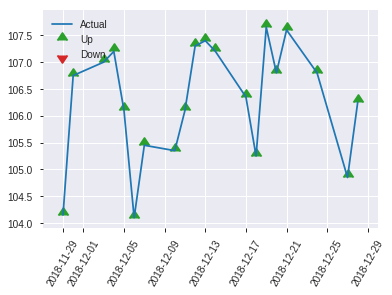


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24706371658451692
RMSE: 0.4970550438176007
LogLoss: 0.6872341453677729
Mean Per-Class Error: 0.42592946269416854
AUC: 0.5646485867074101
pr_auc: 0.5993433131177753
Gini: 0.12929717341482028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40231603384017944: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    118  0.9916   (118.0/119.0)
1      0    132  0        (0.0/132.0)
Total  1    250  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402316     0.691099  247
max f2                       0.402316     0.848329  247
max f0point5                 0.491413     0.601852  154
max accuracy                 0.495287     0.577689  142
max precision                0.616751     1         0
max recall                   0.402316     1         247
max specificity              0.616751     1         0
max absolute_mcc             0.587922     0.172277  7
max min_per_class_accuracy   0.502175     0.537879  121
max mean_per_class_accuracy  0.495287     0.574071  142

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.598195           1.90152   1.90152            1                0.609876  1                           0.609876            0.0227273       0.0227273                  90.1515   90.1515
    2        0.0239044                   0.593991           1.90152   1.90152            1                0.594895  1                           0.602386            0.0227273       0.0454545                  90.1515   90.1515
    3        0.0318725                   0.587702           1.90152   1.90152            1                0.58999   1                           0.599287            0.0151515       0.0606061                  90.1515   90.1515
    4        0.0438247                   0.583098           0         1.38292            0                0.585761  0.727273                    0.595598            0               0.0606061                  -100      38.292
    5        0.0517928                   0.579918           0.950758  1.31643            0.5              0.58017   0.692308                    0.593224            0.00757576      0.0681818                  -4.92424  31.6434
    6        0.103586                    0.562869           1.31643   1.31643            0.692308         0.570447  0.692308                    0.581836            0.0681818       0.136364                   31.6434   31.6434
    7        0.151394                    0.550299           0.792298  1.15092            0.416667         0.556509  0.605263                    0.573838            0.0378788       0.174242                   -20.7702  15.0917
    8        0.203187                    0.540035           1.02389   1.11854            0.538462         0.544374  0.588235                    0.566327            0.0530303       0.227273                   2.38928   11.8538
    9        0.302789                    0.523832           1.21697   1.15092            0.64             0.530932  0.605263                    0.554684            0.121212        0.348485                   21.697    15.0917
    10       0.40239                     0.51021            0.988788  1.11079            0.52             0.516672  0.584158                    0.545275            0.0984848       0.44697                    -1.12121  11.0786
    11       0.501992                    0.500854           0.912727  1.07149            0.48             0.505346  0.563492                    0.537353            0.0909091       0.537879                   -8.72727  7.14887
    12       0.601594                    0.492826           1.21697   1.09557            0.64             0.496994  0.576159                    0.530671            0.121212        0.659091                   21.697    9.5575
    13       0.701195                    0.482312           0.608485  1.02639            0.32             0.488377  0.539773                    0.524663            0.0606061       0.719697                   -39.1515  2.6386
    14       0.800797                    0.463104           0.760606  0.993329           0.4              0.473044  0.522388                    0.518243            0.0757576       0.795455                   -23.9394  -0.667119
    15       0.900398                    0.448604           1.14091   1.00965            0.6              0.454961  0.530973                    0.511243            0.113636        0.909091                   14.0909   0.965406
    16       1                           0.396213           0.912727  1                  0.48             0.428691  0.525896                    0.50302          

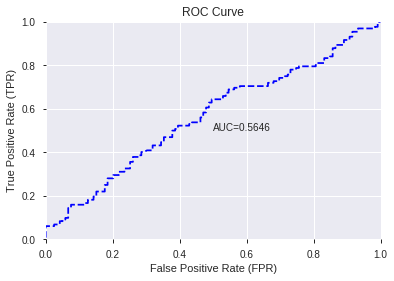

This function is available for GLM models only


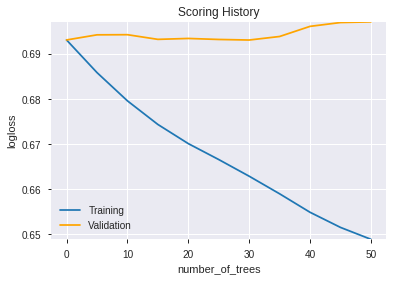

--2019-08-27 13:41:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_134108_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_134108_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MACD_hist',
 'DX_12',
 'ROCR_24',
 'ADX_8',
 'ADXR_8',
 'MINUS_DM_12',
 'NATR_24',
 'BBANDS_upperband_30_2_5',
 'BBANDS_upperband_24_7_5',
 'BBANDS_upperband_12_7_5',
 'BBANDS_lowerband_8_4_5',
 'BBANDS_lowerband_24_6_2',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_upperband_30_5_5',
 'BBANDS_lowerband_30_2_3',
 'LN',
 'BBANDS_upperband_30_1_3',
 'MAVP_20_3',
 'BBANDS_upperband_20_6_2',
 'Open',
 'BBANDS_upperband_8_7_5',
 'BBANDS_middleband_12_7_3',
 'BBANDS_middleband_14_5_5',
 'Low',
 'BBANDS_upperband_24_3_2',
 'BBANDS_lowerband_8_5_3',
 'TRIMA_20',
 'BBANDS_upperband_12_7_2',
 'TYPPRICE',
 'MEDPRICE',
 'MA_24_6',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_middleband_24_5_5',
 'MAVP_12_0',
 'DEMA_12',
 'BBANDS_upperband_8_8_3']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_134132_model_1  0.513305  0.69419                   0.5  0.500515  0.250515

variable  relative_importance  scaled_importance    percentage
0            CDLGRAVESTONEDOJI         8.406989e-03           1.000000  1.296322e-02
1                          BOP         7.442163e-03           0.885235  1.147550e-02
2                days_in_month         6.933384e-03           0.824717  1.069098e-02
3                 CDLENGULFING         6.326958e-03           0.752583  9.755902e-03
4                    CORREL_12         6.295964e-03           0.748896  9.708110e-03
...                        ...                  ...                ...           ...
1037                   MA_24_3         1.495490e-06           0.000178  2.305983e-06
1038  BBANDS_middleband_20_3_2         1.247989e-06           0.000148  1.924347e-06
1039                 MAVP_14_3         4.098641e-07           0.000049  6.319931e-07
1040   BBANDS_lowerband_24_6_2         4.064812e-07           0.000048  6.267769e-07
1041                   MA_14_7         1.552397e-07           0.000018  2.393731e-07

[1042 rows x 4 columns]

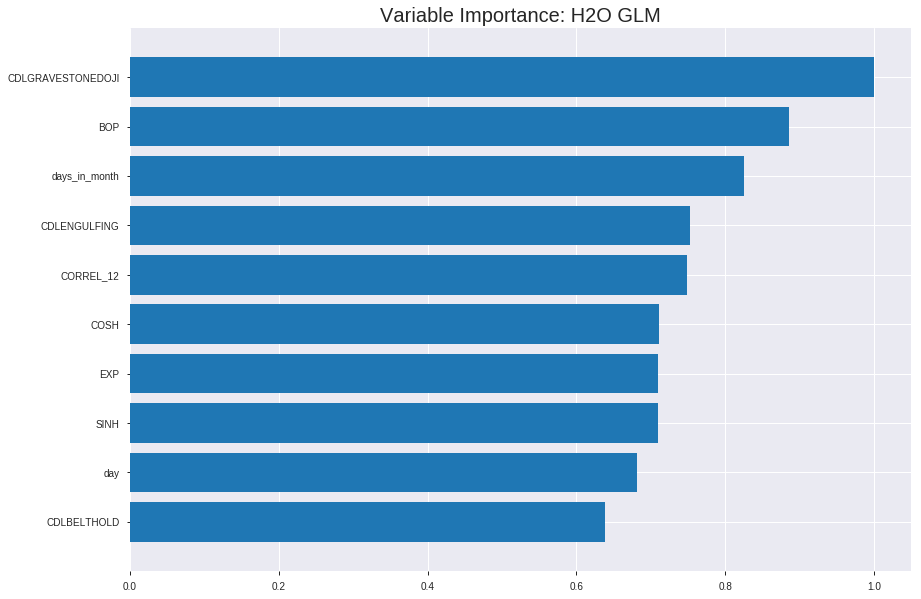

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_134132_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24574832674227481
RMSE: 0.4957300946505818
LogLoss: 0.68458452293393
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2426.6126264514623
Residual deviance: 2400.153337406359
AIC: 4486.153337406358
AUC: 0.5846206820992002
pr_auc: 0.6113696444412042
Gini: 0.1692413641984003
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4458567321388951: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   813   0.9713   (813.0/837.0)
1      4    912   0.0044   (4.0/916.0)
Total  28   1725  0.4661   (817.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445857     0.690647  377
max f2                       0.440365     0.846767  382
max f0point5                 0.513121     0.585881  229
max accuracy                 0.531715     0.567598  157
max precision                0.625654     1         0
max recall                   0.404649     1         395
max specificity              0.625654     1         0
max absolute_mcc             0.54721      0.151597  104
max min_per_class_accuracy   0.523713     0.555677  187
max mean_per_class_accuracy  0.531715     0.572334  157

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.591183           1.5948    1.5948             0.833333         0.598059  0.833333                    0.598059            0.0163755       0.0163755                  59.4796   59.4796
    2        0.0205362                   0.581965           1.48848   1.54164            0.777778         0.585285  0.805556                    0.591672            0.0152838       0.0316594                  48.8476   54.1636
    3        0.0302339                   0.577627           1.35089   1.48045            0.705882         0.579764  0.773585                    0.587852            0.0131004       0.0447598                  35.0886   48.0452
    4        0.040502                    0.572322           1.38216   1.45553            0.722222         0.574472  0.760563                    0.58446             0.0141921       0.058952                   38.2157   45.5532
    5        0.0501997                   0.569933           1.12574   1.39182            0.588235         0.571216  0.727273                    0.581902            0.010917        0.069869                   12.5739   39.1822
    6        0.100399                    0.559233           1.30483   1.34833            0.681818         0.563546  0.704545                    0.572724            0.0655022       0.135371                   30.4833   34.8328
    7        0.150029                    0.552044           1.09986   1.26613            0.574713         0.555392  0.661597                    0.566991            0.0545852       0.189956                   9.98595   26.6135
    8        0.200228                    0.547351           1.30483   1.27584            0.681818         0.549743  0.666667                    0.562666            0.0655022       0.255459                   30.4833   27.5837
    9        0.300057                    0.538489           1.02796   1.19337            0.537143         0.542614  0.623574                    0.555995            0.10262         0.358079                   2.79601   19.3368
    10       0.399886                    0.531493           1.09357   1.16846            0.571429         0.534747  0.610556                    0.55069             0.10917         0.467249                   9.35745   16.8456
    11       0.500285                    0.523641           0.880762  1.11072            0.460227         0.527667  0.580388                    0.54607             0.0884279       0.555677                   -11.9238  11.072
    12       0.600114                    0.516544           0.896731  1.07512            0.468571         0.52      0.561787                    0.541733            0.0895197       0.645197                   -10.3269  7.51231
    13       0.699943                    0.508698           0.929538  1.05436            0.485714         0.51292   0.550937                    0.537624            0.0927948       0.737991                   -7.04616  5.43592
    14       0.799772                    0.499991           0.87486   1.03195            0.457143         0.504463  0.53923                     0.533485            0.0873362       0.825328                   -12.514   3.19537
    15       0.899601                    0.484416           0.918603  1.01938            0.48             0.493171  0.532657                    0.529011            0.0917031       0.917031                   -8.13974  1.93751
    16       1                           0.360645           0.826394  1                  0.431818         0.464487  0.522533                    0.522533          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2489688763829058
RMSE: 0.49896781096870946
LogLoss: 0.6910800834746416
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 693.1168027311257
Residual deviance: 692.4622436415908
AIC: 2778.4622436415907
AUC: 0.5343626134765375
pr_auc: 0.5680184616855017
Gini: 0.06872522695307492
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45045291200201104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    229  0.9662   (229.0/237.0)
1      3    261  0.0114   (3.0/264.0)
Total  11   490  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450453     0.692308  388
max f2                       0.440868     0.848875  397
max f0point5                 0.450453     0.586781  388
max accuracy                 0.46479      0.538922  360
max precision                0.544211     0.777778  16
max recall                   0.440868     1         397
max specificity              0.56744      0.995781  0
max absolute_mcc             0.523695     0.104406  80
max min_per_class_accuracy   0.501073     0.518987  199
max mean_per_class_accuracy  0.523695     0.541475  80

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.550198           1.26515   1.26515            0.666667         0.557328  0.666667                    0.557328            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.547825           1.51818   1.38017            0.8              0.548512  0.727273                    0.553321            0.0151515       0.030303                   51.8182   38.0165
    3        0.0319361                   0.545071           1.51818   1.4233             0.8              0.546649  0.75                        0.551236            0.0151515       0.0454545                  51.8182   42.3295
    4        0.0419162                   0.542285           1.13864   1.35552            0.6              0.543603  0.714286                    0.549418            0.0113636       0.0568182                  13.8636   35.5519
    5        0.0518962                   0.54052            1.13864   1.31381            0.6              0.541058  0.692308                    0.547811            0.0113636       0.0681818                  13.8636   31.3811
    6        0.101796                    0.532911           0.986818  1.15352            0.52             0.536485  0.607843                    0.542259            0.0492424       0.117424                   -1.31818  15.352
    7        0.151697                    0.527266           1.13864   1.14862            0.6              0.529887  0.605263                    0.538189            0.0568182       0.174242                   13.8636   14.8624
    8        0.201597                    0.52343            1.29045   1.18373            0.68             0.525232  0.623762                    0.534982            0.0643939       0.238636                   29.0455   18.3731
    9        0.301397                    0.516922           0.948864  1.10596            0.5              0.519823  0.582781                    0.529963            0.094697        0.333333                   -5.11364  10.596
    10       0.401198                    0.50892            0.948864  1.06688            0.5              0.513391  0.562189                    0.52584             0.094697        0.42803                    -5.11364  6.68815
    11       0.500998                    0.501079           0.910909  1.03581            0.48             0.504888  0.545817                    0.521667            0.0909091       0.518939                   -8.90909  3.58113
    12       0.600798                    0.495351           0.948864  1.02137            0.5              0.498466  0.538206                    0.517813            0.094697        0.613636                   -5.11364  2.13682
    13       0.700599                    0.48842            0.948864  1.01104            0.5              0.49251   0.532764                    0.514208            0.094697        0.708333                   -5.11364  1.10399
    14       0.800399                    0.479794           0.948864  1.00329            0.5              0.483845  0.528678                    0.510422            0.094697        0.80303                    -5.11364  0.328724
    15       0.9002                      0.468192           1.02477   1.00567            0.54             0.474047  0.529933                    0.50639             0.102273        0.905303                   2.47727   0.566922
    16       1                           0.436364           0.948864  1                  0.5              0.457317  0.526946                    0.501492         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:41:35  0.000 sec   2            3.9       1043          1.36917           1.38216
    2019-08-27 13:41:38  2.053 sec   4            2.8       1043          1.36577           1.38235
    2019-08-27 13:41:39  3.915 sec   6            2.1       1043          1.3617            1.38272
    2019-08-27 13:41:41  5.822 sec   8            1.5       1043          1.35689           1.3834
    2019-08-27 13:41:43  7.743 sec   10           1.1       1043          1.35135           1.38446
    2019-08-27 13:41:45  9.660 sec   12           0.79      1043          1.34512           1.386

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6892950391644909)

('auc', 0.5133053221288516)

('logloss', 0.6941900901551602)

('mean_per_class_error', 0.4506302521008403)

('rmse', 0.500514957864259)

('mse', 0.250515223045861)

glm prediction progress: |████████████████████████████████████████████████| 100%


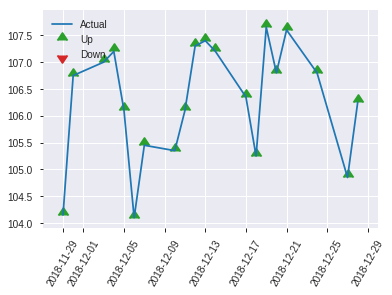


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.250515223045861
RMSE: 0.500514957864259
LogLoss: 0.6941900901551602
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 347.29766117999407
Residual deviance: 348.4834252578904
AIC: 2434.4834252578903
AUC: 0.5133053221288516
pr_auc: 0.5592634097986412
Gini: 0.02661064425770321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44156762826105356: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    132  0        (0.0/132.0)
Total  0    251  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441568     0.689295  250
max f2                       0.441568     0.84724   250
max f0point5                 0.475346     0.583004  219
max accuracy                 0.477344     0.537849  215
max precision                0.535772     0.75      7
max recall                   0.441568     1         250
max specificity              0.580677     0.991597  0
max absolute_mcc             0.456088     0.148586  244
max min_per_class_accuracy   0.497586     0.507576  124
max mean_per_class_accuracy  0.518255     0.54937   50

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.543083           1.26768   1.26768            0.666667         0.55689   0.666667                    0.55689             0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.539032           1.26768   1.26768            0.666667         0.540966  0.666667                    0.548928            0.0151515       0.030303                   26.7677   26.7677
    3        0.0318725                   0.535552           1.90152   1.42614            1                0.535843  0.75                        0.545656            0.0151515       0.0454545                  90.1515   42.6136
    4        0.0438247                   0.533215           1.26768   1.38292            0.666667         0.534423  0.727273                    0.542593            0.0151515       0.0606061                  26.7677   38.292
    5        0.0517928                   0.530981           0.950758  1.31643            0.5              0.531562  0.692308                    0.540896            0.00757576      0.0681818                  -4.92424  31.6434
    6        0.103586                    0.524401           1.17016   1.2433             0.615385         0.527985  0.653846                    0.53444             0.0606061       0.128788                   17.0163   24.3298
    7        0.151394                    0.520103           1.10922   1.20096            0.583333         0.521885  0.631579                    0.530475            0.0530303       0.181818                   10.9217   20.0957
    8        0.203187                    0.518255           1.31643   1.23039            0.692308         0.519319  0.647059                    0.527632            0.0681818       0.25                       31.6434   23.0392
    9        0.302789                    0.511452           0.608485  1.02582            0.32             0.515267  0.539474                    0.523564            0.0606061       0.310606                   -39.1515  2.58174
    10       0.40239                     0.504826           0.836667  0.978998           0.44             0.507917  0.514851                    0.519691            0.0833333       0.393939                   -16.3333  -2.10021
    11       0.501992                    0.497563           1.14091   1.01112            0.6              0.500307  0.531746                    0.515845            0.113636        0.507576                   14.0909   1.11231
    12       0.601594                    0.492936           0.836667  0.98224            0.44             0.494903  0.516556                    0.512378            0.0833333       0.590909                   -16.3333  -1.77604
    13       0.701195                    0.486434           1.14091   1.00478            0.6              0.489532  0.528409                    0.509133            0.113636        0.704545                   14.0909   0.477789
    14       0.800797                    0.481308           1.06485   1.01225            0.56             0.483728  0.532338                    0.505973            0.106061        0.810606                   6.48485   1.22494
    15       0.900398                    0.472261           0.836667  0.992826           0.44             0.477756  0.522124                    0.502852            0.0833333       0.893939                   -16.3333  -0.71735
    16       1                           0.441568           1.06485   1                  0.56             0.46027   0.525896                    0.49861       

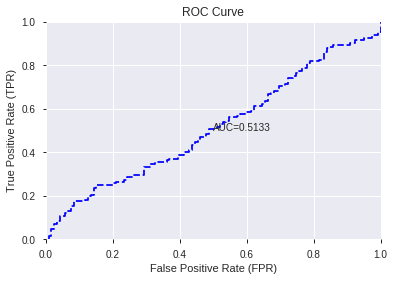

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


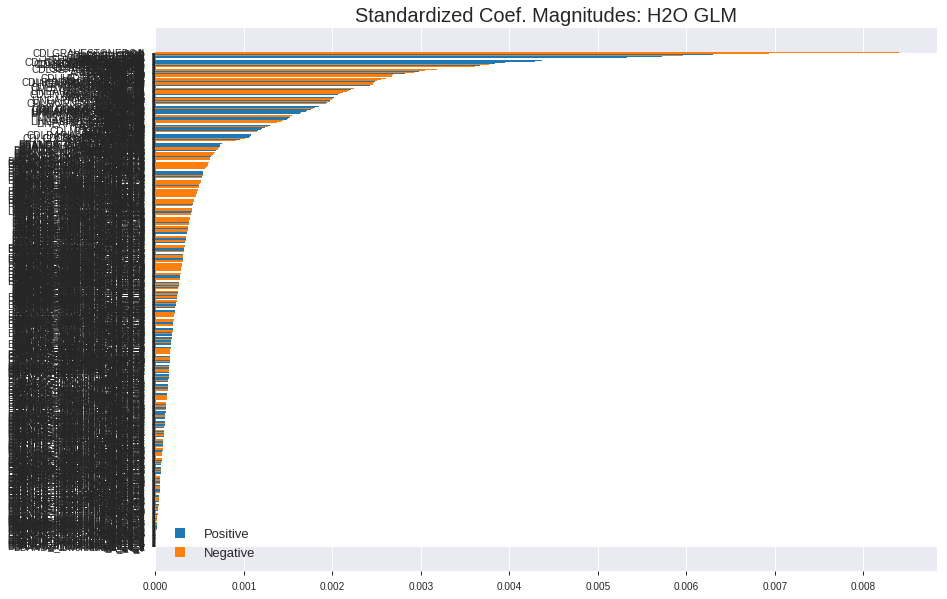

'log_likelihood'
--2019-08-27 13:42:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_134132_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_134132_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

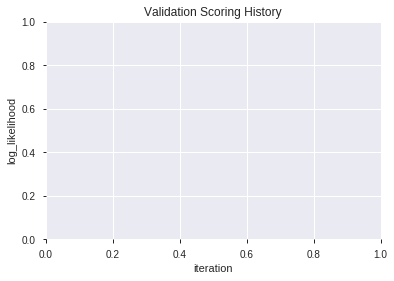

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_134214_model_1  0.604278  0.682650              0.486981  0.494720  0.244748
1               XGBoost_3_AutoML_20190827_134214  0.551502  0.690222              0.460530  0.498419  0.248421
2  XGBoost_grid_1_AutoML_20190827_134214_model_4  0.535332  0.691207              0.482366  0.499047  0.249048
3               XGBoost_1_AutoML_20190827_134214  0.528202  0.702158              0.482779  0.503935  0.253951
4  XGBoost_grid_1_AutoML_20190827_134214_model_3  0.525783  0.695487              0.482366  0.501140  0.251141
5               XGBoost_2_AutoML_20190827_134214  0.514642  0.699812              0.473135  0.503056  0.253065
6  XGBoost_grid_1_AutoML_20190827_134214_model_7  0.505984  0.718073              0.500000  0.511133  0.261257
7  XGBoost_grid_1_AutoML_20190827_134214_model_6  0.501401  0.703892              0.500000  0.505162  0.255188
8  XGBoost_grid_1_AutoML_20190827_134214_model_5  0.501146  0.727015              0.491183  0.514593  0.264806
9  XGBoost_grid_1_AutoML_20190827_134214_model_2  0.490960  0.703162              0.495798  0.504854  0.254877

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           133.372513           1.000000    0.030455
1                        BOP           127.266624           0.954219    0.029061
2                  dayofyear            88.701439           0.665065    0.020255
3                       week            80.266296           0.601820    0.018328
4                        SUB            74.265526           0.556828    0.016958
..                       ...                  ...                ...         ...
203  BBANDS_lowerband_12_7_5             4.780578           0.035844    0.001092
204                 MAVP_8_5             3.828952           0.028709    0.000874
205                    VAR_8             3.693741           0.027695    0.000843
206                   MFI_24             3.511715           0.026330    0.000802
207  BBANDS_lowerband_20_2_5             1.894745           0.014206    0.000433

[208 rows x 4 columns]

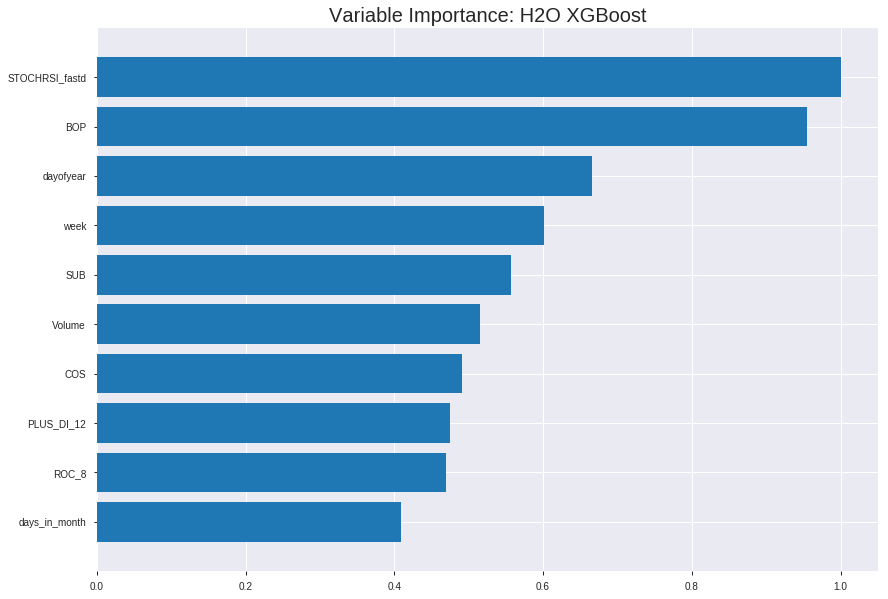

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_134214_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19038031563262192
RMSE: 0.43632592821493194
LogLoss: 0.5705166883307808
Mean Per-Class Error: 0.16751772550124433
AUC: 0.9132076505298087
pr_auc: 0.9276089837338416
Gini: 0.8264153010596174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49471468159130644: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      634  203   0.2425   (203.0/837.0)
1      103  813   0.1124   (103.0/916.0)
Total  737  1016  0.1746   (306.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494715     0.841615  224
max f2                       0.436548     0.886126  291
max f0point5                 0.548421     0.86612   168
max accuracy                 0.50936      0.832288  208
max precision                0.812468     1         0
max recall                   0.358891     1         350
max specificity              0.812468     1         0
max absolute_mcc             0.519101     0.664294  199
max min_per_class_accuracy   0.513122     0.828603  204
max mean_per_class_accuracy  0.519101     0.832482  199

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.744167           1.91376    1.91376            1                0.764616  1                           0.764616            0.0196507       0.0196507                  91.3755   91.3755
    2        0.0205362                   0.723718           1.91376    1.91376            1                0.73144   1                           0.748028            0.0196507       0.0393013                  91.3755   91.3755
    3        0.0302339                   0.704611           1.91376    1.91376            1                0.713624  1                           0.736993            0.018559        0.0578603                  91.3755   91.3755
    4        0.040502                    0.69529            1.91376    1.91376            1                0.699305  1                           0.727438            0.0196507       0.0775109                  91.3755   91.3755
    5        0.0501997                   0.689181           1.91376    1.91376            1                0.692824  1                           0.720751            0.018559        0.0960699                  91.3755   91.3755
    6        0.100399                    0.655002           1.91376    1.91376            1                0.67036   1                           0.695555            0.0960699       0.19214                    91.3755   91.3755
    7        0.150029                    0.630174           1.91376    1.91376            1                0.642614  1                           0.678042            0.0949782       0.287118                   91.3755   91.3755
    8        0.200228                    0.611162           1.89201    1.9083             0.988636         0.620957  0.997151                    0.66373             0.0949782       0.382096                   89.2008   90.8303
    9        0.300057                    0.57598            1.73878    1.8519             0.908571         0.592912  0.967681                    0.640169            0.173581        0.555677                   73.8784   85.1904
    10       0.399886                    0.545742           1.46539    1.75541            0.765714         0.559978  0.917261                    0.62015             0.146288        0.701965                   46.539    75.5413
    11       0.500285                    0.517583           1.14173    1.63226            0.596591         0.532171  0.852908                    0.602494            0.114629        0.816594                   14.1729   63.2257
    12       0.600114                    0.489937           0.809245   1.49535            0.422857         0.502899  0.781369                    0.585926            0.080786        0.89738                    -19.0755  49.5349
    13       0.699943                    0.463376           0.459301   1.34758            0.24             0.476515  0.704156                    0.570322            0.0458515       0.943231                   -54.0699  34.7583
    14       0.799772                    0.43627            0.36088    1.22442            0.188571         0.450778  0.6398                      0.5554              0.0360262       0.979258                   -63.912   22.4421
    15       0.899601                    0.395405           0.174972   1.10796            0.0914286        0.417272  0.578947                    0.540072            0.0174672       0.996725                   -82.5028  10.7964
    16       1                           0.219463           0.0326208  1                  0.0170455        0.34719   0.522533                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2569892809045358
RMSE: 0.5069411020074579
LogLoss: 0.7078320026620224
Mean Per-Class Error: 0.47787207518220176
AUC: 0.49879331287559137
pr_auc: 0.5235718782894879
Gini: -0.0024133742488172683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2913474142551422: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.291347     0.690196   399
max f2                       0.291347     0.847784   399
max f0point5                 0.291347     0.582011   399
max accuracy                 0.499379     0.530938   255
max precision                0.729382     1          0
max recall                   0.291347     1          399
max specificity              0.729382     1          0
max absolute_mcc             0.389738     0.0933462  365
max min_per_class_accuracy   0.525298     0.514768   198
max mean_per_class_accuracy  0.499379     0.522128   255

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 52.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.699243           1.26515   1.26515            0.666667         0.718327  0.666667                    0.718327            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.681825           0.759091  1.03512            0.4              0.690436  0.545455                    0.705649            0.00757576      0.0227273                  -24.0909  3.5124
    3        0.0319361                   0.662698           0.759091  0.948864           0.4              0.672676  0.5                         0.695345            0.00757576      0.030303                   -24.0909  -5.11364
    4        0.0419162                   0.647414           1.51818   1.08442            0.8              0.651636  0.571429                    0.684938            0.0151515       0.0454545                  51.8182   8.44156
    5        0.0518962                   0.640787           0.759091  1.02185            0.4              0.644504  0.538462                    0.677163            0.00757576      0.0530303                  -24.0909  2.18531
    6        0.101796                    0.618565           0.835     0.930258           0.44             0.629329  0.490196                    0.653715            0.0416667       0.094697                   -16.5     -6.97415
    7        0.151697                    0.600301           0.986818  0.948864           0.52             0.609667  0.5                         0.639225            0.0492424       0.143939                   -1.31818  -5.11364
    8        0.201597                    0.586838           0.910909  0.939469           0.48             0.59318   0.49505                     0.627828            0.0454545       0.189394                   -8.90909  -6.05311
    9        0.301397                    0.561927           1.17659   1.01799            0.62             0.573153  0.536424                    0.609724            0.117424        0.306818                   17.6591   1.79862
    10       0.401198                    0.543268           0.835     0.972467           0.44             0.551306  0.512438                    0.595192            0.0833333       0.390152                   -16.5     -2.75328
    11       0.500998                    0.525275           1.2525    1.02825            0.66             0.534181  0.541833                    0.583038            0.125           0.515152                   25.25     2.82506
    12       0.600798                    0.507342           0.986818  1.02137            0.52             0.516886  0.538206                    0.57205             0.0984848       0.613636                   -1.31818  2.13682
    13       0.700599                    0.49044            0.910909  1.00563            0.48             0.500693  0.529915                    0.561885            0.0909091       0.704545                   -8.90909  0.563326
    14       0.800399                    0.467032           1.02477   1.00802            0.54             0.477833  0.531172                    0.551405            0.102273        0.806818                   2.47727   0.801972
    15       0.9002                      0.412419           0.797045  0.98463            0.42             0.441608  0.518847                    0.539232            0.0795455       0.886364                   -20.2955  -1.53699
    16       1                           0.291347           1.13864   1                  0.6              0.368384  0.526946                    0.522181  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:42:31  0.008 sec   0                  0.5              0.693147            0.5             0                  1                0.477467                         0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 13:42:32  1.017 sec   5                  0.49047          0.674231            0.779137        0.806161           1.91376          0.332573                         0.500446           0.694043              0.496724          0.516694             0.948864           0.473054
    2019-08-27 13:42:32  1.237 sec   10                 0.482733         0.659               0.790743        0.818299           1.91376          0.293782                         0.501309           0.695807              0.496795          0.510795             0.948864           0.473054
    2019-08-27 13:42:32  1.442 sec   15                 0.474452         0.642893            0.833631        0.856148           1.91376          0.262407                         0.501445           0.696134              0.506241          0.52043              0.632576           0.473054
    2019-08-27 13:42:33  1.638 sec   20                 0.469872         0.633993            0.841985        0.865798           1.91376          0.245864                         0.501399           0.696089              0.514161          0.529904             0.948864           0.473054
    2019-08-27 13:42:33  1.871 sec   25                 0.462982         0.620768            0.865315        0.885886           1.91376          0.226469                         0.502364           0.698064              0.508719          0.531286             1.26515            0.473054
    2019-08-27 13:42:33  2.080 sec   30                 0.457587         0.610408            0.87375         0.892533           1.91376          0.207074                         0.503454           0.700323              0.502365          0.525967             1.26515            0.473054
    2019-08-27 13:42:33  2.285 sec   35                 0.452319         0.600399            0.8852          0.903021           1.91376          0.199658                         0.504576           0.702685              0.500591          0.524097             0.948864           0.473054
    2019-08-27 13:42:33  2.491 sec   40                 0.447225         0.590815            0.894302        0.910057           1.91376          0.187108                         0.505503           0.704714              0.500871          0.523469             1.26515            0.473054
    2019-08-27 13:42:34  2.706 sec   45                 0.441721         0.580533            0.905815        0.92085            1.91376          0.173417                         0.505775           0.705324              0.503476          0.528392             1.26515            0.473054
    2019-08-27 13:42:34  2.922 sec   50                 0.436326         0.570517            0.913208        0.927609           1.91376          0.174558                         0.506941           0.707832              0.498793          0.523572             1.26515            0.473054

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
STOCHRSI_fastd           133.3725128173828      1.0                   0.030455099262104504
BOP                      127.2666244506836      0.954219289734313     0.02906084318667336
dayofyear                88.7014389038086       0.6650653648946463    0.020254631703654206
week                     80.26629638671875      0.6018203803104579    0.018328499420312477
SUB                      74.2655258178711       0.5568278219332752    0.016958246588879344
---                      ---                    ---                   ---
BBANDS_lowerband_12_7_5  4.780578136444092      0.03584380346038607   0.0010916265923174226
MAVP_8_5                 3.828951835632324      0.028708702826009035  0.0008743263942523652
VAR_8                    3.6937408447265625     0.0276949182908785    0.0008434514856045783
MFI_24                   3.5117154121398926     0.02633012858465242   0.0008018866796295646
BBANDS_lowerband_20_2_5  1.894744873046875      0.01420641204864461   0.000432657689099829


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6095617529880478)

('F1', 0.6931216931216931)

('auc', 0.6042780748663101)

('logloss', 0.6826503940555262)

('mean_per_class_error', 0.38941940412528653)

('rmse', 0.4947203651425679)

('mse', 0.24474823968679568)

xgboost prediction progress: |████████████████████████████████████████████| 100%


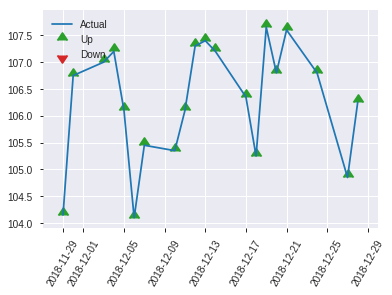


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24474823968679568
RMSE: 0.4947203651425679
LogLoss: 0.6826503940555262
Mean Per-Class Error: 0.38941940412528653
AUC: 0.6042780748663101
pr_auc: 0.6067096306212326
Gini: 0.20855614973262027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4335276782512665: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    115  0.9664   (115.0/119.0)
1      1    131  0.0076   (1.0/132.0)
Total  5    246  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433528     0.693122  245
max f2                       0.343788     0.84724   250
max f0point5                 0.544339     0.629032  121
max accuracy                 0.544339     0.609562  121
max precision                0.614522     0.72      24
max recall                   0.343788     1         250
max specificity              0.711708     0.991597  0
max absolute_mcc             0.544339     0.22095   121
max min_per_class_accuracy   0.54374      0.598485  123
max mean_per_class_accuracy  0.544339     0.610581  121

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 54.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.679699           1.26768   1.26768            0.666667         0.691934  0.666667                    0.691934            0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.6648             0.633838  0.950758           0.333333         0.669523  0.5                         0.680728            0.00757576      0.0227273                  -36.6162  -4.92424
    3        0.0318725                   0.651342           1.90152   1.18845            1                0.657429  0.625                       0.674903            0.0151515       0.0378788                  90.1515   18.8447
    4        0.0438247                   0.644189           0.633838  1.03719            0.333333         0.64588   0.545455                    0.666988            0.00757576      0.0454545                  -36.6162  3.71901
    5        0.0517928                   0.63806            1.90152   1.17016            1                0.640227  0.615385                    0.662871            0.0151515       0.0606061                  90.1515   17.0163
    6        0.103586                    0.614213           1.4627    1.31643            0.769231         0.624673  0.692308                    0.643772            0.0757576       0.136364                   46.2704   31.6434
    7        0.151394                    0.598034           1.26768   1.30104            0.666667         0.60522   0.684211                    0.631597            0.0606061       0.19697                    26.7677   30.1037
    8        0.203187                    0.586295           0.877622  1.19311            0.461538         0.589885  0.627451                    0.620965            0.0454545       0.242424                   -12.2378  19.3108
    9        0.302789                    0.569129           1.36909   1.251              0.72             0.575335  0.657895                    0.605955            0.136364        0.378788                   36.9091   25.0997
    10       0.40239                     0.557391           1.14091   1.22375            0.6              0.563783  0.643564                    0.595516            0.113636        0.492424                   14.0909   22.3747
    11       0.501992                    0.543103           1.06485   1.19222            0.56             0.550377  0.626984                    0.58656             0.106061        0.598485                   6.48485   19.222
    12       0.601594                    0.530883           0.912727  1.14595            0.48             0.537305  0.602649                    0.578405            0.0909091       0.689394                   -8.72727  14.5946
    13       0.701195                    0.516993           0.836667  1.10201            0.44             0.52423   0.579545                    0.57071             0.0833333       0.772727                   -16.3333  10.2014
    14       0.800797                    0.501537           0.456364  1.02171            0.24             0.510211  0.537313                    0.563185            0.0454545       0.818182                   -54.3636  2.17096
    15       0.900398                    0.479846           0.760606  0.992826           0.4              0.488038  0.522124                    0.554872            0.0757576       0.893939                   -23.9394  -0.71735
    16       1                           0.343788           1.06485   1                  0.56             0.450452  0.525896                    0.544472        

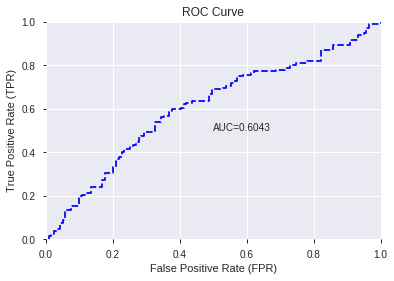

This function is available for GLM models only


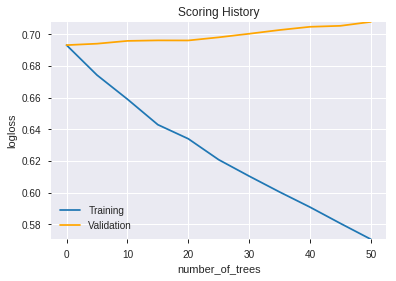

--2019-08-27 13:43:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_134214_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_134214_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_134313_model_7  0.508212  0.695135              0.500000  0.501001  0.251002
1               DeepLearning_1_AutoML_20190827_134313  0.507257  0.760527              0.491597  0.529007  0.279848
2  DeepLearning_grid_1_AutoML_20190827_134313_model_6  0.500000  0.691915              0.500000  0.499384  0.249384
3  DeepLearning_grid_1_AutoML_20190827_134313_model_8  0.500000  0.691811              0.500000  0.499332  0.249332
4  DeepLearning_grid_1_AutoML_20190827_134313_model_9  0.500000  0.691834              0.500000  0.499343  0.249344
5  DeepLearning_grid_1_AutoML_20190827_134313_model_2  0.493952  0.805263              0.500000  0.540166  0.291779
6  DeepLearning_grid_1_AutoML_20190827_134313_model_3  0.490578  0.762154              0.491597  0.530799  0.281747
7  DeepLearning_grid_1_AutoML_20190827_134313_model_5  0.473389  0.694596              0.487395  0.500710  0.250710
8  DeepLearning_grid_1_AutoML_20190827_134313_model_4  0.471034  0.703495              0.495798  0.504780  0.254803
9  DeepLearning_grid_1_AutoML_20190827_134313_model_1  0.439012  0.952592              0.500000  0.585186  0.342443

variable  relative_importance  scaled_importance  percentage
0                    ROCR_24             1.000000           1.000000    0.029189
1                  MACD_hist             0.957164           0.957164    0.027939
2                      DX_12             0.883358           0.883358    0.025784
3             CDLHARAMICROSS             0.864974           0.864974    0.025248
4                MINUS_DM_12             0.797830           0.797830    0.023288
5                      ADX_8             0.749992           0.749992    0.021891
6                    NATR_24             0.719152           0.719152    0.020991
7                     ADXR_8             0.695460           0.695460    0.020300
8    BBANDS_lowerband_14_4_4             0.688229           0.688229    0.020089
9                   TYPPRICE             0.687618           0.687618    0.020071
10   BBANDS_upperband_30_2_5             0.684712           0.684712    0.019986
11       CDLGAPSIDESIDEWHITE             0.683077           0.683077    0.019938
12    BBANDS_upperband_8_8_3             0.681745           0.681745    0.019899
13   BBANDS_lowerband_20_3_5             0.677841           0.677841    0.019785
14                 MAVP_24_5             0.675646           0.675646    0.019721
15    BBANDS_lowerband_8_1_2             0.675644           0.675644    0.019721
16   BBANDS_middleband_8_2_4             0.675271           0.675271    0.019710
17                 CDLINNECK             0.673142           0.673142    0.019648
18                      Open             0.671440           0.671440    0.019599
19                 MAVP_20_3             0.671340           0.671340    0.019596
20   BBANDS_upperband_12_7_5             0.670002           0.670002    0.019557
21    BBANDS_lowerband_8_4_5             0.667886           0.667886    0.019495
22                       Low             0.663739           0.663739    0.019374
23                 MAVP_24_0             0.663616           0.663616    0.019370
24  BBANDS_middleband_14_5_5             0.661467           0.661467    0.019308
25   BBANDS_lowerband_20_0_4             0.660776           0.660776    0.019287
26                  MEDPRICE             0.659067           0.659067    0.019237
27                   DEMA_12             0.658399           0.658399    0.019218
28   BBANDS_lowerband_30_2_3             0.657726           0.657726    0.019198
29   BBANDS_upperband_12_7_2             0.657273           0.657273    0.019185
30                     LOG10             0.656738           0.656738    0.019169
31   BBANDS_lowerband_24_6_2             0.656565           0.656565    0.019164
32                        LN             0.656140           0.656140    0.019152
33  BBANDS_middleband_20_0_3             0.655383           0.655383    0.019130
34                  TRIMA_20             0.652721           0.652721    0.019052
35   BBANDS_upperband_30_1_3             0.650883           0.650883    0.018999
36                 MAVP_12_0             0.650358           0.650358    0.018983
37  BBANDS_middleband_14_4_2             0.649806           0.649806    0.018967
38  BBANDS_middleband_12_7_3             0.648589           0.648589    0.018932
39    BBANDS_upperband_8_3_5             0.645175           0.645175    0.018832
40   BBANDS_upperband_30_5_5             0.645104           0.645104    0.018830
41  BBANDS_middleband_24_5_5             0.644022           0.644022    0.018798
42  BBANDS_middleband_14_7_2             0.642139           0.642139    0.018743
43                   KAMA_30             0.642012           0.642012    0.018740
44   BBANDS_upperband_24_7_5             0.641381           0.641381    0.018721
45   BBANDS_upperband_20_6_2             0.632823           0.632823    0.018471
46    BBANDS_upperband_8_7_5             0.625046           0.625046    0.018244
47   BBANDS_upperband_24_3_2             0.623625           0.623625    0.018203
48                   MA_24_6             0.604503  

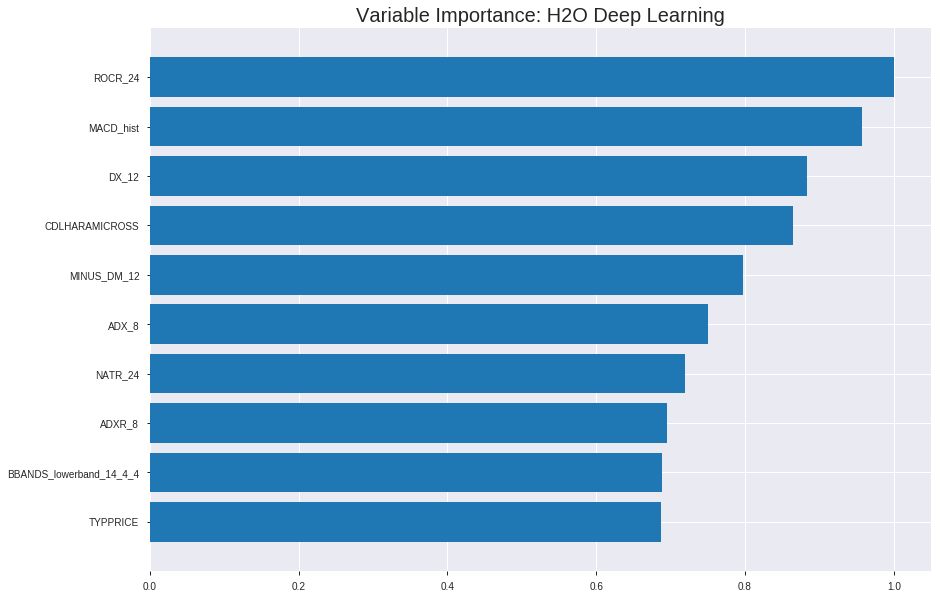

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_134313_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24218117002293646
RMSE: 0.4921190608205869
LogLoss: 0.6755138614315017
Mean Per-Class Error: 0.4287340940038503
AUC: 0.5729980226740334
pr_auc: 0.6170424062867754
Gini: 0.14599604534806687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4840943001984127: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      26   811   0.9689   (811.0/837.0)
1      4    912   0.0044   (4.0/916.0)
Total  30   1723  0.4649   (815.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484094     0.691171  373
max f2                       0.280052     0.846737  392
max f0point5                 0.484094     0.584016  373
max accuracy                 0.566857     0.560753  239
max precision                0.990514     1         0
max recall                   0.280052     1         392
max specificity              0.990514     1         0
max absolute_mcc             0.572746     0.162865  229
max min_per_class_accuracy   0.499064     0.503275  356
max mean_per_class_accuracy  0.572746     0.571266  229

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 54.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.826131           1.91376   1.91376            1                0.911019  1                           0.911019            0.0196507       0.0196507                  91.3755   91.3755
    2        0.0205362                   0.783463           1.38216   1.64796            0.722222         0.804547  0.861111                    0.857783            0.0141921       0.0338428                  38.2157   64.7956
    3        0.0302339                   0.737375           1.46346   1.58878            0.764706         0.758003  0.830189                    0.825778            0.0141921       0.0480349                  46.346    58.8778
    4        0.040502                    0.712956           1.38216   1.5364             0.722222         0.722602  0.802817                    0.799621            0.0141921       0.0622271                  38.2157   53.6395
    5        0.0501997                   0.706187           1.12574   1.45706            0.588235         0.708613  0.761364                    0.78204             0.010917        0.0731441                  12.5739   45.7064
    6        0.100399                    0.657414           1.26134   1.3592             0.659091         0.68022   0.710227                    0.73113             0.0633188       0.136463                   26.1339   35.9201
    7        0.150029                    0.626962           1.20985   1.30979            0.632184         0.641962  0.684411                    0.701633            0.0600437       0.196507                   20.9845   30.9795
    8        0.200228                    0.598177           1.10911   1.25948            0.579545         0.611947  0.65812                     0.679148            0.0556769       0.252183                   10.9108   25.948
    9        0.300057                    0.551519           1.12638   1.2152             0.588571         0.575821  0.634981                    0.644771            0.112445        0.364629                   12.6382   21.5198
    10       0.399886                    0.513383           0.809245  1.11385            0.422857         0.532736  0.582026                    0.616802            0.080786        0.445415                   -19.0755  11.3855
    11       0.96178                     0.498951           0.934534  1.00909            0.488325         0.499543  0.527284                    0.548297            0.525109        0.970524                   -6.54656  0.90917
    12       1                           0.010237           0.771215  1                  0.402985         0.4231    0.522533                    0.543512            0.029476        1                          -22.8785  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2551341652157192
RMSE: 0.5051080728079083
LogLoss: 0.7049916762310797
Mean Per-Class Error: 0.4947257383966245
AUC: 0.47976601457614115
pr_auc: 0.5034027206384856
Gini: -0.040467970847717694
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49895134928785484: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.498951     0.690196   190
max f2                       0.498951     0.847784   190
max f0point5                 0.498951     0.582011   190
max accuracy                 0.498951     0.526946   190
max precision                0.887551     1          0
max recall                   0.498951     1          190
max specificity              0.887551     1          0
max absolute_mcc             0.62735      0.0664902  42
max min_per_class_accuracy   0.498988     0.359848   189
max mean_per_class_accuracy  0.579036     0.505274   80

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.792248           0.948864  0.948864           0.5              0.839959  0.5                         0.839959            0.0113636       0.0113636                  -5.11364  -5.11364
    2        0.0219561                   0.703757           0.379545  0.690083           0.2              0.732501  0.363636                    0.791114            0.00378788      0.0151515                  -62.0455  -30.9917
    3        0.0319361                   0.68134            1.13864   0.830256           0.6              0.693348  0.4375                      0.760562            0.0113636       0.0265152                  13.8636   -16.9744
    4        0.0419162                   0.664873           1.13864   0.90368            0.6              0.670972  0.47619                     0.739231            0.0113636       0.0378788                  13.8636   -9.63203
    5        0.0518962                   0.653387           0.759091  0.875874           0.4              0.657575  0.461538                    0.723528            0.00757576      0.0454545                  -24.0909  -12.4126
    6        0.101796                    0.614467           0.910909  0.893048           0.48             0.63293   0.470588                    0.679117            0.0454545       0.0909091                  -8.90909  -10.6952
    7        0.151697                    0.580542           1.21455   0.998804           0.64             0.597745  0.526316                    0.65235             0.0606061       0.151515                   21.4545   -0.119617
    8        0.201597                    0.553371           0.759091  0.939469           0.4              0.567524  0.49505                     0.631353            0.0378788       0.189394                   -24.0909  -6.05311
    9        0.301397                    0.517652           1.06273   0.980283           0.56             0.532168  0.516556                    0.59851             0.106061        0.295455                   6.27273   -1.9717
    10       1                           0.498951           1.00851   1                  0.531429         0.499776  0.526946                    0.529534            0.704545        1                          0.850649  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:47:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:47:49  4.932 sec         287 obs/sec       0.649173  1             1138       0.648584         1.39743             -0.686067      0.482321        0.515364           1.27584          0.472904                         0.659063           1.54086               -0.742517        0.469745          0.513983             1.26515            0.46507
    2019-08-27 13:47:59  15.386 sec        679 obs/sec       5.2259    8             9161       0.635519         1.23919             -0.618825      0.534571        0.561791           1.70112          0.473474                         0.634613           1.24067               -0.615625        0.550002          0.556933             0.948864           0.449102
    2019-08-27 13:48:09  25.505 sec        804 obs/sec       10.3942   16            18221      0.65534          1.27583             -0.721379      0.530761        0.576259           1.70112          0.469481                         0.660689           1.2956                -0.751126        0.497315          0.530836             1.26515            0.473054
    2019-08-27 13:48:19  35.703 sec        891 obs/sec       16.2253   25            28443      0.539949         0.787638            -0.168553      0.546062        0.594835           1.80744          0.472904                         0.540255           0.790858              -0.170901        0.504587          0.535475             1.26515            0.471058
    2019-08-27 13:48:29  45.300 sec        925 obs/sec       21.4164   33            37543      0.500858         0.693514            -0.00547606    0.553473        0.591108           1.70112          0.472333                         0.507535           0.70924               -0.0333691       0.46829           0.50753              1.26515            0.473054
    2019-08-27 13:48:39  55.210 sec        987 obs/sec       27.9047   43            48917      0.509522         0.712577            -0.0405633     0.566413        0.601405           1.80744          0.472333                         0.514477           0.726685              -0.061829        0.517101          0.528511             1.26515            0.471058
    2019-08-27 13:48:49  1 min  4.840 sec  1034 obs/sec      34.3805   53            60269      0.534532         0.770445            -0.145222      0.553407        0.601039           1.70112          0.469481                         0.546625           0.799115              -0.198677        0.494007          0.522507             1.26515            0.473054
    2019-08-27 13:48:58  1 min 14.388 sec  1087 obs/sec      41.4929   64            72737      0.492119         0.675514            0.0293039      0.572998        0.617042           1.91376          0.464917                         0.505108           0.704992              -0.0235093       0.479766          0.503403             0.948864           0.473054
    2019-08-27 13:49:08 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
ROCR_24                  1.0                    1.0                  0.029188954092739215
MACD_hist                0.9571636319160461     0.9571636319160461   0.027938605311237007
DX_12                    0.8833579421043396     0.8833579421043396   0.025784294419540155
CDLHARAMICROSS           0.8649736642837524     0.8649736642837524   0.025247676578206875
MINUS_DM_12              0.7978295087814331     0.7978295087814331   0.02328780890565393
---                      ---                    ---                  ---
BBANDS_upperband_20_6_2  0.63282310962677       0.63282310962677     0.018471444695720266
BBANDS_upperband_8_7_5   0.6250464916229248     0.6250464916229248   0.01824445334980926
BBANDS_upperband_24_3_2  0.6236253380775452     0.6236253380775452   0.018202971364214438
MA_24_6                  0.6045032143592834     0.6045032143592834   0.01764481657284642
BBANDS_lowerband_8_5_3   0.6029378771781921     0.6029378771781921   0.017599126017727888


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5258964143426295)

('F1', 0.6892950391644909)

('auc', 0.5082123758594347)

('logloss', 0.695135298670416)

('mean_per_class_error', 0.47198879551820727)

('rmse', 0.5010006978204617)

('mse', 0.2510016992165896)

deeplearning prediction progress: |███████████████████████████████████████| 100%


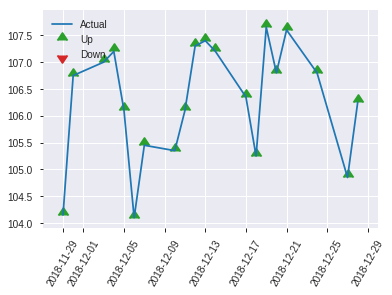


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2510016992165896
RMSE: 0.5010006978204617
LogLoss: 0.695135298670416
Mean Per-Class Error: 0.47198879551820727
AUC: 0.5082123758594347
pr_auc: 0.5237438764351056
Gini: 0.016424751718869368
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49895134928785495: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    132  0        (0.0/132.0)
Total  0    251  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.498951     0.689295   86
max f2                       0.498951     0.84724    86
max f0point5                 0.498951     0.580986   86
max accuracy                 0.498951     0.525896   86
max precision                0.788066     1          0
max recall                   0.498951     1          86
max specificity              0.788066     1          0
max absolute_mcc             0.556277     0.0773064  38
max min_per_class_accuracy   0.501251     0.356061   83
max mean_per_class_accuracy  0.504051     0.528011   76

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.643484           1.26768   1.26768            0.666667         0.704956  0.666667                    0.704956            0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.636071           0.633838  0.950758           0.333333         0.638219  0.5                         0.671588            0.00757576      0.0227273                  -36.6162  -4.92424
    3        0.0318725                   0.619142           0.950758  0.950758           0.5              0.625612  0.5                         0.660094            0.00757576      0.030303                   -4.92424  -4.92424
    4        0.0438247                   0.616476           1.26768   1.03719            0.666667         0.61702   0.545455                    0.648346            0.0151515       0.0454545                  26.7677   3.71901
    5        0.0517928                   0.604954           0         0.877622           0                0.608896  0.461538                    0.642277            0               0.0454545                  -100      -12.2378
    6        0.103586                    0.572251           1.02389   0.950758           0.538462         0.589855  0.5                         0.616066            0.0530303       0.0984848                  2.38928   -4.92424
    7        0.151394                    0.558693           0.633838  0.850678           0.333333         0.566405  0.447368                    0.600384            0.030303        0.128788                   -36.6162  -14.9322
    8        0.203187                    0.546083           1.31643   0.9694             0.692308         0.552308  0.509804                    0.588129            0.0681818       0.19697                    31.6434   -3.06001
    9        0.302789                    0.504844           1.29303   1.07586            0.68             0.524273  0.565789                    0.567124            0.128788        0.325758                   29.303    7.58573
    10       1                           0.498951           0.967056  1                  0.508571         0.499146  0.525896                    0.519729            0.674242        1                          -3.29437  0

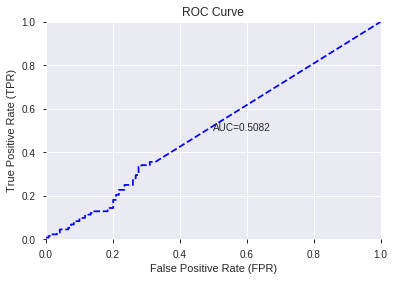

This function is available for GLM models only


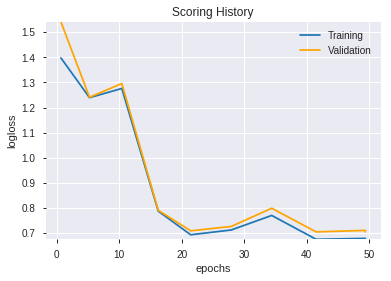

--2019-08-27 13:51:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_134313_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_134313_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['ROCR_24',
 'MACD_hist',
 'DX_12',
 'CDLHARAMICROSS',
 'MINUS_DM_12',
 'ADX_8',
 'NATR_24',
 'ADXR_8',
 'BBANDS_lowerband_14_4_4',
 'TYPPRICE',
 'BBANDS_upperband_30_2_5',
 'CDLGAPSIDESIDEWHITE',
 'BBANDS_upperband_8_8_3',
 'BBANDS_lowerband_20_3_5',
 'MAVP_24_5',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_middleband_8_2_4',
 'CDLINNECK',
 'Open',
 'MAVP_20_3',
 'BBANDS_upperband_12_7_5',
 'BBANDS_lowerband_8_4_5',
 'Low',
 'MAVP_24_0',
 'BBANDS_middleband_14_5_5',
 'BBANDS_lowerband_20_0_4',
 'MEDPRICE',
 'DEMA_12',
 'BBANDS_lowerband_30_2_3',
 'BBANDS_upperband_12_7_2',
 'LOG10',
 'BBANDS_lowerband_24_6_2',
 'LN',
 'BBANDS_middleband_20_0_3',
 'TRIMA_20',
 'BBANDS_upperband_30_1_3',
 'MAVP_12_0',
 'BBANDS_middleband_14_4_2',
 'BBANDS_middleband_12_7_3',
 'BBANDS_upperband_8_3_5',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_24_5_5',
 'BBANDS_middleband_14_7_2',
 'KAMA_30',
 'BBANDS_upperband_24_7_5',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_8_7_5',
 'BBANDS_upperband_24_3_2',
 'MA

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_135122_model_1  0.487586  0.698306              0.495385  0.502546  0.252553

variable  relative_importance  scaled_importance  percentage
0             CDLHARAMICROSS             0.057101           1.000000    0.135526
1        CDLGAPSIDESIDEWHITE             0.049256           0.862609    0.116906
2                    ROCR_24             0.035406           0.620055    0.084034
3                      DX_12             0.033079           0.579301    0.078511
4                         LN             0.017970           0.314702    0.042650
5                      LOG10             0.017800           0.311721    0.042246
6    BBANDS_lowerband_20_3_5             0.017218           0.301530    0.040865
7                    NATR_24             0.016687           0.292230    0.039605
8    BBANDS_lowerband_20_0_4             0.015318           0.268255    0.036356
9     BBANDS_lowerband_8_4_5             0.010442           0.182875    0.024784
10                 MACD_hist             0.009800           0.171627    0.023260
11                 CDLINNECK             0.009242           0.161860    0.021936
12   BBANDS_upperband_24_7_5             0.008838           0.154779    0.020977
13   BBANDS_lowerband_14_4_4             0.008662           0.151690    0.020558
14    BBANDS_upperband_8_3_5             0.008640           0.151305    0.020506
15   BBANDS_upperband_20_6_2             0.008128           0.142346    0.019292
16                    ADXR_8             0.007806           0.136697    0.018526
17    BBANDS_upperband_8_7_5             0.007627           0.133573    0.018103
18    BBANDS_upperband_8_8_3             0.006888           0.120624    0.016348
19                 MAVP_20_3             0.006765           0.118481    0.016057
20   BBANDS_lowerband_30_2_3             0.006339           0.111008    0.015045
21                  TYPPRICE             0.005892           0.103194    0.013985
22                      Open             0.005883           0.103031    0.013963
23               MINUS_DM_12             0.005288           0.092600    0.012550
24                   MA_24_6             0.004145           0.072599    0.009839
25    BBANDS_lowerband_8_1_2             0.003682           0.064483    0.008739
26    BBANDS_lowerband_8_5_3             0.003645           0.063838    0.008652
27                  MEDPRICE             0.003598           0.063013    0.008540
28   BBANDS_upperband_12_7_5             0.003334           0.058396    0.007914
29                   KAMA_30             0.003037           0.053193    0.007209
30  BBANDS_middleband_20_0_3             0.002729           0.047792    0.006477
31   BBANDS_upperband_24_3_2             0.002635           0.046150    0.006255
32  BBANDS_middleband_14_7_2             0.002198           0.038493    0.005217
33                       Low             0.001687           0.029540    0.004003
34  BBANDS_middleband_24_5_5             0.001652           0.028938    0.003922
35  BBANDS_middleband_12_7_3             0.001644           0.028795    0.003902
36  BBANDS_middleband_14_5_5             0.001502           0.026305    0.003565
37                 MAVP_24_0             0.001282           0.022458    0.003044
38                  TRIMA_20             0.001279           0.022399    0.003036
39   BBANDS_upperband_30_2_5             0.001101           0.019274    0.002612
40   BBANDS_middleband_8_2_4             0.000973           0.017047    0.002310
41                 MAVP_12_0             0.000960           0.016815    0.002279
42   BBANDS_upperband_30_1_3             0.000942           0.016497    0.002236
43   BBANDS_upperband_30_5_5             0.000868           0.015194    0.002059
44   BBANDS_upperband_12_7_2             0.000688           0.012040    0.001632
45                     ADX_8             0.000561           0.009820    0.001331
46                   DEMA_12             0.000451           0.007900    0.001071
47   BBANDS_lowerband_24_6_2             0.000362           0.006346    0.000860
48                 MAVP_24_5             0.000291  

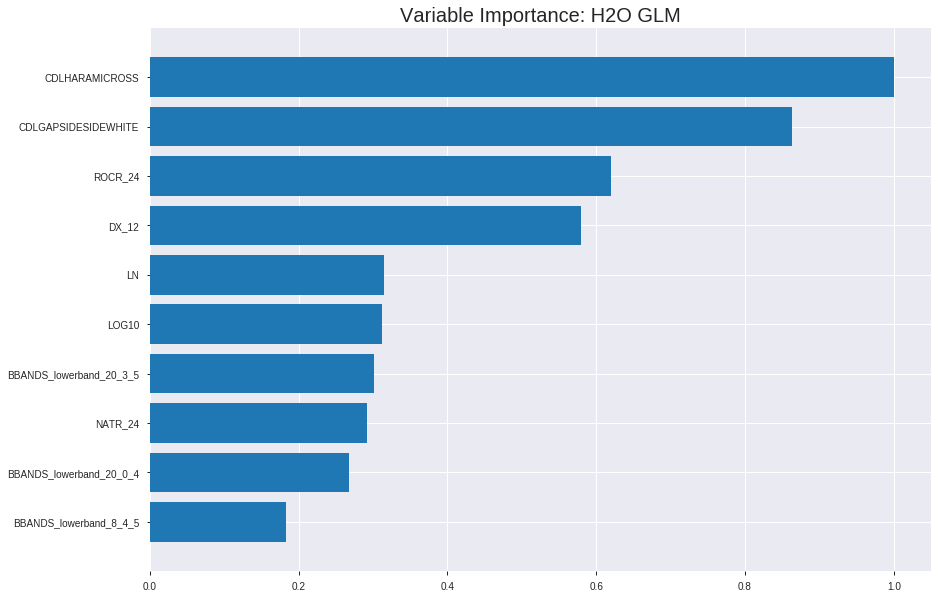

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_135122_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24788534912253066
RMSE: 0.49788085836124557
LogLoss: 0.6888587956678192
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2426.6126264514623
Residual deviance: 2415.138937611374
AIC: 2517.138937611374
AUC: 0.5434183479154602
pr_auc: 0.57158442490716
Gini: 0.08683669583092035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35848406313849845: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    836   0.9988   (836.0/837.0)
1      0    916   0        (0.0/916.0)
Total  1    1752  0.4769   (836.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.358484     0.686657   398
max f2                       0.358484     0.845643   398
max f0point5                 0.473448     0.581773   359
max accuracy                 0.512443     0.542499   247
max precision                0.752576     1          0
max recall                   0.358484     1          398
max specificity              0.752576     1          0
max absolute_mcc             0.551574     0.0879874  89
max min_per_class_accuracy   0.521425     0.520742   206
max mean_per_class_accuracy  0.527811     0.536245   179

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.610309           1.70112   1.70112            0.888889         0.661141  0.888889                    0.661141            0.0174672       0.0174672                  70.1116    70.1116
    2        0.0205362                   0.580509           0.956878  1.329              0.5              0.588947  0.694444                    0.625044            0.00982533      0.0272926                  -4.31223   32.8997
    3        0.0302339                   0.576564           1.35089   1.33602            0.705882         0.57906   0.698113                    0.610295            0.0131004       0.040393                   35.0886    33.6018
    4        0.040502                    0.571295           1.38216   1.34772            0.722222         0.573805  0.704225                    0.601044            0.0141921       0.0545852                  38.2157    34.7715
    5        0.0501997                   0.568319           0.900591  1.26134            0.470588         0.569721  0.659091                    0.594993            0.00873362      0.0633188                  -9.94092   26.1339
    6        0.100399                    0.554326           1.17435   1.21784            0.613636         0.560123  0.636364                    0.577558            0.058952        0.122271                   17.435     21.7844
    7        0.150029                    0.546736           1.05587   1.16426            0.551724         0.550194  0.608365                    0.568506            0.0524017       0.174672                   5.58651    16.4262
    8        0.200228                    0.541463           1.06561   1.13953            0.556818         0.543841  0.595442                    0.562322            0.0534934       0.228166                   6.56138    13.953
    9        0.300057                    0.533679           0.973281  1.08422            0.508571         0.537417  0.56654                     0.554036            0.0971616       0.325328                   -2.67187   8.42189
    10       0.399886                    0.527603           1.09357   1.08655            0.571429         0.530954  0.56776                     0.548274            0.10917         0.434498                   9.35745    8.65545
    11       0.500285                    0.521204           0.869889  1.04307            0.454545         0.524243  0.54504                     0.543451            0.0873362       0.521834                   -13.0111   4.30731
    12       0.600114                    0.515534           1.09357   1.05147            0.571429         0.518239  0.54943                     0.539257            0.10917         0.631004                   9.35745    5.1474
    13       0.699943                    0.510623           0.918603  1.03252            0.48             0.513208  0.539527                    0.535542            0.0917031       0.722707                   -8.13974   3.25233
    14       0.799772                    0.503596           0.984217  1.02649            0.514286         0.507088  0.536377                    0.53199             0.0982533       0.820961                   -1.57829   2.64937
    15       0.899601                    0.490681           0.787374  0.999958           0.411429         0.498676  0.522511                    0.528293            0.0786026       0.899563                   -21.2626   -0.00415359
    16       1                           0.300761           1.00037   1                  0.522727         0.470883  0.522533                  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24878955567796177
RMSE: 0.49878808694470816
LogLoss: 0.6907197403209432
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 693.1168027311257
Residual deviance: 692.1011798015851
AIC: 794.1011798015851
AUC: 0.5401483186293312
pr_auc: 0.5687121554562443
Gini: 0.08029663725866243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.465022924193511: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    231  0.9747   (231.0/237.0)
1      2    262  0.0076   (2.0/264.0)
Total  8    493  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465023     0.692206  391
max f2                       0.386283     0.847784  399
max f0point5                 0.468352     0.587294  379
max accuracy                 0.509986     0.550898  132
max precision                0.63204      1         0
max recall                   0.386283     1         399
max specificity              0.63204      1         0
max absolute_mcc             0.509986     0.1316    132
max min_per_class_accuracy   0.501753     0.540084  208
max mean_per_class_accuracy  0.509986     0.561133  132

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.59719            1.26515   1.26515            0.666667         0.620227  0.666667                    0.620227            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.547517           0.759091  1.03512            0.4              0.559542  0.545455                    0.592643            0.00757576      0.0227273                  -24.0909  3.5124
    3        0.0319361                   0.540604           0.759091  0.948864           0.4              0.542536  0.5                         0.576985            0.00757576      0.030303                   -24.0909  -5.11364
    4        0.0419162                   0.537701           1.51818   1.08442            0.8              0.538671  0.571429                    0.567862            0.0151515       0.0454545                  51.8182   8.44156
    5        0.0518962                   0.536314           1.51818   1.16783            0.8              0.536944  0.615385                    0.561916            0.0151515       0.0606061                  51.8182   16.7832
    6        0.101796                    0.528558           1.13864   1.15352            0.6              0.531312  0.607843                    0.546914            0.0568182       0.117424                   13.8636   15.352
    7        0.151697                    0.520966           1.29045   1.19856            0.68             0.524787  0.631579                    0.539635            0.0643939       0.181818                   29.0455   19.8565
    8        0.201597                    0.516798           1.06273   1.16494            0.56             0.51863   0.613861                    0.534436            0.0530303       0.234848                   6.27273   16.4941
    9        0.301397                    0.510729           1.17659   1.1688             0.62             0.513562  0.615894                    0.527524            0.117424        0.352273                   17.6591   16.8799
    10       0.401198                    0.506498           0.872955  1.09521            0.46             0.508381  0.577114                    0.522762            0.0871212       0.439394                   -12.7045  9.52058
    11       0.500998                    0.501762           0.986818  1.07361            0.52             0.503665  0.565737                    0.518958            0.0984848       0.537879                   -1.31818  7.36146
    12       0.600798                    0.497958           0.683182  1.00876            0.36             0.499698  0.531561                    0.515759            0.0681818       0.606061                   -31.6818  0.875868
    13       0.700599                    0.495025           1.02477   1.01104            0.54             0.496532  0.532764                    0.51302             0.102273        0.708333                   2.47727   1.10399
    14       0.800399                    0.489276           0.910909  0.998555           0.48             0.492349  0.526185                    0.510442            0.0909091       0.799242                   -8.90909  -0.144525
    15       0.9002                      0.477774           0.948864  0.993046           0.5              0.485232  0.523282                    0.507647            0.094697        0.893939                   -5.11364  -0.695424
    16       1                           0.386283           1.06273   1                  0.56             0.463378  0.526946                    0.503229     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 13:51:22  0.000 sec   2            2.3       51            1.38165           1.3828
    2019-08-27 13:51:22  0.008 sec   3            1.4       51            1.38114           1.38259
    2019-08-27 13:51:22  0.020 sec   4            0.88      51            1.38051           1.38228
    2019-08-27 13:51:22  0.041 sec   6            0.54      51            1.3798            1.38193
    2019-08-27 13:51:22  0.062 sec   8            0.34      51            1.37906           1.38163
    2019-08-27 13:51:23  0.083 sec   10           0.21      51            1.37835           1.38145
    2019-08-27 13:51:23  0.094 sec   11           0.13      51            1.37772           1.38144
    2019-08-27 13:51:23  0.108 sec   12           0.081     51            1.37716           1.3816
    2019-08-27 13:51:23  0.119 sec   13           0.05      51            1.37664           1.38191
    2019-08-27 13:51:23  0.130 sec   14           0.031     51            1.37611           1.38235
    2019-08-27 13:51:23  0.142 sec   15           0.019     51            1.37556           1.38291
    2019-08-27 13:51:23  0.159 sec   16           0.012     51            1.37495           1.38355

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6894736842105263)

('auc', 0.4875859434682964)

('logloss', 0.6983058643584432)

('mean_per_class_error', 0.47434428316781263)

('rmse', 0.5025460803774406)

('mse', 0.252552562902729)

glm prediction progress: |████████████████████████████████████████████████| 100%


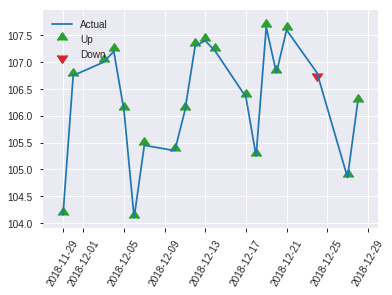


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.252552562902729
RMSE: 0.5025460803774406
LogLoss: 0.6983058643584432
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 347.29766117999407
Residual deviance: 350.54954390793847
AIC: 452.54954390793847
AUC: 0.4875859434682964
pr_auc: 0.4952671014431624
Gini: -0.024828113063407153
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39559224881779037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    117  0.9832   (117.0/119.0)
1      1    131  0.0076   (1.0/132.0)
Total  3    248  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.395592     0.689474  247
max f2                       0.378095     0.84724   250
max f0point5                 0.395592     0.58274   247
max accuracy                 0.488318     0.537849  199
max precision                0.496025     0.551181  126
max recall                   0.378095     1         250
max specificity              0.591026     0.991597  0
max absolute_mcc             0.525214     0.150152  4
max min_per_class_accuracy   0.496028     0.521008  125
max mean_per_class_accuracy  0.496025     0.525656  126

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.584              0         0                  0                0.589929  0                           0.589929            0               0                          -100      -100
    2        0.0239044                   0.524675           0.633838  0.316919           0.333333         0.543256  0.166667                    0.566592            0.00757576      0.00757576                 -36.6162  -68.3081
    3        0.0318725                   0.522386           0.950758  0.475379           0.5              0.522462  0.25                        0.55556             0.00757576      0.0151515                  -4.92424  -52.4621
    4        0.0438247                   0.520906           1.26768   0.69146            0.666667         0.52176   0.363636                    0.546341            0.0151515       0.030303                   26.7677   -30.854
    5        0.0517928                   0.519541           0.950758  0.731352           0.5              0.520162  0.384615                    0.542314            0.00757576      0.0378788                  -4.92424  -26.8648
    6        0.103586                    0.511938           0.877622  0.804487           0.461538         0.515929  0.423077                    0.529121            0.0454545       0.0833333                  -12.2378  -19.5513
    7        0.151394                    0.509105           0.633838  0.750598           0.333333         0.510487  0.394737                    0.523237            0.030303        0.113636                   -36.6162  -24.9402
    8        0.203187                    0.505736           1.02389   0.820261           0.538462         0.507252  0.431373                    0.519162            0.0530303       0.166667                   2.38928   -17.9739
    9        0.302789                    0.502324           1.21697   0.950758           0.64             0.503888  0.5                         0.514138            0.121212        0.287879                   21.697    -4.92424
    10       0.40239                     0.498697           1.29303   1.03548            0.68             0.500326  0.544554                    0.510719            0.128788        0.416667                   29.303    3.54785
    11       0.501992                    0.496028           1.06485   1.04131            0.56             0.497124  0.547619                    0.508022            0.106061        0.522727                   6.48485   4.13059
    12       0.601594                    0.494087           0.684545  0.98224            0.36             0.495213  0.516556                    0.505901            0.0681818       0.590909                   -31.5455  -1.77604
    13       0.701195                    0.492262           1.21697   1.01558            0.64             0.493028  0.534091                    0.504072            0.121212        0.712121                   21.697    1.5582
    14       0.800797                    0.488138           1.06485   1.02171            0.56             0.490406  0.537313                    0.502373            0.106061        0.818182                   6.48485   2.17096
    15       0.900398                    0.478288           0.760606  0.992826           0.4              0.483456  0.522124                    0.50028             0.0757576       0.893939                   -23.9394  -0.71735
    16       1                           0.378095           1.06485   1                  0.56             0.454542  0.525896                    0.495724    

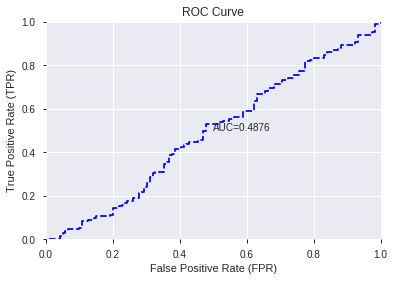

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


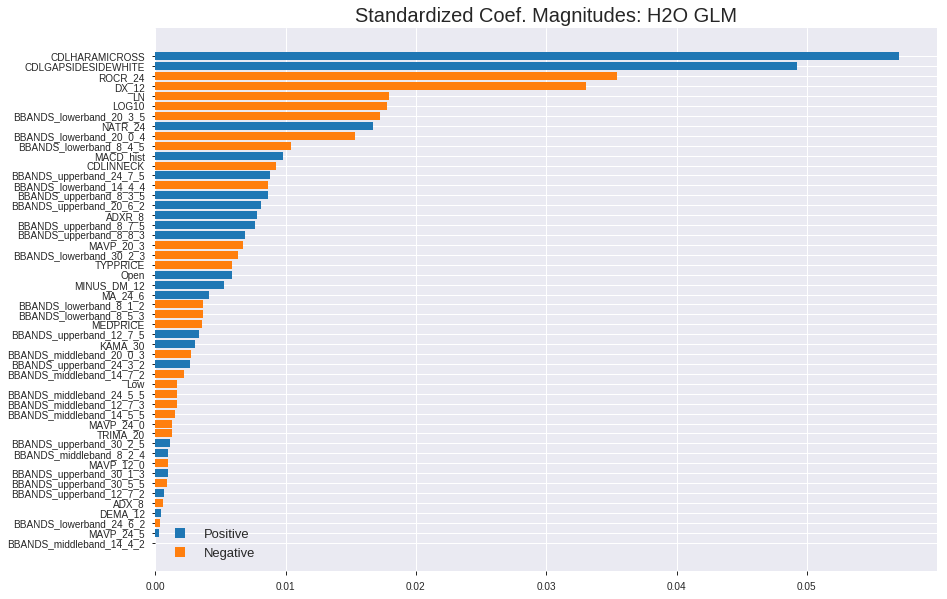

'log_likelihood'
--2019-08-27 13:51:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_135122_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_135122_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLHARAMICROSS',
 'CDLGAPSIDESIDEWHITE',
 'ROCR_24',
 'DX_12',
 'LN',
 'LOG10',
 'BBANDS_lowerband_20_3_5',
 'NATR_24',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_8_4_5',
 'MACD_hist',
 'CDLINNECK',
 'BBANDS_upperband_24_7_5',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_upperband_20_6_2',
 'ADXR_8',
 'BBANDS_upperband_8_7_5',
 'BBANDS_upperband_8_8_3',
 'MAVP_20_3',
 'BBANDS_lowerband_30_2_3',
 'TYPPRICE',
 'Open',
 'MINUS_DM_12',
 'MA_24_6',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_lowerband_8_5_3',
 'MEDPRICE',
 'BBANDS_upperband_12_7_5',
 'KAMA_30',
 'BBANDS_middleband_20_0_3',
 'BBANDS_upperband_24_3_2',
 'BBANDS_middleband_14_7_2',
 'Low',
 'BBANDS_middleband_24_5_5',
 'BBANDS_middleband_12_7_3',
 'BBANDS_middleband_14_5_5',
 'MAVP_24_0',
 'TRIMA_20',
 'BBANDS_upperband_30_2_5',
 'BBANDS_middleband_8_2_4',
 'MAVP_12_0',
 'BBANDS_upperband_30_1_3',
 'BBANDS_upperband_30_5_5',
 'BBANDS_upperband_12_7_2',
 'ADX_8',
 'DEMA_12',
 'BBANDS_lowerband_24_6_2',
 'MAVP_2

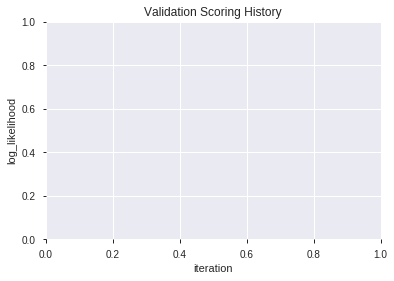

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_135135_model_4  0.564649  0.687234              0.495798  0.497055  0.247064
1  XGBoost_grid_1_AutoML_20190827_135135_model_1  0.556118  0.687684              0.486154  0.497268  0.247276
2  XGBoost_grid_1_AutoML_20190827_135135_model_7  0.554049  0.698880              0.482366  0.502225  0.252230
3               XGBoost_1_AutoML_20190827_135135  0.553731  0.709180              0.477336  0.507018  0.257067
4               XGBoost_2_AutoML_20190827_135135  0.538897  0.705133              0.481952  0.505583  0.255614
5  XGBoost_grid_1_AutoML_20190827_135135_model_5  0.533550  0.721526              0.491597  0.512638  0.262798
6  XGBoost_grid_1_AutoML_20190827_135135_model_2  0.533359  0.690525              0.500000  0.498693  0.248695
7  XGBoost_grid_1_AutoML_20190827_135135_model_6  0.526547  0.703675              0.474376  0.504912  0.254936
8               XGBoost_3_AutoML_20190827_135135  0.519321  0.696731              0.482779  0.501705  0.251708
9  XGBoost_grid_1_AutoML_20190827_135135_model_3  0.484371  0.712239              0.486981  0.508917  0.258996

variable  relative_importance  scaled_importance  percentage
0                  MACD_hist           301.897583           1.000000    0.147096
1                      DX_12           182.565552           0.604727    0.088953
2                    ROCR_24           173.103088           0.573383    0.084342
3                      ADX_8           157.706299           0.522383    0.076841
4                     ADXR_8           156.075562           0.516982    0.076046
5                MINUS_DM_12           137.298172           0.454784    0.066897
6                    NATR_24           105.413490           0.349170    0.051361
7    BBANDS_upperband_30_2_5            84.585648           0.280180    0.041213
8    BBANDS_upperband_24_7_5            74.470573           0.246675    0.036285
9    BBANDS_upperband_12_7_5            65.636993           0.217415    0.031981
10    BBANDS_lowerband_8_4_5            61.120041           0.202453    0.029780
11   BBANDS_lowerband_24_6_2            50.078934           0.165881    0.024400
12   BBANDS_lowerband_14_4_4            45.375809           0.150302    0.022109
13   BBANDS_lowerband_20_0_4            41.802238           0.138465    0.020368
14    BBANDS_upperband_8_3_5            37.147770           0.123048    0.018100
15   BBANDS_lowerband_20_3_5            35.220200           0.116663    0.017161
16   BBANDS_upperband_30_5_5            32.447319           0.107478    0.015810
17   BBANDS_lowerband_30_2_3            31.687212           0.104960    0.015439
18                        LN            31.036980           0.102806    0.015122
19   BBANDS_upperband_30_1_3            25.337652           0.083928    0.012345
20                 MAVP_20_3            25.248550           0.083633    0.012302
21   BBANDS_upperband_20_6_2            24.560614           0.081354    0.011967
22                      Open            23.613701           0.078218    0.011505
23    BBANDS_upperband_8_7_5            20.309996           0.067274    0.009896
24  BBANDS_middleband_12_7_3            14.643946           0.048506    0.007135
25  BBANDS_middleband_14_5_5            14.164571           0.046918    0.006902
26                       Low            12.989798           0.043027    0.006329
27   BBANDS_upperband_24_3_2            12.401467           0.041078    0.006042
28    BBANDS_lowerband_8_5_3            10.798357           0.035768    0.005261
29                  TRIMA_20            10.259775           0.033984    0.004999
30   BBANDS_upperband_12_7_2             7.482402           0.024785    0.003646
31                  TYPPRICE             7.157703           0.023709    0.003488
32                  MEDPRICE             6.991628           0.023159    0.003407
33                   MA_24_6             6.774748           0.022441    0.003301
34    BBANDS_lowerband_8_1_2             6.634328           0.021975    0.003232
35  BBANDS_middleband_24_5_5             6.239518           0.020668    0.003040
36                 MAVP_12_0             5.971739           0.019781    0.002910
37                   DEMA_12             4.163189           0.013790    0.002028
38    BBANDS_upperband_8_8_3             1.971753           0.006531    0.000961

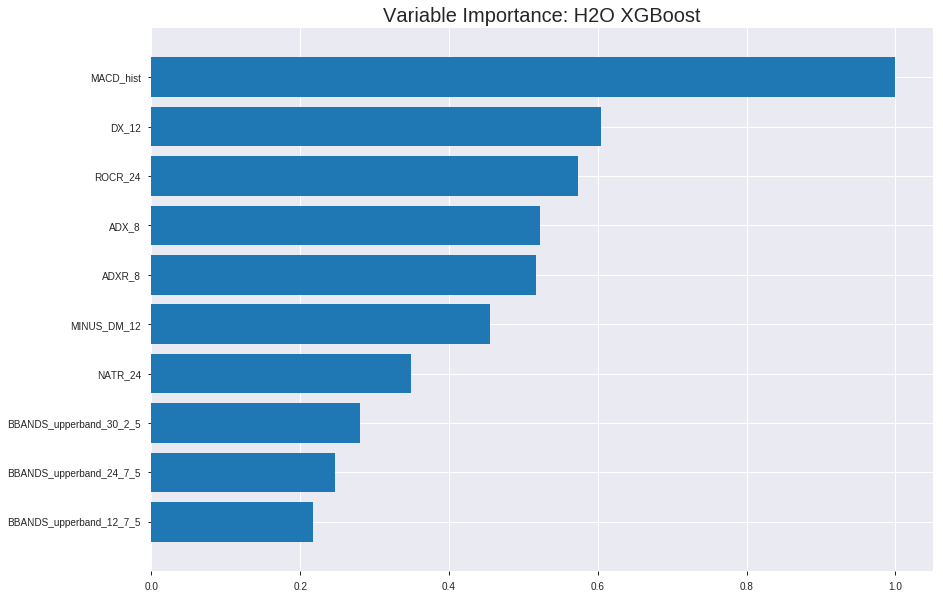

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_135135_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22819151276424315
RMSE: 0.47769395303294676
LogLoss: 0.6489274312029158
Mean Per-Class Error: 0.3234695288329603
AUC: 0.7263373036369233
pr_auc: 0.7356248725467455
Gini: 0.45267460727384656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4505987564722697: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      229  608   0.7264   (608.0/837.0)
1      63   853   0.0688   (63.0/916.0)
Total  292  1461  0.3828   (671.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450599     0.717711  307
max f2                       0.404649     0.849356  366
max f0point5                 0.523836     0.693662  191
max accuracy                 0.51308      0.676554  209
max precision                0.688472     1         0
max recall                   0.385313     1         385
max specificity              0.688472     1         0
max absolute_mcc             0.52311      0.352902  192
max min_per_class_accuracy   0.519195     0.671397  199
max mean_per_class_accuracy  0.52311      0.67653   192

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.656067           1.70112   1.70112            0.888889         0.674389  0.888889                    0.674389            0.0174672       0.0174672                  70.1116   70.1116
    2        0.0205362                   0.646683           1.91376   1.80744            1                0.650705  0.944444                    0.662547            0.0196507       0.0371179                  91.3755   80.7436
    3        0.0302339                   0.639164           1.68861   1.76932            0.882353         0.642953  0.924528                    0.656262            0.0163755       0.0534934                  68.8608   76.9321
    4        0.040502                    0.635598           1.48848   1.69812            0.777778         0.637345  0.887324                    0.651466            0.0152838       0.0687773                  48.8476   69.8121
    5        0.0501997                   0.628689           1.57603   1.67454            0.823529         0.632228  0.875                       0.64775             0.0152838       0.0840611                  57.6034   67.4536
    6        0.100399                    0.607066           1.5658    1.62017            0.818182         0.615357  0.846591                    0.631554            0.0786026       0.162664                   56.58     62.0168
    7        0.150029                    0.589986           1.38582   1.54265            0.724138         0.597309  0.806084                    0.620226            0.0687773       0.231441                   38.5823   54.2647
    8        0.200228                    0.578297           1.34833   1.49393            0.704545         0.583951  0.780627                    0.611131            0.0676856       0.299127                   34.8328   49.3929
    9        0.300057                    0.558671           1.33416   1.44077            0.697143         0.568379  0.752852                    0.596908            0.133188        0.432314                   33.4161   44.0774
    10       0.399886                    0.539451           1.20293   1.3814             0.628571         0.548799  0.721826                    0.584898            0.120087        0.552402                   20.2932   38.1398
    11       0.500285                    0.520049           1.13086   1.33112            0.590909         0.529868  0.695553                    0.573854            0.113537        0.665939                   13.0855   33.1118
    12       0.600114                    0.501777           0.885795  1.25704            0.462857         0.511104  0.656844                    0.563416            0.0884279       0.754367                   -11.4205  25.7039
    13       0.699943                    0.48298            0.743631  1.18381            0.388571         0.492651  0.618582                    0.553323            0.0742358       0.828603                   -25.6369  18.3815
    14       0.799772                    0.460315           0.754566  1.13024            0.394286         0.472123  0.590585                    0.543187            0.0753275       0.90393                    -24.5434  13.0235
    15       0.899601                    0.435119           0.568659  1.06792            0.297143         0.446842  0.558022                    0.532496            0.0567686       0.960699                   -43.1341  6.79168
    16       1                           0.342861           0.39145   1                  0.204545         0.411491  0.522533                    0.520347         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25196127727338513
RMSE: 0.5019574456797958
LogLoss: 0.6971625526535734
Mean Per-Class Error: 0.47986191024165703
AUC: 0.49530910369517966
pr_auc: 0.5144047479094656
Gini: -0.009381792609640671
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3926870822906494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.392687     0.690196   399
max f2                       0.392687     0.847784   399
max f0point5                 0.439813     0.585793   375
max accuracy                 0.463617     0.538922   346
max precision                0.645536     0.666667   2
max recall                   0.392687     1          399
max specificity              0.661132     0.995781   0
max absolute_mcc             0.553651     0.0669075  86
max min_per_class_accuracy   0.517226     0.493671   207
max mean_per_class_accuracy  0.488238     0.520138   289

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 51.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.640334           0.632576  0.632576           0.333333         0.646942  0.333333                    0.646942            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.626383           1.51818   1.03512            0.8              0.631908  0.545455                    0.640108            0.0151515       0.0227273                  51.8182   3.5124
    3        0.0319361                   0.611932           0.379545  0.830256           0.2              0.614318  0.4375                      0.632049            0.00378788      0.0265152                  -62.0455  -16.9744
    4        0.0419162                   0.603303           0.759091  0.813312           0.4              0.607588  0.428571                    0.626225            0.00757576      0.0340909                  -24.0909  -18.6688
    5        0.0518962                   0.599962           1.13864   0.875874           0.6              0.601506  0.461538                    0.621471            0.0113636       0.0454545                  13.8636   -12.4126
    6        0.101796                    0.579125           0.910909  0.893048           0.48             0.589317  0.470588                    0.605709            0.0454545       0.0909091                  -8.90909  -10.6952
    7        0.151697                    0.564106           0.986818  0.923894           0.52             0.570824  0.486842                    0.594234            0.0492424       0.140152                   -1.31818  -7.61065
    8        0.201597                    0.552317           0.835     0.90189            0.44             0.557243  0.475248                    0.585078            0.0416667       0.181818                   -16.5     -9.81098
    9        0.301397                    0.5381             1.02477   0.94258            0.54             0.544347  0.496689                    0.571591            0.102273        0.284091                   2.47727   -5.74202
    10       0.401198                    0.527301           1.13864   0.99135            0.6              0.532452  0.522388                    0.561855            0.113636        0.397727                   13.8636   -0.864993
    11       0.500998                    0.517226           0.986818  0.990447           0.52             0.523916  0.521912                    0.554297            0.0984848       0.496212                   -1.31818  -0.95527
    12       0.600798                    0.503592           0.986818  0.989844           0.52             0.510134  0.521595                    0.546961            0.0984848       0.594697                   -1.31818  -1.01555
    13       0.700599                    0.492206           1.21455   1.02185            0.64             0.497819  0.538462                    0.539961            0.121212        0.715909                   21.4545   2.18531
    14       0.800399                    0.479886           0.986818  1.01748            0.52             0.486173  0.53616                     0.533254            0.0984848       0.814394                   -1.31818  1.74847
    15       0.9002                      0.458351           0.948864  1.00988            0.5              0.469532  0.532151                    0.52619             0.094697        0.909091                   -5.11364  0.987704
    16       1                           0.392687           0.910909  1                  0.48             0.436758  0.526946                    0.517


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:51:42  2.292 sec   0                  0.5              0.693147            0.5             0                  1                0.477467                         0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 13:51:42  2.396 sec   5                  0.496373         0.685913            0.634753        0.622164           1.2065           0.444381                         0.500568           0.694285              0.446234          0.481929             0.79072            0.469062
    2019-08-27 13:51:42  2.454 sec   10                 0.493217         0.679642            0.657283        0.652065           1.30941          0.411865                         0.500583           0.694315              0.471711          0.502734             0.632576           0.469062
    2019-08-27 13:51:42  2.505 sec   15                 0.490575         0.674405            0.677811        0.676158           1.5948           0.3919                           0.500066           0.693281              0.501478          0.517529             0.948864           0.471058
    2019-08-27 13:51:42  2.559 sec   20                 0.488433         0.670153            0.681754        0.683846           1.5948           0.375927                         0.500164           0.69348               0.495533          0.521484             1.58144            0.473054
    2019-08-27 13:51:42  2.616 sec   25                 0.48665          0.666621            0.689292        0.693695           1.5948           0.413006                         0.500048           0.693258              0.506865          0.52148              0.948864           0.473054
    2019-08-27 13:51:42  2.670 sec   30                 0.484778         0.662923            0.698104        0.703049           1.70112          0.414718                         0.499982           0.693132              0.510972          0.524612             1.26515            0.473054
    2019-08-27 13:51:42  2.730 sec   35                 0.48281          0.659022            0.70505         0.712941           1.70112          0.395893                         0.500367           0.693916              0.505314          0.518113             1.26515            0.467066
    2019-08-27 13:51:42  2.788 sec   40                 0.480734         0.65492             0.713913        0.724541           1.80744          0.369082                         0.501466           0.696163              0.496132          0.510609             0.632576           0.471058
    2019-08-27 13:51:42  2.849 sec   45                 0.479026         0.651565            0.723395        0.732527           1.70112          0.373645                         0.501892           0.697013              0.487733          0.509553             0.948864           0.46507
    2019-08-27 13:51:43  2.913 sec   50                 0.477694         0.648927            0.726337        0.735625           1.70112          0.382772                         0.501957           0.697163              0.495309          0.514405             0.632576           0.473054

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
MACD_hist                 301.8975830078125      1.0                   0.14709598735218699
DX_12                     182.5655517578125      0.6047267750172352    0.08895288204946404
ROCR_24                   173.10308837890625     0.5733834854001686    0.0843424099163761
ADX_8                     157.706298828125       0.5223834429441055    0.07684050831629805
ADXR_8                    156.0755615234375      0.5169818186964371    0.07604595106428175
---                       ---                    ---                   ---
BBANDS_lowerband_8_1_2    6.6343278884887695     0.021975425647303332  0.0032324969330746562
BBANDS_middleband_24_5_5  6.239518165588379      0.020667665184410943  0.0030401306165653472
MAVP_12_0                 5.971739292144775      0.019780679370295717  0.002909658562470685
DEMA_12                   4.163188934326172      0.013790070436630282  0.0020284640265323356
BBANDS_upperband_8_8_3    1.971753478050232      0.006531199946702478  0.000960713304754752


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6910994764397906)

('auc', 0.5646485867074101)

('logloss', 0.6872341453677729)

('mean_per_class_error', 0.42592946269416854)

('rmse', 0.4970550438176007)

('mse', 0.24706371658451692)

xgboost prediction progress: |████████████████████████████████████████████| 100%


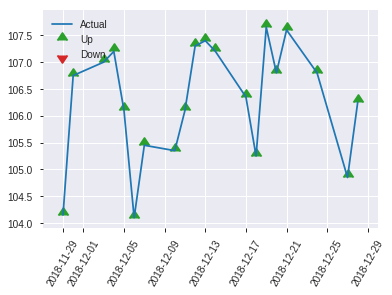


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24706371658451692
RMSE: 0.4970550438176007
LogLoss: 0.6872341453677729
Mean Per-Class Error: 0.42592946269416854
AUC: 0.5646485867074101
pr_auc: 0.5993433131177753
Gini: 0.12929717341482028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40231603384017944: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    118  0.9916   (118.0/119.0)
1      0    132  0        (0.0/132.0)
Total  1    250  0.4701   (118.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402316     0.691099  247
max f2                       0.402316     0.848329  247
max f0point5                 0.491413     0.601852  154
max accuracy                 0.495287     0.577689  142
max precision                0.616751     1         0
max recall                   0.402316     1         247
max specificity              0.616751     1         0
max absolute_mcc             0.587922     0.172277  7
max min_per_class_accuracy   0.502175     0.537879  121
max mean_per_class_accuracy  0.495287     0.574071  142

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.598195           1.90152   1.90152            1                0.609876  1                           0.609876            0.0227273       0.0227273                  90.1515   90.1515
    2        0.0239044                   0.593991           1.90152   1.90152            1                0.594895  1                           0.602386            0.0227273       0.0454545                  90.1515   90.1515
    3        0.0318725                   0.587702           1.90152   1.90152            1                0.58999   1                           0.599287            0.0151515       0.0606061                  90.1515   90.1515
    4        0.0438247                   0.583098           0         1.38292            0                0.585761  0.727273                    0.595598            0               0.0606061                  -100      38.292
    5        0.0517928                   0.579918           0.950758  1.31643            0.5              0.58017   0.692308                    0.593224            0.00757576      0.0681818                  -4.92424  31.6434
    6        0.103586                    0.562869           1.31643   1.31643            0.692308         0.570447  0.692308                    0.581836            0.0681818       0.136364                   31.6434   31.6434
    7        0.151394                    0.550299           0.792298  1.15092            0.416667         0.556509  0.605263                    0.573838            0.0378788       0.174242                   -20.7702  15.0917
    8        0.203187                    0.540035           1.02389   1.11854            0.538462         0.544374  0.588235                    0.566327            0.0530303       0.227273                   2.38928   11.8538
    9        0.302789                    0.523832           1.21697   1.15092            0.64             0.530932  0.605263                    0.554684            0.121212        0.348485                   21.697    15.0917
    10       0.40239                     0.51021            0.988788  1.11079            0.52             0.516672  0.584158                    0.545275            0.0984848       0.44697                    -1.12121  11.0786
    11       0.501992                    0.500854           0.912727  1.07149            0.48             0.505346  0.563492                    0.537353            0.0909091       0.537879                   -8.72727  7.14887
    12       0.601594                    0.492826           1.21697   1.09557            0.64             0.496994  0.576159                    0.530671            0.121212        0.659091                   21.697    9.5575
    13       0.701195                    0.482312           0.608485  1.02639            0.32             0.488377  0.539773                    0.524663            0.0606061       0.719697                   -39.1515  2.6386
    14       0.800797                    0.463104           0.760606  0.993329           0.4              0.473044  0.522388                    0.518243            0.0757576       0.795455                   -23.9394  -0.667119
    15       0.900398                    0.448604           1.14091   1.00965            0.6              0.454961  0.530973                    0.511243            0.113636        0.909091                   14.0909   0.965406
    16       1                           0.396213           0.912727  1                  0.48             0.428691  0.525896                    0.50302          

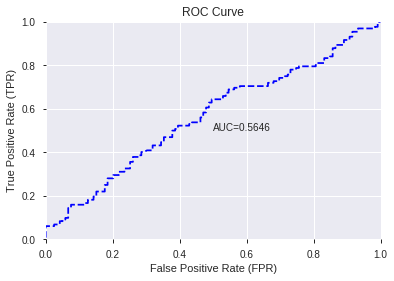

This function is available for GLM models only


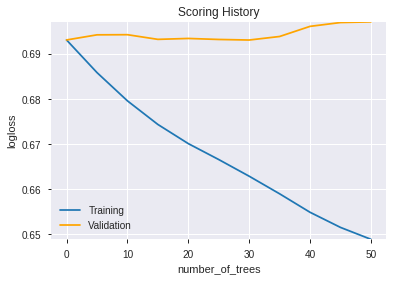

--2019-08-27 13:51:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_135135_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_135135_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MACD_hist',
 'DX_12',
 'ROCR_24',
 'ADX_8',
 'ADXR_8',
 'MINUS_DM_12',
 'NATR_24',
 'BBANDS_upperband_30_2_5',
 'BBANDS_upperband_24_7_5',
 'BBANDS_upperband_12_7_5',
 'BBANDS_lowerband_8_4_5',
 'BBANDS_lowerband_24_6_2',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_upperband_30_5_5',
 'BBANDS_lowerband_30_2_3',
 'LN',
 'BBANDS_upperband_30_1_3',
 'MAVP_20_3',
 'BBANDS_upperband_20_6_2',
 'Open',
 'BBANDS_upperband_8_7_5',
 'BBANDS_middleband_12_7_3',
 'BBANDS_middleband_14_5_5',
 'Low',
 'BBANDS_upperband_24_3_2',
 'BBANDS_lowerband_8_5_3',
 'TRIMA_20',
 'BBANDS_upperband_12_7_2',
 'TYPPRICE',
 'MEDPRICE',
 'MA_24_6',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_middleband_24_5_5',
 'MAVP_12_0',
 'DEMA_12',
 'BBANDS_upperband_8_8_3']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190827_135159  0.517284  0.793395                   0.5  0.544217  0.296172
1  DeepLearning_grid_1_AutoML_20190827_135159_model_9  0.506207  0.691608                   0.5  0.499231  0.249231
2  DeepLearning_grid_1_AutoML_20190827_135159_model_5  0.502451  0.691380                   0.5  0.499119  0.249120
3  DeepLearning_grid_1_AutoML_20190827_135159_model_8  0.500000  0.691842                   0.5  0.499347  0.249348
4  DeepLearning_grid_1_AutoML_20190827_135159_model_6  0.500000  0.691876                   0.5  0.499364  0.249364
5  DeepLearning_grid_1_AutoML_20190827_135159_model_4  0.498981  0.928683                   0.5  0.555801  0.308915
6  DeepLearning_grid_1_AutoML_20190827_135159_model_1  0.495671  1.716538                   0.5  0.623162  0.388331
7  DeepLearning_grid_1_AutoML_20190827_135159_model_2  0.494589  0.753294                   0.5  0.525947  0.276621
8  DeepLearning_grid_1_AutoML_20190827_135159_model_7  0.485676  0.701124                   0.5  0.503884  0.253899
9  DeepLearning_grid_1_AutoML_20190827_135159_model_3  0.474153  0.787410                   0.5  0.535177  0.286414

variable  relative_importance  scaled_importance  percentage
0                   dayofyear             1.000000           1.000000    0.001757
1                aroondown_12             0.971605           0.971605    0.001707
2                CDLENGULFING             0.868957           0.868957    0.001527
3      BBANDS_upperband_8_3_5             0.861607           0.861607    0.001514
4     BBANDS_lowerband_14_4_4             0.857963           0.857963    0.001508
...                       ...                  ...                ...         ...
1037  BBANDS_lowerband_20_2_2             0.280292           0.280292    0.000492
1038                   MIN_30             0.271513           0.271513    0.000477
1039  BBANDS_middleband_8_8_5             0.259213           0.259213    0.000455
1040               PLUS_DI_20             0.255498           0.255498    0.000449
1041              STOCH_slowk             0.230055           0.230055    0.000404

[1042 rows x 4 columns]

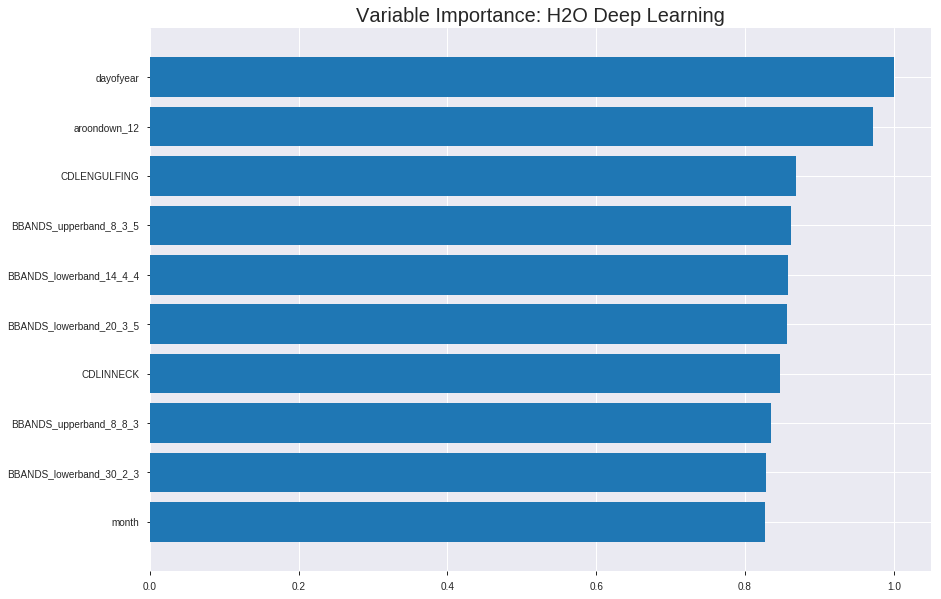

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190827_135159


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2483056636024677
RMSE: 0.4983027830571165
LogLoss: 0.6861956024049134
Mean Per-Class Error: 0.4279456417961842
AUC: 0.6022346652893208
pr_auc: 0.6531510567729898
Gini: 0.20446933057864158
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28052495227825913: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      85   752   0.8984   (752.0/837.0)
1      21   895   0.0229   (21.0/916.0)
Total  106  1647  0.441    (773.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280525     0.6984    322
max f2                       0.150055     0.850391  365
max f0point5                 0.280525     0.596349  322
max accuracy                 0.511198     0.571021  169
max precision                0.999965     1         0
max recall                   0.0575816    1         388
max specificity              0.999965     1         0
max absolute_mcc             0.777507     0.180555  76
max min_per_class_accuracy   0.487884     0.563919  186
max mean_per_class_accuracy  0.511198     0.572054  169

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 44.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.979114           1.91376   1.91376            1                0.989991  1                           0.989991            0.0196507       0.0196507                  91.3755   91.3755
    2        0.0205362                   0.947892           1.91376   1.91376            1                0.968471  1                           0.979231            0.0196507       0.0393013                  91.3755   91.3755
    3        0.0302339                   0.919278           1.80118   1.87765            0.941176         0.934222  0.981132                    0.964794            0.0174672       0.0567686                  80.1182   87.7647
    4        0.040502                    0.877503           1.5948    1.80594            0.833333         0.895321  0.943662                    0.947181            0.0163755       0.0731441                  59.4796   80.5938
    5        0.0501997                   0.831939           1.46346   1.73978            0.764706         0.855896  0.909091                    0.929547            0.0141921       0.0873362                  46.346    73.9778
    6        0.100399                    0.616403           1.10911   1.42444            0.579545         0.703349  0.744318                    0.816448            0.0556769       0.143013                   10.9108   42.4443
    7        0.476326                    0.516476           1.06287   1.13909            0.555387         0.520691  0.59521                     0.58303             0.399563        0.542576                   6.28748   13.9086
    8        0.500285                    0.489595           0.774615  1.12163            0.404762         0.503176  0.586089                    0.579206            0.018559        0.561135                   -22.5385  12.1631
    9        0.600114                    0.373934           0.907667  1.08604            0.474286         0.435916  0.56749                     0.55537             0.0906114       0.651747                   -9.23331  8.6038
    10       0.926982                    0.298601           0.951868  1.03873            0.497382         0.303968  0.542769                    0.466722            0.311135        0.962882                   -4.81321  3.87276
    11       1                           0.00567206         0.508341  1                  0.265625         0.192752  0.522533                    0.446717            0.0371179       1                          -49.1659  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29486211830229503
RMSE: 0.5430120793336876
LogLoss: 0.7897552958997023
Mean Per-Class Error: 0.47969409282700415
AUC: 0.5195547244597878
pr_auc: 0.574810231560257
Gini: 0.03910944891957557
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29860050859313564: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    236  0.9958   (236.0/237.0)
1      0    264  0        (0.0/264.0)
Total  1    500  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.298601     0.691099   54
max f2                       0.298601     0.848329   54
max f0point5                 0.298601     0.583039   54
max accuracy                 0.298601     0.528942   54
max precision                0.969506     1          0
max recall                   0.298601     1          54
max specificity              0.969506     1          0
max absolute_mcc             0.609154     0.0780493  9
max min_per_class_accuracy   0.306396     0.125      52
max mean_per_class_accuracy  0.306396     0.520306   52

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 31.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.703916           1.26515   1.26515            0.666667         0.84528   0.666667                    0.84528             0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.595354           1.51818   1.38017            0.8              0.629481  0.727273                    0.747189            0.0151515       0.030303                   51.8182   38.0165
    3        0.0319361                   0.530491           0.379545  1.06747            0.2              0.563259  0.5625                      0.689711            0.00378788      0.0340909                  -62.0455  6.74716
    4        0.0419162                   0.514604           1.13864   1.08442            0.6              0.522018  0.571429                    0.649784            0.0113636       0.0454545                  13.8636   8.44156
    5        0.0518962                   0.462816           1.51818   1.16783            0.8              0.490156  0.615385                    0.619086            0.0151515       0.0606061                  51.8182   16.7832
    6        0.101796                    0.309736           1.13864   1.15352            0.6              0.380495  0.607843                    0.50213             0.0568182       0.117424                   13.8636   15.352
    7        0.998004                    0.298601           0.984789  1.002              0.518931         0.298641  0.528                       0.319397            0.882576        1                          -1.52106  0.2
    8        1                           0.290445           0         1                  0                0.290445  0.526946                    0.319339            0               1                          -100      0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 13:52:00  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 13:52:00  0.386 sec   8347 obs/sec      1         1             1753       0.536491         0.839796            -0.153633      0.540172        0.553842           1.48848          0.46891                          0.571958           0.928878              -0.312356        0.473357          0.501461             1.26515            0.473054
    2019-08-27 13:52:01  1.693 sec   12539 obs/sec     10        10            17530      0.498303         0.686196            0.0047561      0.602235        0.653151           1.91376          0.440958                         0.543012           0.789755              -0.182884        0.519555          0.57481              1.26515            0.471058

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ----------------------
dayofyear                1.0                    1.0                  0.0017570707875784115
aroondown_12             0.9716050028800964     0.9716050028800964   0.0017071787676256557
CDLENGULFING             0.8689565658569336     0.8689565658569336   0.001526818197541674
BBANDS_upperband_8_3_5   0.8616066575050354     0.8616066575050354   0.001513903888285175
BBANDS_lowerband_14_4_4  0.8579626083374023     0.8579626083374023   0.0015075010359442277
---                      ---                    ---                  ---
BBANDS_lowerband_20_2_2  0.28029218316078186    0.28029218316078186  0.0004924932070183873
MIN_30                   0.27151256799697876    0.27151256799697876  0.00047706680168788844
BBANDS_middleband_8_8_5  0.25921252369880676    0.25921252369880676  0.00045545475316565
PLUS_DI_20               0.25549787282943726    0.25549787282943726  0.0004489278486370281
STOCH_slowk              0.23005543649196625    0.23005543649196625  0.00040422368698363436


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5258964143426295)

('F1', 0.6892950391644909)

('auc', 0.5172841864018335)

('logloss', 0.7933951142921037)

('mean_per_class_error', 0.4827158135981665)

('rmse', 0.544216513188068)

('mse', 0.29617161322657853)

deeplearning prediction progress: |███████████████████████████████████████| 100%


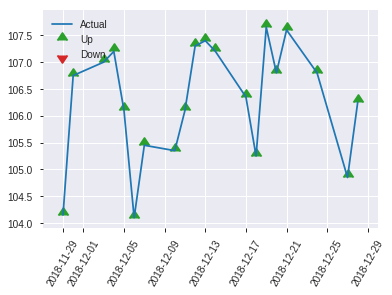


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.29617161322657853
RMSE: 0.544216513188068
LogLoss: 0.7933951142921037
Mean Per-Class Error: 0.4827158135981665
AUC: 0.5172841864018335
pr_auc: 0.613065826432813
Gini: 0.03456837280366698
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29860050859313564: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    132  0        (0.0/132.0)
Total  0    251  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.298601     0.689295   13
max f2                       0.298601     0.84724    13
max f0point5                 0.298601     0.580986   13
max accuracy                 0.298601     0.525896   13
max precision                0.650541     1          0
max recall                   0.298601     1          13
max specificity              0.650541     1          0
max absolute_mcc             0.584596     0.104429   2
max min_per_class_accuracy   0.316353     0.0681818  12
max mean_per_class_accuracy  0.316353     0.517284   12

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 30.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.57809            1.90152   1.90152            1                0.620019  1                           0.620019            0.0227273       0.0227273                  90.1515   90.1515
    2        0.0239044                   0.469048           0.633838  1.26768            0.333333         0.519124  0.666667                    0.569571            0.00757576      0.030303                   -36.6162  26.7677
    3        0.0318725                   0.417151           1.90152   1.42614            1                0.434679  0.75                        0.535848            0.0151515       0.0454545                  90.1515   42.6136
    4        0.0438247                   0.3684             0.633838  1.21006            0.333333         0.387218  0.636364                    0.495313            0.00757576      0.0530303                  -36.6162  21.0055
    5        0.0517928                   0.307477           1.90152   1.31643            1                0.325473  0.692308                    0.469183            0.0151515       0.0681818                  90.1515   31.6434
    6        1                           0.298601           0.982716  1                  0.516807         0.298601  0.525896                    0.307435            0.931818        1                          -1.72842  0

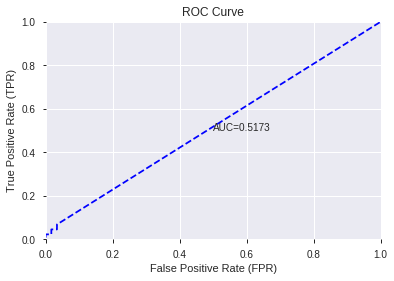

This function is available for GLM models only


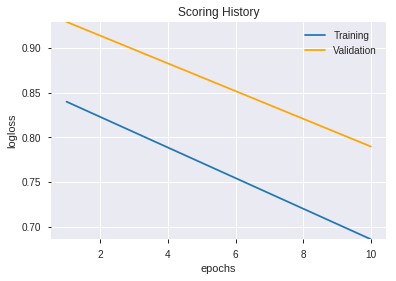

--2019-08-27 14:19:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190827_135159',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190827_135159',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b27e'

['dayofyear',
 'aroondown_12',
 'CDLENGULFING',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_lowerband_20_3_5',
 'CDLINNECK',
 'BBANDS_upperband_8_8_3',
 'BBANDS_lowerband_30_2_3',
 'month',
 'BBANDS_middleband_14_4_2',
 'HT_TRENDMODE',
 'LOG10',
 'BBANDS_lowerband_24_6_2',
 'LN',
 'Low',
 'CDLGAPSIDESIDEWHITE',
 'ROCR_24',
 'BBANDS_upperband_24_7_5',
 'aroonup_20',
 'CORREL_14',
 'MAVP_20_3',
 'BBANDS_lowerband_8_4_5',
 'BBANDS_middleband_14_5_5',
 'is_quarter_end',
 'BBANDS_middleband_8_2_4',
 'CDLHARAMICROSS',
 'MAVP_24_5',
 'BBANDS_lowerband_30_6_2',
 'BBANDS_upperband_12_7_2',
 'BBANDS_upperband_12_7_5',
 'KAMA_30',
 'MAVP_12_0',
 'CORREL_8',
 'TRIMA_20',
 'BBANDS_lowerband_24_1_2',
 'BBANDS_lowerband_30_1_2',
 'is_month_end',
 'HT_DCPERIOD',
 'BBANDS_middleband_20_0_3',
 'BBANDS_upperband_24_1_5',
 'Open',
 'CDLRISEFALL3METHODS',
 'BBANDS_lowerband_30_2_2',
 'aroondown_20',
 'COS',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_8_0_5',
 'BBANDS_upperband_8_8_2'

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_141951_model_1  0.513305  0.69419                   0.5  0.500515  0.250515

variable  relative_importance  scaled_importance    percentage
0            CDLGRAVESTONEDOJI         8.406989e-03           1.000000  1.296322e-02
1                          BOP         7.442163e-03           0.885235  1.147550e-02
2                days_in_month         6.933384e-03           0.824717  1.069098e-02
3                 CDLENGULFING         6.326958e-03           0.752583  9.755902e-03
4                    CORREL_12         6.295964e-03           0.748896  9.708110e-03
...                        ...                  ...                ...           ...
1037                   MA_24_3         1.495490e-06           0.000178  2.305983e-06
1038  BBANDS_middleband_20_3_2         1.247989e-06           0.000148  1.924347e-06
1039                 MAVP_14_3         4.098641e-07           0.000049  6.319931e-07
1040   BBANDS_lowerband_24_6_2         4.064812e-07           0.000048  6.267769e-07
1041                   MA_14_7         1.552397e-07           0.000018  2.393731e-07

[1042 rows x 4 columns]

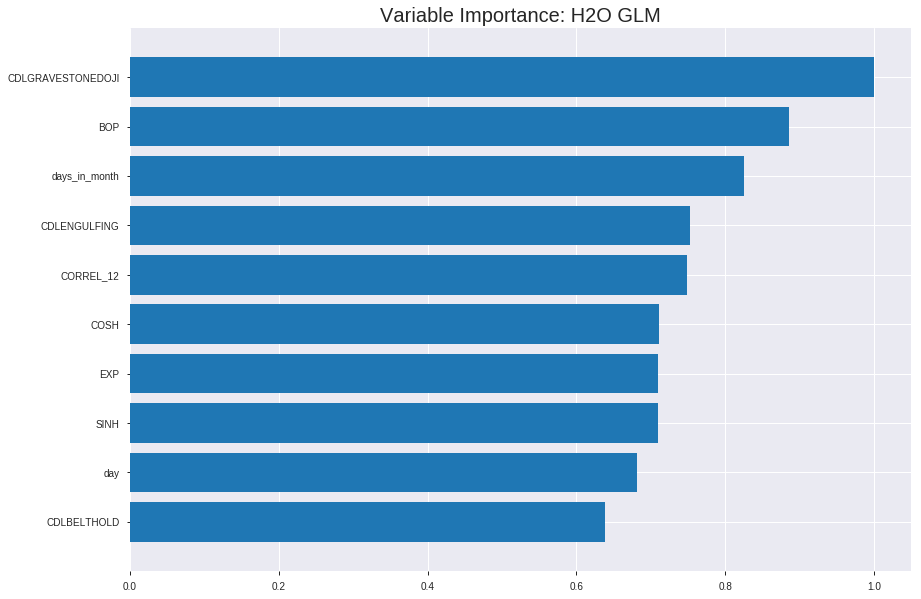

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_141951_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24574832674227481
RMSE: 0.4957300946505818
LogLoss: 0.68458452293393
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2426.6126264514623
Residual deviance: 2400.153337406359
AIC: 4486.153337406358
AUC: 0.5846206820992002
pr_auc: 0.6113696444412042
Gini: 0.1692413641984003
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4458567321388951: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   813   0.9713   (813.0/837.0)
1      4    912   0.0044   (4.0/916.0)
Total  28   1725  0.4661   (817.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445857     0.690647  377
max f2                       0.440365     0.846767  382
max f0point5                 0.513121     0.585881  229
max accuracy                 0.531715     0.567598  157
max precision                0.625654     1         0
max recall                   0.404649     1         395
max specificity              0.625654     1         0
max absolute_mcc             0.54721      0.151597  104
max min_per_class_accuracy   0.523713     0.555677  187
max mean_per_class_accuracy  0.531715     0.572334  157

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.591183           1.5948    1.5948             0.833333         0.598059  0.833333                    0.598059            0.0163755       0.0163755                  59.4796   59.4796
    2        0.0205362                   0.581965           1.48848   1.54164            0.777778         0.585285  0.805556                    0.591672            0.0152838       0.0316594                  48.8476   54.1636
    3        0.0302339                   0.577627           1.35089   1.48045            0.705882         0.579764  0.773585                    0.587852            0.0131004       0.0447598                  35.0886   48.0452
    4        0.040502                    0.572322           1.38216   1.45553            0.722222         0.574472  0.760563                    0.58446             0.0141921       0.058952                   38.2157   45.5532
    5        0.0501997                   0.569933           1.12574   1.39182            0.588235         0.571216  0.727273                    0.581902            0.010917        0.069869                   12.5739   39.1822
    6        0.100399                    0.559233           1.30483   1.34833            0.681818         0.563546  0.704545                    0.572724            0.0655022       0.135371                   30.4833   34.8328
    7        0.150029                    0.552044           1.09986   1.26613            0.574713         0.555392  0.661597                    0.566991            0.0545852       0.189956                   9.98595   26.6135
    8        0.200228                    0.547351           1.30483   1.27584            0.681818         0.549743  0.666667                    0.562666            0.0655022       0.255459                   30.4833   27.5837
    9        0.300057                    0.538489           1.02796   1.19337            0.537143         0.542614  0.623574                    0.555995            0.10262         0.358079                   2.79601   19.3368
    10       0.399886                    0.531493           1.09357   1.16846            0.571429         0.534747  0.610556                    0.55069             0.10917         0.467249                   9.35745   16.8456
    11       0.500285                    0.523641           0.880762  1.11072            0.460227         0.527667  0.580388                    0.54607             0.0884279       0.555677                   -11.9238  11.072
    12       0.600114                    0.516544           0.896731  1.07512            0.468571         0.52      0.561787                    0.541733            0.0895197       0.645197                   -10.3269  7.51231
    13       0.699943                    0.508698           0.929538  1.05436            0.485714         0.51292   0.550937                    0.537624            0.0927948       0.737991                   -7.04616  5.43592
    14       0.799772                    0.499991           0.87486   1.03195            0.457143         0.504463  0.53923                     0.533485            0.0873362       0.825328                   -12.514   3.19537
    15       0.899601                    0.484416           0.918603  1.01938            0.48             0.493171  0.532657                    0.529011            0.0917031       0.917031                   -8.13974  1.93751
    16       1                           0.360645           0.826394  1                  0.431818         0.464487  0.522533                    0.522533          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2489688763829058
RMSE: 0.49896781096870946
LogLoss: 0.6910800834746416
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 693.1168027311257
Residual deviance: 692.4622436415908
AIC: 2778.4622436415907
AUC: 0.5343626134765375
pr_auc: 0.5680184616855017
Gini: 0.06872522695307492
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45045291200201104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    229  0.9662   (229.0/237.0)
1      3    261  0.0114   (3.0/264.0)
Total  11   490  0.4631   (232.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450453     0.692308  388
max f2                       0.440868     0.848875  397
max f0point5                 0.450453     0.586781  388
max accuracy                 0.46479      0.538922  360
max precision                0.544211     0.777778  16
max recall                   0.440868     1         397
max specificity              0.56744      0.995781  0
max absolute_mcc             0.523695     0.104406  80
max min_per_class_accuracy   0.501073     0.518987  199
max mean_per_class_accuracy  0.523695     0.541475  80

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.550198           1.26515   1.26515            0.666667         0.557328  0.666667                    0.557328            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.547825           1.51818   1.38017            0.8              0.548512  0.727273                    0.553321            0.0151515       0.030303                   51.8182   38.0165
    3        0.0319361                   0.545071           1.51818   1.4233             0.8              0.546649  0.75                        0.551236            0.0151515       0.0454545                  51.8182   42.3295
    4        0.0419162                   0.542285           1.13864   1.35552            0.6              0.543603  0.714286                    0.549418            0.0113636       0.0568182                  13.8636   35.5519
    5        0.0518962                   0.54052            1.13864   1.31381            0.6              0.541058  0.692308                    0.547811            0.0113636       0.0681818                  13.8636   31.3811
    6        0.101796                    0.532911           0.986818  1.15352            0.52             0.536485  0.607843                    0.542259            0.0492424       0.117424                   -1.31818  15.352
    7        0.151697                    0.527266           1.13864   1.14862            0.6              0.529887  0.605263                    0.538189            0.0568182       0.174242                   13.8636   14.8624
    8        0.201597                    0.52343            1.29045   1.18373            0.68             0.525232  0.623762                    0.534982            0.0643939       0.238636                   29.0455   18.3731
    9        0.301397                    0.516922           0.948864  1.10596            0.5              0.519823  0.582781                    0.529963            0.094697        0.333333                   -5.11364  10.596
    10       0.401198                    0.50892            0.948864  1.06688            0.5              0.513391  0.562189                    0.52584             0.094697        0.42803                    -5.11364  6.68815
    11       0.500998                    0.501079           0.910909  1.03581            0.48             0.504888  0.545817                    0.521667            0.0909091       0.518939                   -8.90909  3.58113
    12       0.600798                    0.495351           0.948864  1.02137            0.5              0.498466  0.538206                    0.517813            0.094697        0.613636                   -5.11364  2.13682
    13       0.700599                    0.48842            0.948864  1.01104            0.5              0.49251   0.532764                    0.514208            0.094697        0.708333                   -5.11364  1.10399
    14       0.800399                    0.479794           0.948864  1.00329            0.5              0.483845  0.528678                    0.510422            0.094697        0.80303                    -5.11364  0.328724
    15       0.9002                      0.468192           1.02477   1.00567            0.54             0.474047  0.529933                    0.50639             0.102273        0.905303                   2.47727   0.566922
    16       1                           0.436364           0.948864  1                  0.5              0.457317  0.526946                    0.501492         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:19:54  0.000 sec   2            3.9       1043          1.36917           1.38216
    2019-08-27 14:19:56  1.959 sec   4            2.8       1043          1.36577           1.38235
    2019-08-27 14:19:58  3.847 sec   6            2.1       1043          1.3617            1.38272
    2019-08-27 14:20:00  5.686 sec   8            1.5       1043          1.35689           1.3834
    2019-08-27 14:20:02  7.532 sec   10           1.1       1043          1.35135           1.38446
    2019-08-27 14:20:04  9.406 sec   12           0.79      1043          1.34512           1.386

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6892950391644909)

('auc', 0.5133053221288516)

('logloss', 0.6941900901551602)

('mean_per_class_error', 0.4506302521008403)

('rmse', 0.500514957864259)

('mse', 0.250515223045861)

glm prediction progress: |████████████████████████████████████████████████| 100%


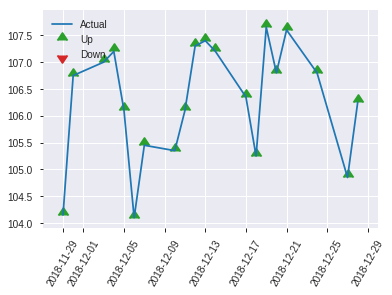


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.250515223045861
RMSE: 0.500514957864259
LogLoss: 0.6941900901551602
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 347.29766117999407
Residual deviance: 348.4834252578904
AIC: 2434.4834252578903
AUC: 0.5133053221288516
pr_auc: 0.5592634097986412
Gini: 0.02661064425770321
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44156762826105356: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    132  0        (0.0/132.0)
Total  0    251  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441568     0.689295  250
max f2                       0.441568     0.84724   250
max f0point5                 0.475346     0.583004  219
max accuracy                 0.477344     0.537849  215
max precision                0.535772     0.75      7
max recall                   0.441568     1         250
max specificity              0.580677     0.991597  0
max absolute_mcc             0.456088     0.148586  244
max min_per_class_accuracy   0.497586     0.507576  124
max mean_per_class_accuracy  0.518255     0.54937   50

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.543083           1.26768   1.26768            0.666667         0.55689   0.666667                    0.55689             0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.539032           1.26768   1.26768            0.666667         0.540966  0.666667                    0.548928            0.0151515       0.030303                   26.7677   26.7677
    3        0.0318725                   0.535552           1.90152   1.42614            1                0.535843  0.75                        0.545656            0.0151515       0.0454545                  90.1515   42.6136
    4        0.0438247                   0.533215           1.26768   1.38292            0.666667         0.534423  0.727273                    0.542593            0.0151515       0.0606061                  26.7677   38.292
    5        0.0517928                   0.530981           0.950758  1.31643            0.5              0.531562  0.692308                    0.540896            0.00757576      0.0681818                  -4.92424  31.6434
    6        0.103586                    0.524401           1.17016   1.2433             0.615385         0.527985  0.653846                    0.53444             0.0606061       0.128788                   17.0163   24.3298
    7        0.151394                    0.520103           1.10922   1.20096            0.583333         0.521885  0.631579                    0.530475            0.0530303       0.181818                   10.9217   20.0957
    8        0.203187                    0.518255           1.31643   1.23039            0.692308         0.519319  0.647059                    0.527632            0.0681818       0.25                       31.6434   23.0392
    9        0.302789                    0.511452           0.608485  1.02582            0.32             0.515267  0.539474                    0.523564            0.0606061       0.310606                   -39.1515  2.58174
    10       0.40239                     0.504826           0.836667  0.978998           0.44             0.507917  0.514851                    0.519691            0.0833333       0.393939                   -16.3333  -2.10021
    11       0.501992                    0.497563           1.14091   1.01112            0.6              0.500307  0.531746                    0.515845            0.113636        0.507576                   14.0909   1.11231
    12       0.601594                    0.492936           0.836667  0.98224            0.44             0.494903  0.516556                    0.512378            0.0833333       0.590909                   -16.3333  -1.77604
    13       0.701195                    0.486434           1.14091   1.00478            0.6              0.489532  0.528409                    0.509133            0.113636        0.704545                   14.0909   0.477789
    14       0.800797                    0.481308           1.06485   1.01225            0.56             0.483728  0.532338                    0.505973            0.106061        0.810606                   6.48485   1.22494
    15       0.900398                    0.472261           0.836667  0.992826           0.44             0.477756  0.522124                    0.502852            0.0833333       0.893939                   -16.3333  -0.71735
    16       1                           0.441568           1.06485   1                  0.56             0.46027   0.525896                    0.49861       

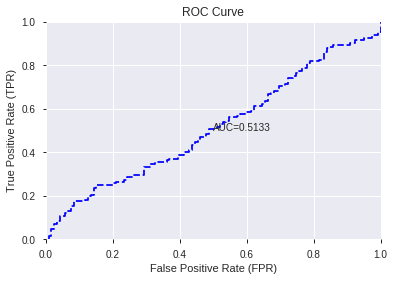

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


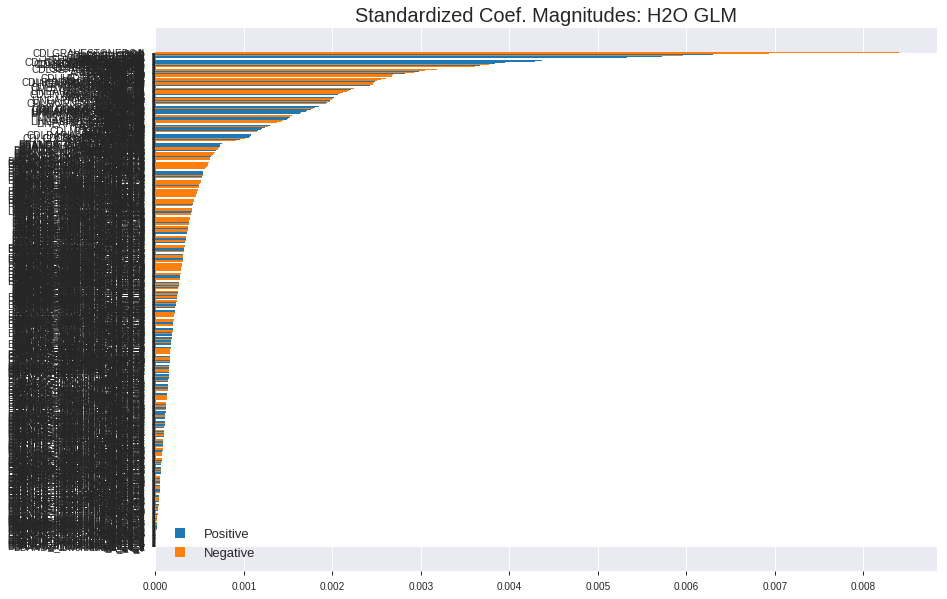

'log_likelihood'
--2019-08-27 14:20:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_141951_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_141951_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLGRAVESTONEDOJI',
 'BOP',
 'days_in_month',
 'CDLENGULFING',
 'CORREL_12',
 'COSH',
 'EXP',
 'SINH',
 'day',
 'CDLBELTHOLD',
 'CORREL_20',
 'CORREL_14',
 'CDLHARAMICROSS',
 'CDLDOJISTAR',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'is_month_start',
 'CDLHAMMER',
 'CORREL_24',
 'CDLGAPSIDESIDEWHITE',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'CDLBREAKAWAY',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'is_quarter_start',
 'OBV',
 'CORREL_8',
 'PLUS_DI_30',
 'CDLONNECK',
 'CDLEVENINGSTAR',
 'CDLRICKSHAWMAN',
 'TAN',
 'WILLR_8',
 'CDLSEPARATINGLINES',
 'PLUS_DI_24',
 'MFI_14',
 'AROONOSC_30',
 'aroonup_30',
 'aroondown_14',
 'CDL2CROWS',
 'DX_20',
 'PLUS_DI_20',
 'CDL3INSIDE',
 'CORREL_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'DX_24',
 'CCI_8',
 'HT_TRENDMODE',
 'CDLLADDERBOTTOM',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'DX_14',
 'MACDFIX_hist_24',
 'COS',
 'CDLRISEFALL3METHODS',
 'LINEARREG_SLOPE_24',
 'CDLHOMINGPIGEON',
 'SAREXT',
 'DX_30',
 'CDLTHRUSTING',
 'PLUS

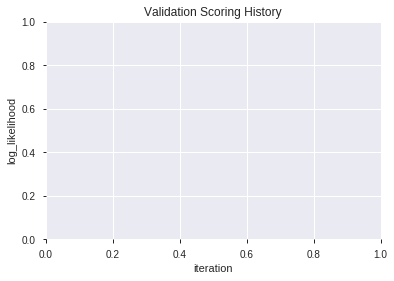

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_142031_model_1  0.604278  0.682650              0.486981  0.494720  0.244748
1               XGBoost_3_AutoML_20190827_142031  0.551502  0.690222              0.460530  0.498419  0.248421
2  XGBoost_grid_1_AutoML_20190827_142031_model_4  0.535332  0.691207              0.482366  0.499047  0.249048
3               XGBoost_1_AutoML_20190827_142031  0.528202  0.702158              0.482779  0.503935  0.253951
4  XGBoost_grid_1_AutoML_20190827_142031_model_3  0.525783  0.695487              0.482366  0.501140  0.251141
5               XGBoost_2_AutoML_20190827_142031  0.514642  0.699812              0.473135  0.503056  0.253065
6  XGBoost_grid_1_AutoML_20190827_142031_model_7  0.505984  0.718073              0.500000  0.511133  0.261257
7  XGBoost_grid_1_AutoML_20190827_142031_model_6  0.501401  0.703892              0.500000  0.505162  0.255188
8  XGBoost_grid_1_AutoML_20190827_142031_model_5  0.501146  0.727015              0.491183  0.514593  0.264806
9  XGBoost_grid_1_AutoML_20190827_142031_model_2  0.490960  0.703162              0.495798  0.504854  0.254877

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           133.372513           1.000000    0.030455
1                        BOP           127.266624           0.954219    0.029061
2                  dayofyear            88.701439           0.665065    0.020255
3                       week            80.266296           0.601820    0.018328
4                        SUB            74.265526           0.556828    0.016958
..                       ...                  ...                ...         ...
203  BBANDS_lowerband_12_7_5             4.780578           0.035844    0.001092
204                 MAVP_8_5             3.828952           0.028709    0.000874
205                    VAR_8             3.693741           0.027695    0.000843
206                   MFI_24             3.511715           0.026330    0.000802
207  BBANDS_lowerband_20_2_5             1.894745           0.014206    0.000433

[208 rows x 4 columns]

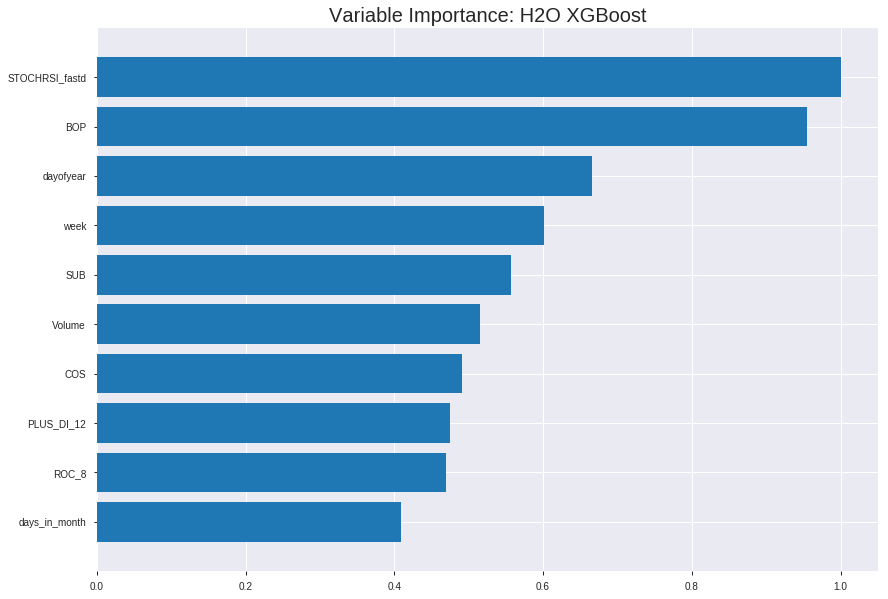

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_142031_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19038031563262192
RMSE: 0.43632592821493194
LogLoss: 0.5705166883307808
Mean Per-Class Error: 0.16751772550124433
AUC: 0.9132076505298087
pr_auc: 0.9276089837338416
Gini: 0.8264153010596174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49471468159130644: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      634  203   0.2425   (203.0/837.0)
1      103  813   0.1124   (103.0/916.0)
Total  737  1016  0.1746   (306.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494715     0.841615  224
max f2                       0.436548     0.886126  291
max f0point5                 0.548421     0.86612   168
max accuracy                 0.50936      0.832288  208
max precision                0.812468     1         0
max recall                   0.358891     1         350
max specificity              0.812468     1         0
max absolute_mcc             0.519101     0.664294  199
max min_per_class_accuracy   0.513122     0.828603  204
max mean_per_class_accuracy  0.519101     0.832482  199

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.744167           1.91376    1.91376            1                0.764616  1                           0.764616            0.0196507       0.0196507                  91.3755   91.3755
    2        0.0205362                   0.723718           1.91376    1.91376            1                0.73144   1                           0.748028            0.0196507       0.0393013                  91.3755   91.3755
    3        0.0302339                   0.704611           1.91376    1.91376            1                0.713624  1                           0.736993            0.018559        0.0578603                  91.3755   91.3755
    4        0.040502                    0.69529            1.91376    1.91376            1                0.699305  1                           0.727438            0.0196507       0.0775109                  91.3755   91.3755
    5        0.0501997                   0.689181           1.91376    1.91376            1                0.692824  1                           0.720751            0.018559        0.0960699                  91.3755   91.3755
    6        0.100399                    0.655002           1.91376    1.91376            1                0.67036   1                           0.695555            0.0960699       0.19214                    91.3755   91.3755
    7        0.150029                    0.630174           1.91376    1.91376            1                0.642614  1                           0.678042            0.0949782       0.287118                   91.3755   91.3755
    8        0.200228                    0.611162           1.89201    1.9083             0.988636         0.620957  0.997151                    0.66373             0.0949782       0.382096                   89.2008   90.8303
    9        0.300057                    0.57598            1.73878    1.8519             0.908571         0.592912  0.967681                    0.640169            0.173581        0.555677                   73.8784   85.1904
    10       0.399886                    0.545742           1.46539    1.75541            0.765714         0.559978  0.917261                    0.62015             0.146288        0.701965                   46.539    75.5413
    11       0.500285                    0.517583           1.14173    1.63226            0.596591         0.532171  0.852908                    0.602494            0.114629        0.816594                   14.1729   63.2257
    12       0.600114                    0.489937           0.809245   1.49535            0.422857         0.502899  0.781369                    0.585926            0.080786        0.89738                    -19.0755  49.5349
    13       0.699943                    0.463376           0.459301   1.34758            0.24             0.476515  0.704156                    0.570322            0.0458515       0.943231                   -54.0699  34.7583
    14       0.799772                    0.43627            0.36088    1.22442            0.188571         0.450778  0.6398                      0.5554              0.0360262       0.979258                   -63.912   22.4421
    15       0.899601                    0.395405           0.174972   1.10796            0.0914286        0.417272  0.578947                    0.540072            0.0174672       0.996725                   -82.5028  10.7964
    16       1                           0.219463           0.0326208  1                  0.0170455        0.34719   0.522533                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2569892809045358
RMSE: 0.5069411020074579
LogLoss: 0.7078320026620224
Mean Per-Class Error: 0.47787207518220176
AUC: 0.49879331287559137
pr_auc: 0.5235718782894879
Gini: -0.0024133742488172683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2913474142551422: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    237  1        (237.0/237.0)
1      0    264  0        (0.0/264.0)
Total  0    501  0.4731   (237.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.291347     0.690196   399
max f2                       0.291347     0.847784   399
max f0point5                 0.291347     0.582011   399
max accuracy                 0.499379     0.530938   255
max precision                0.729382     1          0
max recall                   0.291347     1          399
max specificity              0.729382     1          0
max absolute_mcc             0.389738     0.0933462  365
max min_per_class_accuracy   0.525298     0.514768   198
max mean_per_class_accuracy  0.499379     0.522128   255

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 52.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.699243           1.26515   1.26515            0.666667         0.718327  0.666667                    0.718327            0.0151515       0.0151515                  26.5152   26.5152
    2        0.0219561                   0.681825           0.759091  1.03512            0.4              0.690436  0.545455                    0.705649            0.00757576      0.0227273                  -24.0909  3.5124
    3        0.0319361                   0.662698           0.759091  0.948864           0.4              0.672676  0.5                         0.695345            0.00757576      0.030303                   -24.0909  -5.11364
    4        0.0419162                   0.647414           1.51818   1.08442            0.8              0.651636  0.571429                    0.684938            0.0151515       0.0454545                  51.8182   8.44156
    5        0.0518962                   0.640787           0.759091  1.02185            0.4              0.644504  0.538462                    0.677163            0.00757576      0.0530303                  -24.0909  2.18531
    6        0.101796                    0.618565           0.835     0.930258           0.44             0.629329  0.490196                    0.653715            0.0416667       0.094697                   -16.5     -6.97415
    7        0.151697                    0.600301           0.986818  0.948864           0.52             0.609667  0.5                         0.639225            0.0492424       0.143939                   -1.31818  -5.11364
    8        0.201597                    0.586838           0.910909  0.939469           0.48             0.59318   0.49505                     0.627828            0.0454545       0.189394                   -8.90909  -6.05311
    9        0.301397                    0.561927           1.17659   1.01799            0.62             0.573153  0.536424                    0.609724            0.117424        0.306818                   17.6591   1.79862
    10       0.401198                    0.543268           0.835     0.972467           0.44             0.551306  0.512438                    0.595192            0.0833333       0.390152                   -16.5     -2.75328
    11       0.500998                    0.525275           1.2525    1.02825            0.66             0.534181  0.541833                    0.583038            0.125           0.515152                   25.25     2.82506
    12       0.600798                    0.507342           0.986818  1.02137            0.52             0.516886  0.538206                    0.57205             0.0984848       0.613636                   -1.31818  2.13682
    13       0.700599                    0.49044            0.910909  1.00563            0.48             0.500693  0.529915                    0.561885            0.0909091       0.704545                   -8.90909  0.563326
    14       0.800399                    0.467032           1.02477   1.00802            0.54             0.477833  0.531172                    0.551405            0.102273        0.806818                   2.47727   0.801972
    15       0.9002                      0.412419           0.797045  0.98463            0.42             0.441608  0.518847                    0.539232            0.0795455       0.886364                   -20.2955  -1.53699
    16       1                           0.291347           1.13864   1                  0.6              0.368384  0.526946                    0.522181  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:20:47  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.477467                         0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 14:20:49  1.023 sec   5                  0.49047          0.674231            0.779137        0.806161           1.91376          0.332573                         0.500446           0.694043              0.496724          0.516694             0.948864           0.473054
    2019-08-27 14:20:49  1.225 sec   10                 0.482733         0.659               0.790743        0.818299           1.91376          0.293782                         0.501309           0.695807              0.496795          0.510795             0.948864           0.473054
    2019-08-27 14:20:49  1.434 sec   15                 0.474452         0.642893            0.833631        0.856148           1.91376          0.262407                         0.501445           0.696134              0.506241          0.52043              0.632576           0.473054
    2019-08-27 14:20:49  1.632 sec   20                 0.469872         0.633993            0.841985        0.865798           1.91376          0.245864                         0.501399           0.696089              0.514161          0.529904             0.948864           0.473054
    2019-08-27 14:20:49  1.849 sec   25                 0.462982         0.620768            0.865315        0.885886           1.91376          0.226469                         0.502364           0.698064              0.508719          0.531286             1.26515            0.473054
    2019-08-27 14:20:50  2.065 sec   30                 0.457587         0.610408            0.87375         0.892533           1.91376          0.207074                         0.503454           0.700323              0.502365          0.525967             1.26515            0.473054
    2019-08-27 14:20:50  2.400 sec   35                 0.452319         0.600399            0.8852          0.903021           1.91376          0.199658                         0.504576           0.702685              0.500591          0.524097             0.948864           0.473054
    2019-08-27 14:20:50  2.659 sec   40                 0.447225         0.590815            0.894302        0.910057           1.91376          0.187108                         0.505503           0.704714              0.500871          0.523469             1.26515            0.473054
    2019-08-27 14:20:50  2.873 sec   45                 0.441721         0.580533            0.905815        0.92085            1.91376          0.173417                         0.505775           0.705324              0.503476          0.528392             1.26515            0.473054
    2019-08-27 14:20:51  3.072 sec   50                 0.436326         0.570517            0.913208        0.927609           1.91376          0.174558                         0.506941           0.707832              0.498793          0.523572             1.26515            0.473054

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
STOCHRSI_fastd           133.3725128173828      1.0                   0.030455099262104504
BOP                      127.2666244506836      0.954219289734313     0.02906084318667336
dayofyear                88.7014389038086       0.6650653648946463    0.020254631703654206
week                     80.26629638671875      0.6018203803104579    0.018328499420312477
SUB                      74.2655258178711       0.5568278219332752    0.016958246588879344
---                      ---                    ---                   ---
BBANDS_lowerband_12_7_5  4.780578136444092      0.03584380346038607   0.0010916265923174226
MAVP_8_5                 3.828951835632324      0.028708702826009035  0.0008743263942523652
VAR_8                    3.6937408447265625     0.0276949182908785    0.0008434514856045783
MFI_24                   3.5117154121398926     0.02633012858465242   0.0008018866796295646
BBANDS_lowerband_20_2_5  1.894744873046875      0.01420641204864461   0.000432657689099829


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6095617529880478)

('F1', 0.6931216931216931)

('auc', 0.6042780748663101)

('logloss', 0.6826503940555262)

('mean_per_class_error', 0.38941940412528653)

('rmse', 0.4947203651425679)

('mse', 0.24474823968679568)

xgboost prediction progress: |████████████████████████████████████████████| 100%


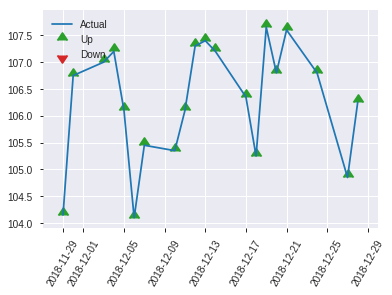


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24474823968679568
RMSE: 0.4947203651425679
LogLoss: 0.6826503940555262
Mean Per-Class Error: 0.38941940412528653
AUC: 0.6042780748663101
pr_auc: 0.6067096306212326
Gini: 0.20855614973262027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4335276782512665: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    115  0.9664   (115.0/119.0)
1      1    131  0.0076   (1.0/132.0)
Total  5    246  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433528     0.693122  245
max f2                       0.343788     0.84724   250
max f0point5                 0.544339     0.629032  121
max accuracy                 0.544339     0.609562  121
max precision                0.614522     0.72      24
max recall                   0.343788     1         250
max specificity              0.711708     0.991597  0
max absolute_mcc             0.544339     0.22095   121
max min_per_class_accuracy   0.54374      0.598485  123
max mean_per_class_accuracy  0.544339     0.610581  121

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 54.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.679699           1.26768   1.26768            0.666667         0.691934  0.666667                    0.691934            0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.6648             0.633838  0.950758           0.333333         0.669523  0.5                         0.680728            0.00757576      0.0227273                  -36.6162  -4.92424
    3        0.0318725                   0.651342           1.90152   1.18845            1                0.657429  0.625                       0.674903            0.0151515       0.0378788                  90.1515   18.8447
    4        0.0438247                   0.644189           0.633838  1.03719            0.333333         0.64588   0.545455                    0.666988            0.00757576      0.0454545                  -36.6162  3.71901
    5        0.0517928                   0.63806            1.90152   1.17016            1                0.640227  0.615385                    0.662871            0.0151515       0.0606061                  90.1515   17.0163
    6        0.103586                    0.614213           1.4627    1.31643            0.769231         0.624673  0.692308                    0.643772            0.0757576       0.136364                   46.2704   31.6434
    7        0.151394                    0.598034           1.26768   1.30104            0.666667         0.60522   0.684211                    0.631597            0.0606061       0.19697                    26.7677   30.1037
    8        0.203187                    0.586295           0.877622  1.19311            0.461538         0.589885  0.627451                    0.620965            0.0454545       0.242424                   -12.2378  19.3108
    9        0.302789                    0.569129           1.36909   1.251              0.72             0.575335  0.657895                    0.605955            0.136364        0.378788                   36.9091   25.0997
    10       0.40239                     0.557391           1.14091   1.22375            0.6              0.563783  0.643564                    0.595516            0.113636        0.492424                   14.0909   22.3747
    11       0.501992                    0.543103           1.06485   1.19222            0.56             0.550377  0.626984                    0.58656             0.106061        0.598485                   6.48485   19.222
    12       0.601594                    0.530883           0.912727  1.14595            0.48             0.537305  0.602649                    0.578405            0.0909091       0.689394                   -8.72727  14.5946
    13       0.701195                    0.516993           0.836667  1.10201            0.44             0.52423   0.579545                    0.57071             0.0833333       0.772727                   -16.3333  10.2014
    14       0.800797                    0.501537           0.456364  1.02171            0.24             0.510211  0.537313                    0.563185            0.0454545       0.818182                   -54.3636  2.17096
    15       0.900398                    0.479846           0.760606  0.992826           0.4              0.488038  0.522124                    0.554872            0.0757576       0.893939                   -23.9394  -0.71735
    16       1                           0.343788           1.06485   1                  0.56             0.450452  0.525896                    0.544472        

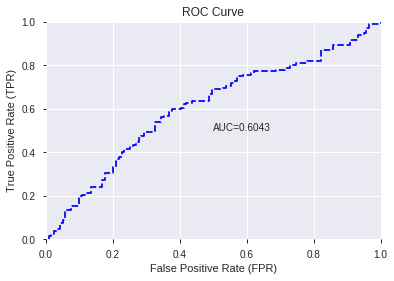

This function is available for GLM models only


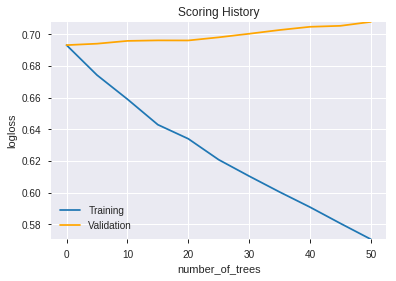

--2019-08-27 14:21:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_142031_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_142031_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCHRSI_fastd',
 'BOP',
 'dayofyear',
 'week',
 'SUB',
 'Volume',
 'COS',
 'PLUS_DI_12',
 'ROC_8',
 'days_in_month',
 'CMO_8',
 'APO',
 'ADOSC',
 'SIN',
 'DX_24',
 'PPO',
 'MFI_12',
 'CORREL_12',
 'ROC_12',
 'ADXR_14',
 'STOCHF_fastk',
 'AROONOSC_8',
 'CORREL_14',
 'DX_30',
 'OBV',
 'ROC_20',
 'CORREL_24',
 'TRANGE',
 'MACDFIX_signal_8',
 'MACDFIX_signal_24',
 'MACDFIX_signal_12',
 'CORREL_30',
 'HT_PHASOR_inphase',
 'MACDFIX_hist_12',
 'BETA_20',
 'HT_PHASOR_quadrature',
 'MOM_8',
 'BBANDS_lowerband_20_3_5',
 'CCI_12',
 'LINEARREG_ANGLE_8',
 'CCI_14',
 'BETA_30',
 'DX_20',
 'CORREL_20',
 'BBANDS_upperband_8_3_5',
 'DX_14',
 'STOCHRSI_fastk',
 'MINUS_DM_24',
 'MOM_20',
 'ATR_8',
 'HT_DCPERIOD',
 'MACDFIX_hist_14',
 'CORREL_8',
 'ROC_24',
 'BBANDS_lowerband_30_2_2',
 'PLUS_DM_8',
 'STOCH_slowk',
 'MFI_30',
 'PLUS_DI_24',
 'NATR_8',
 'BBANDS_lowerband_24_6_4',
 'ROC_30',
 'ADX_24',
 'dayofweek',
 'MACDEXT_hist',
 'MFI_8',
 'WILLR_8',
 'mama',
 'ADX_8',
 'BETA_12',
 'TRIMA_30',
 'Close

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

610

['BBANDS_middleband_12_3_3',
 'BBANDS_lowerband_12_3_3',
 'BBANDS_upperband_12_3_4',
 'BBANDS_middleband_12_3_4',
 'BBANDS_lowerband_12_3_4',
 'BBANDS_upperband_12_3_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_lowerband_12_3_5',
 'MA_12_4',
 'MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_142311_model_7  0.533773  0.698787              0.478164  0.502888  0.252896
1  DeepLearning_grid_1_AutoML_20190827_142311_model_1  0.517634  1.840467              0.500000  0.634999  0.403223
2               DeepLearning_1_AutoML_20190827_142311  0.513942  0.693614              0.486567  0.500233  0.250233
3  DeepLearning_grid_1_AutoML_20190827_142311_model_5  0.511459  0.691425              0.500000  0.499140  0.249141
4  DeepLearning_grid_1_AutoML_20190827_142311_model_2  0.510313  0.818555              0.500000  0.543593  0.295494
5  DeepLearning_grid_1_AutoML_20190827_142311_model_9  0.500000  0.691865              0.500000  0.499359  0.249359
6  DeepLearning_grid_1_AutoML_20190827_142311_model_8  0.500000  0.691895              0.500000  0.499373  0.249374
7  DeepLearning_grid_1_AutoML_20190827_142311_model_6  0.468456  0.696742              0.487395  0.501792  0.251795
8  DeepLearning_grid_1_AutoML_20190827_142311_model_3  0.457601  0.776040              0.500000  0.532899  0.283981
9  DeepLearning_grid_1_AutoML_20190827_142311_model_4  0.451681  1.031983              0.495798  0.601094  0.361314

variable  relative_importance  scaled_importance  percentage
0           CDLLONGLEGGEDDOJI             1.000000           1.000000    0.001985
1                         BOP             0.973190           0.973190    0.001932
2                         OBV             0.969250           0.969250    0.001924
3                     CDLDOJI             0.965654           0.965654    0.001917
4              STOCHRSI_fastk             0.963826           0.963826    0.001913
..                        ...                  ...                ...         ...
605  BBANDS_middleband_12_5_5             0.765343           0.765343    0.001519
606  BBANDS_middleband_20_0_4             0.755641           0.755641    0.001500
607  BBANDS_middleband_12_4_2             0.754634           0.754634    0.001498
608                 MAVP_14_4             0.749910           0.749910    0.001489
609                   MA_24_2             0.739281           0.739281    0.001468

[610 rows x 4 columns]

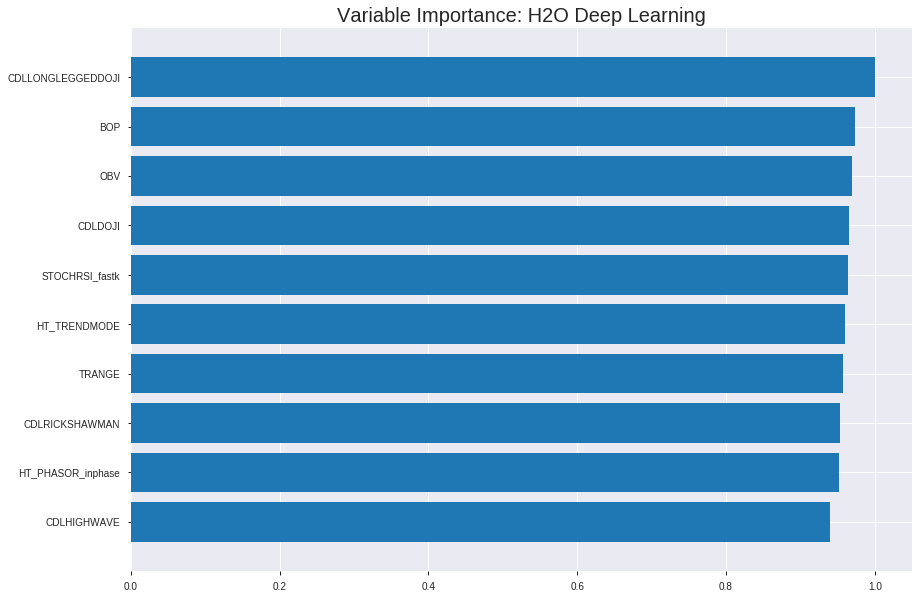

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_142311_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17810426163516904
RMSE: 0.4220240059939352
LogLoss: 0.5184977717291169
Mean Per-Class Error: 0.30037094426445043
AUC: 0.8028849916263637
pr_auc: 0.786154934544003
Gini: 0.6057699832527275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3982879187378507: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      369  468   0.5591   (468.0/837.0)
1      61   855   0.0666   (61.0/916.0)
Total  430  1323  0.3018   (529.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398288     0.763734  271
max f2                       0.112854     0.872738  349
max f0point5                 0.645705     0.73646   159
max accuracy                 0.604972     0.704507  183
max precision                0.999828     1         0
max recall                   0.0021709    1         396
max specificity              0.999828     1         0
max absolute_mcc             0.398288     0.434487  271
max min_per_class_accuracy   0.607122     0.592593  182
max mean_per_class_accuracy  0.604972     0.699629  183

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 55.00 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.999888           1.91376    1.91376            1                0.999952    1                           0.999952            0.0196507       0.0196507                  91.3755   91.3755
    2        0.0205362                   0.999636           1.91376    1.91376            1                0.999769    1                           0.999861            0.0196507       0.0393013                  91.3755   91.3755
    3        0.0302339                   0.999146           1.91376    1.91376            1                0.999438    1                           0.999725            0.018559        0.0578603                  91.3755   91.3755
    4        0.040502                    0.998362           1.91376    1.91376            1                0.99877     1                           0.999483            0.0196507       0.0775109                  91.3755   91.3755
    5        0.0501997                   0.996967           1.91376    1.91376            1                0.997761    1                           0.99915             0.018559        0.0960699                  91.3755   91.3755
    6        0.100399                    0.971973           1.84851    1.88113            0.965909         0.986252    0.982955                    0.992701            0.0927948       0.188865                   84.8514   88.1135
    7        0.150029                    0.902127           1.80377    1.85554            0.942529         0.940614    0.969582                    0.975471            0.0895197       0.278384                   80.377    85.5542
    8        0.200228                    0.782555           1.54405    1.77745            0.806818         0.845972    0.928775                    0.943004            0.0775109       0.355895                   54.4053   77.7448
    9        0.300057                    0.645312           1.30135    1.61905            0.68             0.703402    0.846008                    0.863288            0.129913        0.485808                   30.1354   61.9052
    10       0.614375                    0.607124           1.01419    1.3096             0.529946         0.610658    0.684308                    0.734041            0.318777        0.804585                   1.41862   30.9599
    11       0.699943                    0.522807           0.918603   1.2618             0.48             0.570619    0.659332                    0.714063            0.0786026       0.883188                   -8.13974  26.18
    12       0.799772                    0.231366           0.765502   1.19985            0.4              0.397239    0.626961                    0.674516            0.0764192       0.959607                   -23.4498  19.9851
    13       0.899601                    0.0195236          0.371815   1.10796            0.194286         0.101406    0.578947                    0.610918            0.0371179       0.996725                   -62.8185  10.7964
    14       1                           5.76594e-12        0.0326208  1                  0.0170455        0.00421263  0.522533                    0.550005            0.00327511      1                          -96.7379  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2695388624434757
RMSE: 0.5191713228246295
LogLoss: 0.7437963349671605
Mean Per-Class Error: 0.48539988492520136
AUC: 0.4802934407364787
pr_auc: 0.5091895988694372
Gini: -0.039413118527042545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16832306150885298: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    231  0.9747   (231.0/237.0)
1      2    262  0.0076   (2.0/264.0)
Total  8    493  0.4651   (233.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.168323     0.692206   233
max f2                       0.0565672    0.848875   239
max f0point5                 0.229337     0.587156   219
max accuracy                 0.268672     0.538922   217
max precision                0.932374     0.75       3
max recall                   0.0565672    1          239
max specificity              0.972601     0.995781   0
max absolute_mcc             0.554133     0.0730689  141
max min_per_class_accuracy   0.607124     0.345992   63
max mean_per_class_accuracy  0.268672     0.5146     217

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 57.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011976                    0.925393           1.26515   1.26515            0.666667         0.943401  0.666667                    0.943401            0.0151515       0.0151515                  26.5152    26.5152
    2        0.0219561                   0.877429           0.759091  1.03512            0.4              0.891899  0.545455                    0.919991            0.00757576      0.0227273                  -24.0909   3.5124
    3        0.0319361                   0.836804           1.13864   1.06747            0.6              0.850417  0.5625                      0.898249            0.0113636       0.0340909                  13.8636    6.74716
    4        0.0419162                   0.782209           1.51818   1.17478            0.8              0.800578  0.619048                    0.874994            0.0151515       0.0492424                  51.8182    17.4784
    5        0.0518962                   0.745053           0.759091  1.09484            0.4              0.767838  0.576923                    0.854387            0.00757576      0.0568182                  -24.0909   9.48427
    6        0.101796                    0.62636            0.759091  0.930258           0.4              0.678269  0.490196                    0.768055            0.0378788       0.094697                   -24.0909   -6.97415
    7        0.644711                    0.607124           0.997702  0.987053           0.525735         0.607556  0.520124                    0.632898            0.541667        0.636364                   -0.229779  -1.29468
    8        0.700599                    0.593139           0.881088  0.9786             0.464286         0.5999    0.51567                     0.630266            0.0492424       0.685606                   -11.8912   -2.13999
    9        0.800399                    0.554133           0.872955  0.965427           0.46             0.575407  0.508728                    0.623425            0.0871212       0.772727                   -12.7045   -3.45727
    10       0.9002                      0.418161           1.2525    0.997254           0.66             0.501614  0.525499                    0.609921            0.125           0.897727                   25.25      -0.274642
    11       1                           0.01731            1.02477   1                  0.54             0.254719  0.526946                    0.574472            0.102273        1                          2.47727    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:32:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:33:04  6.559 sec         164 obs/sec       0.410154  1             719        0.665255         2.31891             -0.773857      0.526616        0.518961           0.850558         0.464347                         0.680353           2.82834               -0.856912        0.490418          0.507886             0.316288           0.469062
    2019-08-27 14:33:25  27.857 sec        251 obs/sec       3.38848   8             5940       0.587779         0.989182            -0.38475       0.613699        0.628976           1.48848          0.438677                         0.597191           1.00301               -0.430706        0.473437          0.512672             1.26515            0.473054
    2019-08-27 14:33:46  48.509 sec        297 obs/sec       7.16144   17            12554      0.685531         2.9428              -0.883638      0.692928        0.718851           1.91376          0.37935                          0.686826           3.12502               -0.892418        0.462569          0.510147             0.316288           0.473054
    2019-08-27 14:34:07  1 min  9.257 sec  314 obs/sec       10.939    26            19176      0.484327         0.649537            0.0597982      0.735006        0.75806            1.91376          0.359954                         0.541548           0.79382               -0.176514        0.505418          0.531197             0.632576           0.473054
    2019-08-27 14:34:28  1 min 30.716 sec  331 obs/sec       15.2327   36            26703      0.481298         0.657411            0.0715228      0.770019        0.766242           1.91376          0.332573                         0.544954           0.818639              -0.191358        0.513745          0.542019             0.948864           0.471058
    2019-08-27 14:34:49  1 min 51.635 sec  342 obs/sec       19.3936   46            33997      0.422024         0.518498            0.286133       0.802885        0.786155           1.91376          0.301768                         0.519171           0.743796              -0.0812959       0.480293          0.50919              1.26515            0.46507
    2019-08-27 14:35:10  2 min 13.129 sec  348 obs/sec       23.5716   56            41321      0.416943         0.491624            0.303218       0.840652        0.820633           1.91376          0.266971                         0.546754           0.814127              -0.199243        0.497499          0.501926             0.632576           0.471058
    2019-08-27 14:35:34  2 min 36.491 sec  353 obs/sec       28.2618   67            49543      0.416492         0.501306            0.304727       0.852925        0.802775           1.91376          0.256132                         0.591073           1.21112               -0.40154         0.513825          0.561031             1.58144            0.471058
    2019-08-27 14:35:55 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLLONGLEGGEDDOJI         1.0                    1.0                  0.0019850741246129357
BOP                       0.973190426826477      0.973190426826477    0.0019318551346142582
OBV                       0.9692496657371521     0.9692496657371521   0.0019240324317445579
CDLDOJI                   0.9656537771224976     0.9656537771224976   0.0019168943263006169
STOCHRSI_fastk            0.9638258218765259     0.9638258218765259   0.0019132656996408881
---                       ---                    ---                  ---
BBANDS_middleband_12_5_5  0.7653429508209229     0.7653429508209229   0.0015192624881295246
BBANDS_middleband_20_0_4  0.7556407451629639     0.7556407451629639   0.001500002890726237
BBANDS_middleband_12_4_2  0.7546337842941284     0.7546337842941284   0.001498003998761014
MAVP_14_4                 0.7499103546142578     0.7499103546142578   0.001488627640724074
MA_24_2                   0.7392814755439758     0.7392814755439758   0.0014675285279080173


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6951871657754011)

('auc', 0.5337725999490706)

('logloss', 0.698787021819569)

('mean_per_class_error', 0.47023809523809523)

('rmse', 0.5028880007959285)

('mse', 0.2528963413445259)

deeplearning prediction progress: |███████████████████████████████████████| 100%


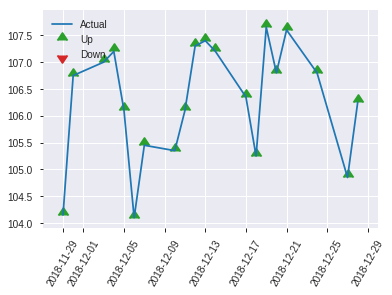


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2528963413445259
RMSE: 0.5028880007959285
LogLoss: 0.698787021819569
Mean Per-Class Error: 0.47023809523809523
AUC: 0.5337725999490706
pr_auc: 0.6529708064842497
Gini: 0.06754519989814112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5463136765346639: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    112  0.9412   (112.0/119.0)
1      2    130  0.0152   (2.0/132.0)
Total  9    242  0.4542   (114.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.546314     0.695187  30
max f2                       0.453492     0.84724   39
max f0point5                 0.594614     0.591346  15
max accuracy                 0.600278     0.549801  11
max precision                0.844458     1         0
max recall                   0.453492     1         39
max specificity              0.844458     1         0
max absolute_mcc             0.546314     0.117283  30
max min_per_class_accuracy   0.607124     0.159664  5
max mean_per_class_accuracy  0.600278     0.529762  11

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 60.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.658701           1.26768   1.26768            0.666667         0.773124  0.666667                    0.773124            0.0151515       0.0151515                  26.7677   26.7677
    2        0.864542                    0.607124           1.02184   1.02524            0.537383         0.607304  0.539171                    0.609596            0.871212        0.886364                   2.18423   2.52409
    3        0.900398                    0.59727            1.0564    1.02648            0.555556         0.601417  0.539823                    0.609271            0.0378788       0.924242                   5.63973   2.64816
    4        1                           0.453492           0.760606  1                  0.4              0.547273  0.525896                    0.603096            0.0757576       1                          -23.9394  0

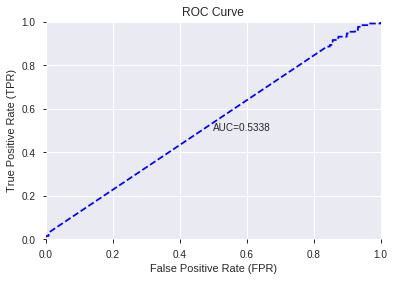

This function is available for GLM models only


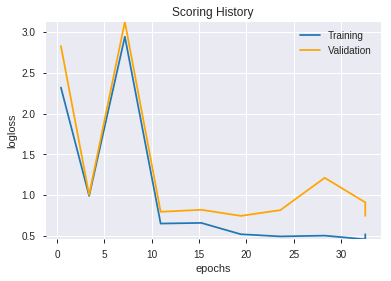

--2019-08-27 14:41:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_142311_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_142311_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLLONGLEGGEDDOJI',
 'BOP',
 'OBV',
 'CDLDOJI',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'TRANGE',
 'CDLRICKSHAWMAN',
 'HT_PHASOR_inphase',
 'CDLHIGHWAVE',
 'CDLTHRUSTING',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'CORREL_24',
 'CORREL_12',
 'CDLLONGLINE',
 'CORREL_14',
 'CDLINVERTEDHAMMER',
 'HT_PHASOR_quadrature',
 'STDDEV_14',
 'CDL3INSIDE',
 'CORREL_8',
 'MFI_20',
 'STOCH_slowd',
 'CORREL_30',
 'CDLHAMMER',
 'MFI_12',
 'VAR_24',
 'aroondown_8',
 'CDLHANGINGMAN',
 'AROONOSC_20',
 'aroondown_14',
 'BETA_30',
 'aroonup_12',
 'BETA_24',
 'aroonup_14',
 'STOCH_slowk',
 'aroondown_30',
 'CDLSHORTLINE',
 'STOCHF_fastd',
 'CDLHOMINGPIGEON',
 'ADOSC',
 'BETA_20',
 'ADX_8',
 'aroondown_12',
 'MACDEXT_hist',
 'aroonup_30',
 'CDLONNECK',
 'VAR_12',
 'CDL3OUTSIDE',
 'ADXR_8',
 'PLUS_DM_20',
 'CDLTAKURI',
 'VAR_14',
 'CDLHARAMICROSS',
 'BETA_8',
 'CDLSTALLEDPATTERN',
 'MACDEXT',
 'CDLTASUKIGAP',
 'ROCP_14',
 'MFI_30',
 'STOCHF_fastk',
 'LINEARREG_INTERCEPT_24',
 'WILLR_8',
 'CDLSTICKSANDWICH',
 'MFI_2

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_144128_model_1  0.506048  0.694304                   0.5  0.500574  0.250574

variable  relative_importance  scaled_importance    percentage
0           CDLGRAVESTONEDOJI         8.366856e-03           1.000000  1.660034e-02
1                         BOP         7.478081e-03           0.893774  1.483696e-02
2                   CORREL_12         6.312532e-03           0.754469  1.252444e-02
3                CDLENGULFING         6.286557e-03           0.751364  1.247291e-02
4                 CDLBELTHOLD         5.470226e-03           0.653797  1.085326e-02
..                        ...                  ...                ...           ...
605   BBANDS_upperband_14_2_2         1.659046e-06           0.000198  3.291647e-06
606  BBANDS_middleband_30_7_3         1.281562e-06           0.000153  2.542696e-06
607  BBANDS_middleband_12_5_5         3.367240e-07           0.000040  6.680805e-07
608  BBANDS_middleband_14_0_3         3.037683e-07           0.000036  6.026944e-07
609   BBANDS_upperband_30_2_4         2.793314e-08           0.000003  5.542101e-08

[610 rows x 4 columns]

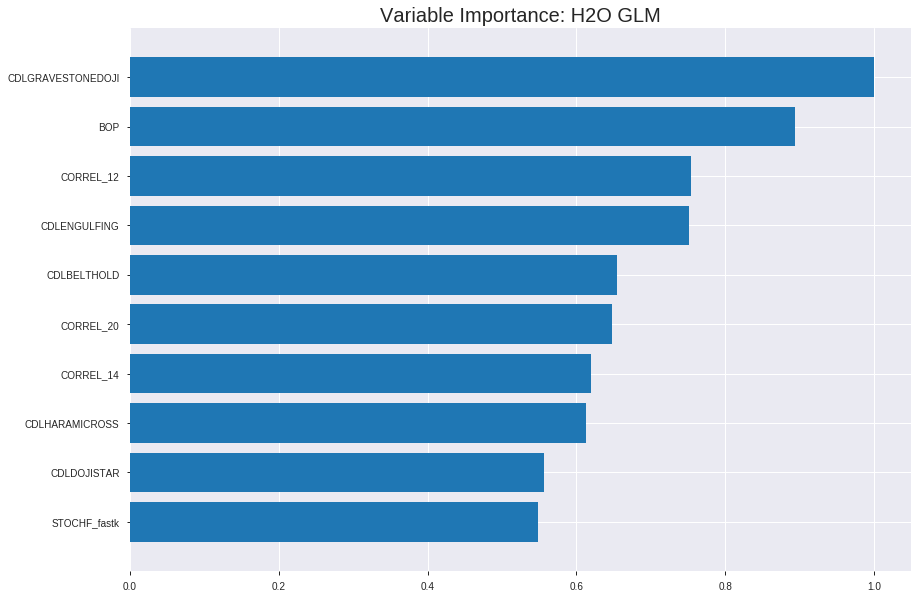

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_144128_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2464108219379666
RMSE: 0.4963978464276075
LogLoss: 0.6859256531399484
Null degrees of freedom: 1752
Residual degrees of freedom: 1142
Null deviance: 2426.6126264514623
Residual deviance: 2404.8553399086595
AIC: 3626.8553399086595
AUC: 0.5762340027025193
pr_auc: 0.6031507850953681
Gini: 0.1524680054050387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44588327403468375: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   827   0.9881   (827.0/837.0)
1      3    913   0.0033   (3.0/916.0)
Total  13   1740  0.4735   (830.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445883     0.6875    389
max f2                       0.436359     0.846111  395
max f0point5                 0.509012     0.585476  248
max accuracy                 0.533209     0.557901  153
max precision                0.595875     0.888889  6
max recall                   0.436359     1         395
max specificity              0.604553     0.998805  0
max absolute_mcc             0.536794     0.140182  139
max min_per_class_accuracy   0.523601     0.549127  192
max mean_per_class_accuracy  0.536794     0.565209  139

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.590273           1.5948    1.5948             0.833333         0.596692  0.833333                    0.596692            0.0163755       0.0163755                  59.4796   59.4796
    2        0.0205362                   0.581921           1.27584   1.43532            0.666667         0.585666  0.75                        0.591179            0.0131004       0.029476                   27.5837   43.5317
    3        0.0302339                   0.577124           1.46346   1.44434            0.764706         0.579559  0.754717                    0.587452            0.0141921       0.0436681                  46.346    44.4344
    4        0.040502                    0.57469            1.38216   1.42858            0.722222         0.57599   0.746479                    0.584546            0.0141921       0.0578603                  38.2157   42.8578
    5        0.0501997                   0.569238           1.12574   1.37007            0.588235         0.571479  0.715909                    0.582022            0.010917        0.0687773                  12.5739   37.0075
    6        0.100399                    0.558506           1.23959   1.30483            0.647727         0.563715  0.681818                    0.572869            0.0622271       0.131004                   23.9592   30.4833
    7        0.150029                    0.551825           1.09986   1.23703            0.574713         0.555024  0.646388                    0.566966            0.0545852       0.18559                    9.98595   23.7028
    8        0.200228                    0.54745            1.13086   1.21041            0.590909         0.550015  0.632479                    0.562716            0.0567686       0.242358                   13.0855   21.0409
    9        0.300057                    0.53801            1.14825   1.18973            0.6              0.542543  0.621673                    0.556004            0.114629        0.356987                   14.8253   18.973
    10       0.399886                    0.530777           1.00609   1.14389            0.525714         0.534223  0.597718                    0.550567            0.100437        0.457424                   0.608858  14.3885
    11       0.500285                    0.523425           0.913383  1.09763            0.477273         0.52703   0.573546                    0.545843            0.0917031       0.549127                   -8.66167  9.76271
    12       0.600114                    0.515444           0.95141   1.0733             0.497143         0.51931   0.560837                    0.54143             0.0949782       0.644105                   -4.85901  7.33039
    13       0.699943                    0.508236           0.962346  1.05748            0.502857         0.512094  0.552567                    0.537246            0.0960699       0.740175                   -3.76544  5.74786
    14       0.799772                    0.49875            0.820181  1.02786            0.428571         0.503584  0.53709                     0.533044            0.0818777       0.822052                   -17.9819  2.78587
    15       0.899601                    0.484219           0.918603  1.01573            0.48             0.492834  0.530755                    0.528582            0.0917031       0.913755                   -8.13974  1.57345
    16       1                           0.432151           0.859015  1                  0.448864         0.468332  0.522533                    0.522533          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.249162242985195
RMSE: 0.49916153996997303
LogLoss: 0.6914677292608133
Null degrees of freedom: 500
Residual degrees of freedom: -110
Null deviance: 693.1168027311257
Residual deviance: 692.850664719335
AIC: 1914.8506647193349
AUC: 0.5336993351233857
pr_auc: 0.5637655722277213
Gini: 0.06739867024677149
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4398447070052169: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    234  0.9873   (234.0/237.0)
1      0    264  0        (0.0/264.0)
Total  3    498  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439845     0.692913  396
max f2                       0.439845     0.849421  396
max f0point5                 0.458045     0.587963  375
max accuracy                 0.500733     0.540918  195
max precision                0.545243     0.8125    13
max recall                   0.439845     1         396
max specificity              0.566497     0.995781  0
max absolute_mcc             0.544165     0.104397  16
max min_per_class_accuracy   0.500233     0.534091  198
max mean_per_class_accuracy  0.500733     0.541739  195

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 49.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.549594           0.948864  0.948864           0.5              0.556498  0.5                         0.556498            0.0113636       0.0113636                  -5.11364  -5.11364
    2        0.0219561                   0.548392           1.89773   1.38017            1                0.549072  0.727273                    0.553123            0.0189394       0.030303                   89.7727   38.0165
    3        0.0319361                   0.545243           1.89773   1.5419             1                0.546326  0.8125                      0.550999            0.0189394       0.0492424                  89.7727   54.1903
    4        0.0419162                   0.543137           0.759091  1.35552            0.4              0.544028  0.714286                    0.549339            0.00757576      0.0568182                  -24.0909  35.5519
    5        0.0518962                   0.541188           1.13864   1.31381            0.6              0.542099  0.692308                    0.547947            0.0113636       0.0681818                  13.8636   31.3811
    6        0.101796                    0.531814           0.759091  1.04189            0.4              0.536075  0.54902                     0.542127            0.0378788       0.106061                   -24.0909  4.18895
    7        0.151697                    0.526123           1.29045   1.12365            0.68             0.528235  0.592105                    0.537558            0.0643939       0.170455                   29.0455   12.3654
    8        0.201597                    0.521835           1.21455   1.14615            0.64             0.524022  0.60396                     0.534207            0.0606061       0.231061                   21.4545   14.6152
    9        0.301397                    0.514496           0.986818  1.09339            0.52             0.517668  0.576159                    0.528731            0.0984848       0.329545                   -1.31818  9.33925
    10       0.401198                    0.507813           0.872955  1.03856            0.46             0.511239  0.547264                    0.524379            0.0871212       0.416667                   -12.7045  3.85572
    11       0.500998                    0.499596           1.17659   1.06605            0.62             0.503336  0.561753                    0.520188            0.117424        0.534091                   17.6591   6.6054
    12       0.600798                    0.49386            0.948864  1.04659            0.5              0.496362  0.551495                    0.51623             0.094697        0.628788                   -5.11364  4.65871
    13       0.700599                    0.487011           0.683182  0.99482            0.36             0.490575  0.524217                    0.512575            0.0681818       0.69697                    -31.6818  -0.518001
    14       0.800399                    0.476877           0.910909  0.984357           0.48             0.481753  0.518703                    0.508732            0.0909091       0.787879                   -8.90909  -1.56427
    15       0.9002                      0.465672           1.17659   1.00567            0.62             0.471259  0.529933                    0.504578            0.117424        0.905303                   17.6591   0.566922
    16       1                           0.437407           0.948864  1                  0.5              0.456155  0.526946                    0.499745     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:41:29  0.000 sec   2            3.9       611           1.37185           1.38294
    2019-08-27 14:41:30  0.688 sec   4            2.8       611           1.36921           1.38333
    2019-08-27 14:41:30  1.358 sec   6            2.1       611           1.36607           1.38396
    2019-08-27 14:41:31  2.006 sec   8            1.5       611           1.36236           1.38499
    2019-08-27 14:41:32  2.698 sec   10           1.1       611           1.35811           1.38649
    2019-08-27 14:41:32  3.353 sec   12           0.79      611           1.35332           1.38853

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6892950391644909)

('auc', 0.5060478736949325)

('logloss', 0.6943038224852509)

('mean_per_class_error', 0.46584542908072313)

('rmse', 0.5005741183911948)

('mse', 0.2505744480031219)

glm prediction progress: |████████████████████████████████████████████████| 100%


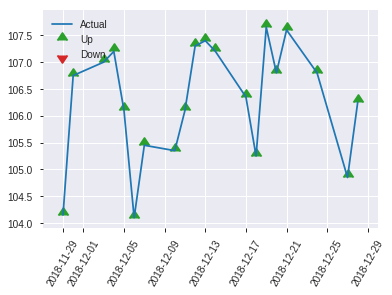


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2505744480031219
RMSE: 0.5005741183911948
LogLoss: 0.6943038224852509
Null degrees of freedom: 250
Residual degrees of freedom: -360
Null deviance: 347.29766117999407
Residual deviance: 348.54051888759597
AIC: 1570.540518887596
AUC: 0.5060478736949325
pr_auc: 0.5515554716077993
Gini: 0.012095747389865075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4397453829046668: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    132  0        (0.0/132.0)
Total  0    251  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439745     0.689295  250
max f2                       0.439745     0.84724   250
max f0point5                 0.439745     0.580986  250
max accuracy                 0.483248     0.537849  181
max precision                0.533754     0.833333  5
max recall                   0.439745     1         250
max specificity              0.549961     0.991597  0
max absolute_mcc             0.455242     0.148586  244
max min_per_class_accuracy   0.496353     0.492424  123
max mean_per_class_accuracy  0.521373     0.534155  27

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 49.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.539246           1.26768   1.26768            0.666667         0.543771  0.666667                    0.543771            0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.533754           1.90152   1.5846             1                0.535699  0.833333                    0.539735            0.0227273       0.0378788                  90.1515   58.4596
    3        0.0318725                   0.531381           0.950758  1.42614            0.5              0.531886  0.75                        0.537773            0.00757576      0.0454545                  -4.92424  42.6136
    4        0.0438247                   0.529703           1.26768   1.38292            0.666667         0.530629  0.727273                    0.535825            0.0151515       0.0606061                  26.7677   38.292
    5        0.0517928                   0.527333           0.950758  1.31643            0.5              0.528655  0.692308                    0.534722            0.00757576      0.0681818                  -4.92424  31.6434
    6        0.103586                    0.521554           1.17016   1.2433             0.615385         0.524256  0.653846                    0.529489            0.0606061       0.128788                   17.0163   24.3298
    7        0.151394                    0.518304           0.792298  1.10088            0.416667         0.520112  0.578947                    0.526528            0.0378788       0.166667                   -20.7702  10.0877
    8        0.203187                    0.515795           1.02389   1.08125            0.538462         0.517146  0.568627                    0.524136            0.0530303       0.219697                   2.38928   8.12537
    9        0.302789                    0.510819           0.836667  1.0008             0.44             0.512809  0.526316                    0.52041             0.0833333       0.30303                    -16.3333  0.0797448
    10       0.40239                     0.502034           1.06485   1.01665            0.56             0.506392  0.534653                    0.51694             0.106061        0.409091                   6.48485   1.66517
    11       0.501992                    0.496217           0.836667  0.98094            0.44             0.49903   0.515873                    0.513387            0.0833333       0.492424                   -16.3333  -1.90596
    12       0.601594                    0.491408           0.988788  0.98224            0.52             0.49364   0.516556                    0.510117            0.0984848       0.590909                   -1.12121  -1.77604
    13       0.701195                    0.484935           1.21697   1.01558            0.64             0.487618  0.534091                    0.506921            0.121212        0.712121                   21.697    1.5582
    14       0.800797                    0.479783           0.988788  1.01225            0.52             0.482112  0.532338                    0.503836            0.0984848       0.810606                   -1.12121  1.22494
    15       0.900398                    0.471301           0.912727  1.00124            0.48             0.476452  0.526549                    0.500806            0.0909091       0.901515                   -8.72727  0.124028
    16       1                           0.439745           0.988788  1                  0.52             0.45874   0.525896                    0.496617      

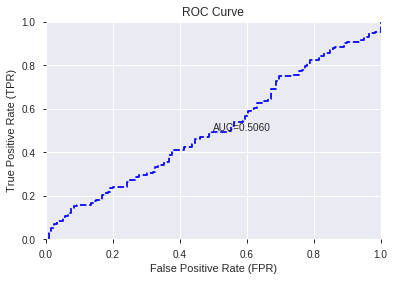

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


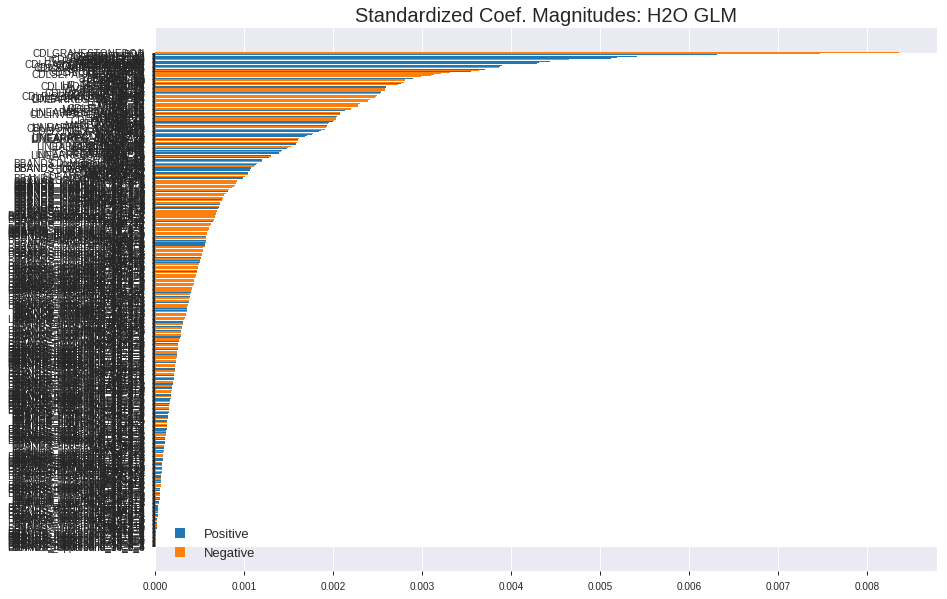

'log_likelihood'
--2019-08-27 14:41:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_144128_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_144128_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLGRAVESTONEDOJI',
 'BOP',
 'CORREL_12',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'CORREL_20',
 'CORREL_14',
 'CDLHARAMICROSS',
 'CDLDOJISTAR',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'CORREL_24',
 'CDLHAMMER',
 'CDLGAPSIDESIDEWHITE',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'CDLBREAKAWAY',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'OBV',
 'PLUS_DI_30',
 'CORREL_8',
 'CDLONNECK',
 'CDLRICKSHAWMAN',
 'WILLR_8',
 'PLUS_DI_24',
 'CDLSEPARATINGLINES',
 'aroonup_30',
 'MFI_14',
 'PLUS_DI_20',
 'aroondown_14',
 'DX_20',
 'CORREL_30',
 'ROC_30',
 'ROCP_30',
 'CDL3INSIDE',
 'ROCR_30',
 'ROCR100_30',
 'HT_TRENDMODE',
 'DX_24',
 'CCI_8',
 'CDLLADDERBOTTOM',
 'aroondown_30',
 'MACDFIX_hist_24',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'DX_14',
 'CDLHOMINGPIGEON',
 'DX_30',
 'CDLTHRUSTING',
 'MACDFIX_hist_20',
 'CDLRISEFALL3METHODS',
 'PLUS_DI_14',
 'CDLEVENINGDOJISTAR',
 'LINEARREG_SLOPE_24',
 'WILLR_20',
 'CMO_30',
 'RSI_30',
 'MFI_12',
 'WILLR_30',
 'WILLR_12',
 'PLUS_DI_12',
 'RSI_24',
 

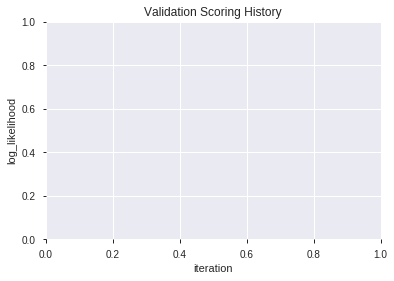

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_144153_model_1  0.604724  0.678563              0.468933  0.492681  0.242735
1               XGBoost_3_AutoML_20190827_144153  0.573720  0.688480              0.456328  0.497374  0.247381
2  XGBoost_grid_1_AutoML_20190827_144153_model_3  0.563725  0.689854              0.500000  0.498188  0.248192
3  XGBoost_grid_1_AutoML_20190827_144153_model_4  0.556086  0.687340              0.491597  0.497091  0.247099
4               XGBoost_2_AutoML_20190827_144153  0.547110  0.697430              0.459702  0.501429  0.251431
5  XGBoost_grid_1_AutoML_20190827_144153_model_5  0.542526  0.708235              0.443309  0.505693  0.255726
6  XGBoost_grid_1_AutoML_20190827_144153_model_2  0.528266  0.695938              0.495385  0.501290  0.251292
7  XGBoost_grid_1_AutoML_20190827_144153_model_7  0.525337  0.703541              0.500000  0.504843  0.254866
8               XGBoost_1_AutoML_20190827_144153  0.505220  0.704139              0.486981  0.504843  0.254866
9  XGBoost_grid_1_AutoML_20190827_144153_model_6  0.492870  0.705742              0.495798  0.506089  0.256127

variable  relative_importance  scaled_importance  percentage
0                        BOP           164.765640           1.000000    0.033592
1                      MOM_8           124.330215           0.754588    0.025348
2                     TRANGE           117.965683           0.715960    0.024051
3             STOCHRSI_fastd           111.122124           0.674425    0.022655
4                  CORREL_20            88.798439           0.538938    0.018104
..                       ...                  ...                ...         ...
215  BBANDS_upperband_24_5_5             2.590345           0.015721    0.000528
216  BBANDS_lowerband_20_3_3             2.074900           0.012593    0.000423
217  BBANDS_lowerband_12_3_5             1.851776           0.011239    0.000378
218       LINEARREG_ANGLE_30             1.642353           0.009968    0.000335
219                    DX_12             0.989330           0.006004    0.000202

[220 rows x 4 columns]

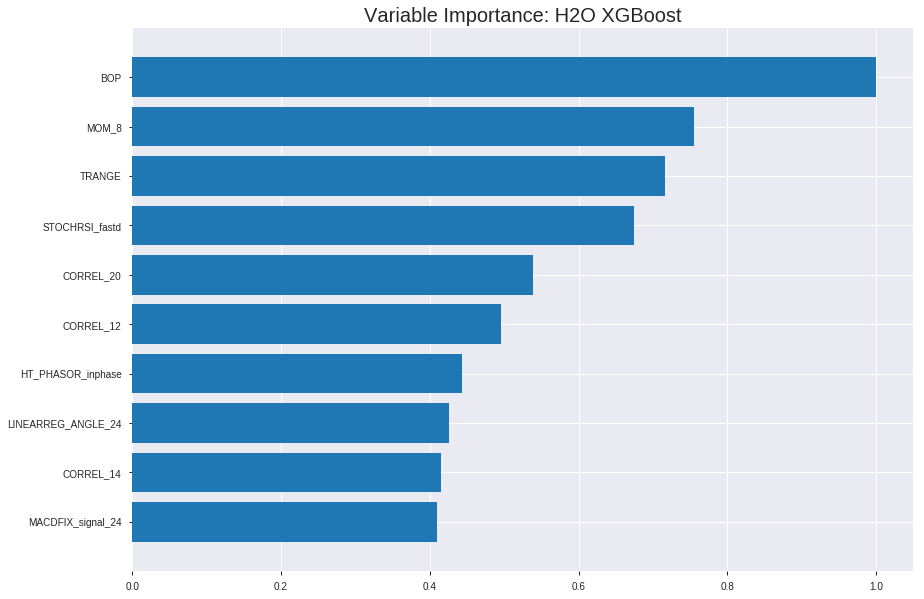

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_144153_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1833185142918944
RMSE: 0.42815711402695905
LogLoss: 0.5559317253863613
Mean Per-Class Error: 0.1305224262154816
AUC: 0.9383063863976668
pr_auc: 0.9448884645079225
Gini: 0.8766127727953337
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49882718175649643: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      704  133  0.1589   (133.0/837.0)
1      102  814  0.1114   (102.0/916.0)
Total  806  947  0.1341   (235.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498827     0.873859  222
max f2                       0.46206      0.903937  263
max f0point5                 0.544155     0.895765  176
max accuracy                 0.513803     0.868226  207
max precision                0.790925     1         0
max recall                   0.354801     1         364
max specificity              0.790925     1         0
max absolute_mcc             0.513803     0.738387  207
max min_per_class_accuracy   0.505559     0.863537  215
max mean_per_class_accuracy  0.513803     0.869478  207

Gains/Lift Table: Avg response rate: 52.25 %, avg score: 52.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.750615           1.91376    1.91376            1                0.767315  1                           0.767315            0.0196507       0.0196507                  91.3755   91.3755
    2        0.0205362                   0.736624           1.80744    1.8606             0.944444         0.743301  0.972222                    0.755308            0.018559        0.0382096                  80.7436   86.0596
    3        0.0302339                   0.724121           1.91376    1.87765            1                0.730009  0.981132                    0.747193            0.018559        0.0567686                  91.3755   87.7647
    4        0.040502                    0.71527            1.91376    1.8868             1                0.719563  0.985915                    0.740188            0.0196507       0.0764192                  91.3755   88.6801
    5        0.0501997                   0.706514           1.91376    1.89201            1                0.710568  0.988636                    0.734466            0.018559        0.0949782                  91.3755   89.2008
    6        0.100399                    0.671489           1.91376    1.90288            1                0.685547  0.994318                    0.710006            0.0960699       0.191048                   91.3755   90.2882
    7        0.150029                    0.641963           1.89176    1.8992             0.988506         0.658135  0.992395                    0.692847            0.0938865       0.284934                   89.1758   89.9202
    8        0.200228                    0.620144           1.87026    1.89195            0.977273         0.629566  0.988604                    0.676982            0.0938865       0.378821                   87.0261   89.1946
    9        0.300057                    0.578225           1.85908    1.88101            0.971429         0.599661  0.98289                     0.651257            0.18559         0.56441                    85.9077   88.1011
    10       0.399886                    0.542801           1.60755    1.81274            0.84             0.560445  0.947218                    0.628587            0.16048         0.724891                   60.7555   81.2744
    11       0.500285                    0.509858           1.23959    1.69772            0.647727         0.525858  0.887115                    0.607971            0.124454        0.849345                   23.9592   69.7721
    12       0.600114                    0.481103           0.710823   1.53355            0.371429         0.495002  0.801331                    0.589178            0.0709607       0.920306                   -28.9177  53.3551
    13       0.699943                    0.454866           0.426494   1.37566            0.222857         0.468497  0.718826                    0.571966            0.0425764       0.962882                   -57.3506  37.5658
    14       0.799772                    0.427774           0.262458   1.23671            0.137143         0.442081  0.64622                     0.555754            0.0262009       0.989083                   -73.7542  23.6706
    15       0.899601                    0.387923           0.0984217  1.11039            0.0514286        0.40851   0.580216                    0.539414            0.00982533      0.998908                   -90.1578  11.0391
    16       1                           0.196613           0.0108736  1                  0.00568182       0.352644  0.522533                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25462672135078956
RMSE: 0.5046055106226938
LogLoss: 0.7029337847930583
Mean Per-Class Error: 0.46785097813578824
AUC: 0.5127221582917786
pr_auc: 0.5196648697034951
Gini: 0.02544431658355717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3268386721611023: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    235  0.9916   (235.0/237.0)
1      1    263  0.0038   (1.0/264.0)
Total  3    498  0.4711   (236.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.326839     0.690289   396
max f2                       0.299304     0.847784   399
max f0point5                 0.423747     0.5875     341
max accuracy                 0.423747     0.54491    341
max precision                0.816965     1          0
max recall                   0.299304     1          399
max specificity              0.816965     1          0
max absolute_mcc             0.577575     0.0772239  83
max min_per_class_accuracy   0.514951     0.515152   200
max mean_per_class_accuracy  0.530917     0.532149   168

Gains/Lift Table: Avg response rate: 52.69 %, avg score: 51.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.687253           0.632576  0.632576           0.333333         0.723866  0.333333                    0.723866            0.00757576      0.00757576                 -36.7424  -36.7424
    2        0.0219561                   0.672832           0.759091  0.690083           0.4              0.680053  0.363636                    0.703951            0.00757576      0.0151515                  -24.0909  -30.9917
    3        0.0319361                   0.661385           1.51818   0.948864           0.8              0.664977  0.5                         0.691771            0.0151515       0.030303                   51.8182   -5.11364
    4        0.0419162                   0.6537             1.13864   0.994048           0.6              0.656159  0.52381                     0.683292            0.0113636       0.0416667                  13.8636   -0.595238
    5        0.0518962                   0.640853           0.759091  0.948864           0.4              0.644417  0.5                         0.675816            0.00757576      0.0492424                  -24.0909  -5.11364
    6        0.101796                    0.611624           0.759091  0.855838           0.4              0.625559  0.45098                     0.65118             0.0378788       0.0871212                  -24.0909  -14.4162
    7        0.151697                    0.585622           0.910909  0.873953           0.48             0.59705   0.460526                    0.633374            0.0454545       0.132576                   -8.90909  -12.6047
    8        0.201597                    0.572279           1.06273   0.92068            0.56             0.578821  0.485149                    0.619871            0.0530303       0.185606                   6.27273   -7.93204
    9        0.301397                    0.55062            1.21455   1.01799            0.64             0.561635  0.536424                    0.600588            0.121212        0.306818                   21.4545   1.79862
    10       0.401198                    0.531307           1.21455   1.06688            0.64             0.540777  0.562189                    0.585709            0.121212        0.42803                    21.4545   6.68815
    11       0.500998                    0.514666           0.910909  1.03581            0.48             0.523229  0.545817                    0.573263            0.0909091       0.518939                   -8.90909  3.58113
    12       0.600798                    0.495947           0.948864  1.02137            0.5              0.504992  0.538206                    0.561922            0.094697        0.613636                   -5.11364  2.13682
    13       0.700599                    0.471058           1.06273   1.02726            0.56             0.48388   0.541311                    0.550805            0.106061        0.719697                   6.27273   2.72598
    14       0.800399                    0.450657           0.872955  1.00802            0.46             0.460937  0.531172                    0.5396              0.0871212       0.806818                   -12.7045  0.801972
    15       0.9002                      0.409358           0.986818  1.00567            0.52             0.430836  0.529933                    0.527542            0.0984848       0.905303                   -1.31818  0.566922
    16       1                           0.299304           0.948864  1                  0.5              0.37514   0.526946                    0.5123


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:42:04  0.010 sec   0                  0.5              0.693147            0.5             0                  1                0.477467                         0.5                0.693147              0.5               0                    1                  0.473054
    2019-08-27 14:42:05  0.678 sec   5                  0.487712         0.668806            0.798439        0.822249           1.91376          0.31603                          0.501218           0.695595              0.477169          0.500451             0.948864           0.473054
    2019-08-27 14:42:05  0.840 sec   10                 0.476487         0.646957            0.859637        0.87597            1.91376          0.247576                         0.501416           0.696001              0.486758          0.50507              0.948864           0.471058
    2019-08-27 14:42:05  0.989 sec   15                 0.46687          0.628488            0.881463        0.895007           1.91376          0.213919                         0.500307           0.69376               0.509885          0.527469             0.948864           0.461078
    2019-08-27 14:42:05  1.133 sec   20                 0.461022         0.617313            0.891162        0.903316           1.91376          0.20251                          0.500625           0.694442              0.517549          0.523105             0.632576           0.471058
    2019-08-27 14:42:05  1.278 sec   25                 0.4543           0.604543            0.901762        0.913343           1.91376          0.17684                          0.501797           0.696876              0.51452           0.522076             0.948864           0.473054
    2019-08-27 14:42:05  1.498 sec   30                 0.4489           0.59433             0.907447        0.919152           1.91376          0.185396                         0.502378           0.698111              0.510165          0.518187             0.948864           0.473054
    2019-08-27 14:42:06  1.633 sec   35                 0.442096         0.581649            0.920398        0.930088           1.91376          0.158015                         0.503336           0.700154              0.510237          0.518064             0.632576           0.473054
    2019-08-27 14:42:06  1.759 sec   40                 0.438692         0.575246            0.923383        0.932516           1.91376          0.154022                         0.503886           0.701356              0.512363          0.520272             0.948864           0.473054
    2019-08-27 14:42:06  1.891 sec   45                 0.434438         0.56737             0.928993        0.936867           1.91376          0.144324                         0.503972           0.701578              0.514145          0.519081             0.948864           0.473054
    2019-08-27 14:42:06  2.027 sec   50                 0.428157         0.555932            0.938306        0.944888           1.91376          0.134056                         0.504606           0.702934              0.512722          0.519665             0.632576           0.471058

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      164.76564025878906     1.0                   0.033592078348162045
MOM_8                    124.33021545410156     0.7545882458188635    0.025348187474149426
TRANGE                   117.96568298339844     0.7159604563070049    0.02405059974245076
STOCHRSI_fastd           111.12212371826172     0.6744253446515173    0.02265534901751996
CORREL_20                88.7984390258789       0.5389378446040551    0.018104042300729
---                      ---                    ---                   ---
BBANDS_upperband_24_5_5  2.5903453826904297     0.01572139299566284   0.0005281142652525521
BBANDS_lowerband_20_3_3  2.074899673461914      0.01259303620708161   0.00042302625890952686
BBANDS_lowerband_12_3_5  1.851776123046875      0.011238848828787264  0.000377536290399771
LINEARREG_ANGLE_30       1.6423530578613281     0.009967812799329807  0.0003348395485148993
DX_12                    0.9893302917480469     0.006004469683085356  0.000201702616033367


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.601593625498008)

('F1', 0.6956521739130436)

('auc', 0.6047237076648841)

('logloss', 0.6785627925225699)

('mean_per_class_error', 0.38996052966641204)

('rmse', 0.4926814461627218)

('mse', 0.24273500739299092)

xgboost prediction progress: |████████████████████████████████████████████| 100%


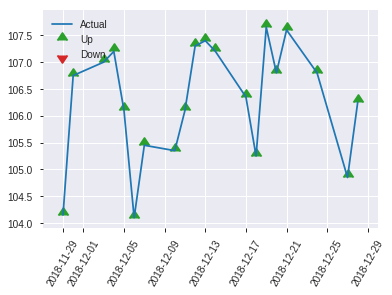


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24273500739299092
RMSE: 0.4926814461627218
LogLoss: 0.6785627925225699
Mean Per-Class Error: 0.38996052966641204
AUC: 0.6047237076648841
pr_auc: 0.6032640254401789
Gini: 0.2094474153297683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4585856795310974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   108  0.9076   (108.0/119.0)
1      4    128  0.0303   (4.0/132.0)
Total  15   236  0.4462   (112.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458586     0.695652  235
max f2                       0.402289     0.849421  248
max f0point5                 0.551533     0.619748  85
max accuracy                 0.551533     0.601594  85
max precision                0.657274     0.714286  6
max recall                   0.402289     1         248
max specificity              0.717284     0.991597  0
max absolute_mcc             0.551533     0.231552  85
max min_per_class_accuracy   0.532454     0.583333  123
max mean_per_class_accuracy  0.551533     0.610039  85

Gains/Lift Table: Avg response rate: 52.59 %, avg score: 53.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.697158           1.26768   1.26768            0.666667         0.707228  0.666667                    0.707228            0.0151515       0.0151515                  26.7677   26.7677
    2        0.0239044                   0.676334           1.26768   1.26768            0.666667         0.685296  0.666667                    0.696262            0.0151515       0.030303                   26.7677   26.7677
    3        0.0318725                   0.645937           0.950758  1.18845            0.5              0.656299  0.625                       0.686271            0.00757576      0.0378788                  -4.92424  18.8447
    4        0.0438247                   0.630157           0.633838  1.03719            0.333333         0.63386   0.545455                    0.671977            0.00757576      0.0454545                  -36.6162  3.71901
    5        0.0517928                   0.625697           0.950758  1.02389            0.5              0.627181  0.538462                    0.665085            0.00757576      0.0530303                  -4.92424  2.38928
    6        0.103586                    0.607507           1.60897   1.31643            0.846154         0.617075  0.692308                    0.64108             0.0833333       0.136364                   60.8974   31.6434
    7        0.151394                    0.592776           0.950758  1.20096            0.5              0.598391  0.631579                    0.627599            0.0454545       0.181818                   -4.92424  20.0957
    8        0.203187                    0.578933           1.4627    1.26768            0.769231         0.584749  0.666667                    0.616677            0.0757576       0.257576                   46.2704   26.7677
    9        0.302789                    0.562233           1.29303   1.27602            0.68             0.570553  0.671053                    0.601505            0.128788        0.386364                   29.303    27.6017
    10       0.40239                     0.541087           1.06485   1.22375            0.56             0.550574  0.643564                    0.588898            0.106061        0.492424                   6.48485   22.3747
    11       0.501992                    0.53098            0.912727  1.16204            0.48             0.537266  0.611111                    0.578654            0.0909091       0.583333                   -8.72727  16.2037
    12       0.601594                    0.516491           0.912727  1.12076            0.48             0.524158  0.589404                    0.569631            0.0909091       0.674242                   -8.72727  12.0761
    13       0.701195                    0.50488            0.684545  1.0588             0.36             0.509625  0.556818                    0.561108            0.0681818       0.742424                   -31.5455  5.87982
    14       0.800797                    0.490042           0.912727  1.04063            0.48             0.498583  0.547264                    0.553331            0.0909091       0.833333                   -8.72727  4.06302
    15       0.900398                    0.472829           0.988788  1.0349             0.52             0.481319  0.544248                    0.545365            0.0984848       0.931818                   -1.12121  3.48954
    16       1                           0.371206           0.684545  1                  0.36             0.441332  0.525896                    0.535003         

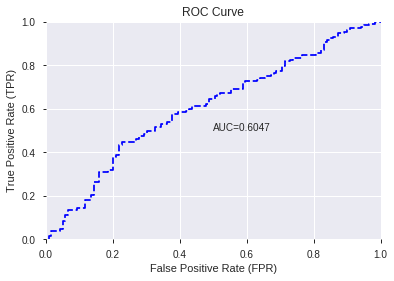

This function is available for GLM models only


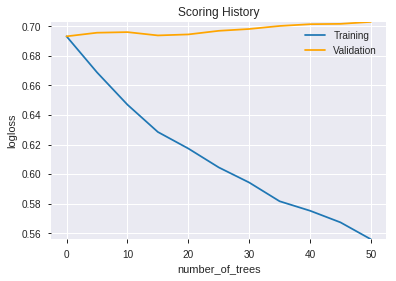

--2019-08-27 14:42:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_144153_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_144153_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b27e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'MOM_8',
 'TRANGE',
 'STOCHRSI_fastd',
 'CORREL_20',
 'CORREL_12',
 'HT_PHASOR_inphase',
 'LINEARREG_ANGLE_24',
 'CORREL_14',
 'MACDFIX_signal_24',
 'WILLR_8',
 'CMO_8',
 'ROC_8',
 'ADOSC',
 'CCI_24',
 'ROC_30',
 'OBV',
 'WILLR_20',
 'ADX_24',
 'MOM_20',
 'DX_14',
 'MA_12_7',
 'ATR_24',
 'DX_8',
 'STDDEV_14',
 'ROC_20',
 'DX_20',
 'MFI_8',
 'BBANDS_lowerband_20_5_4',
 'CORREL_8',
 'STOCHF_fastk',
 'MACDEXT_hist',
 'WILLR_24',
 'PLUS_DI_24',
 'MACDFIX_hist_8',
 'CCI_8',
 'DX_30',
 'ATR_8',
 'MACDFIX_signal_12',
 'PLUS_DM_14',
 'PLUS_DI_12',
 'ADX_8',
 'MACDEXT',
 'CORREL_24',
 'MFI_20',
 'MFI_30',
 'CORREL_30',
 'PPO',
 'MACDFIX_hist_12',
 'CCI_30',
 'STOCHRSI_fastk',
 'MOM_24',
 'ADXR_12',
 'aroondown_30',
 'MACDFIX_hist_14',
 'LINEARREG_SLOPE_12',
 'TRIX_14',
 'MFI_12',
 'CCI_20',
 'PLUS_DM_8',
 'ROC_24',
 'ATR_20',
 'CCI_14',
 'DX_24',
 'ADX_14',
 'ROC_12',
 'BBANDS_lowerband_20_3_5',
 'MACDFIX_signal_8',
 'LINEARREG_ANGLE_8',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_upperband_3

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.582
GLM             0.538
XGBoost         0.610
dtype: float64

DeepLearning    GLM  XGBoost
All          0.566  0.538    0.610
DLF          0.582  0.538    0.578
Fwe          0.526  0.538    0.610
RFE          0.550  0.538    0.602
XGBF         0.526  0.538    0.578





F1


DeepLearning    0.696
GLM             0.689
XGBoost         0.696
dtype: float64

DeepLearning    GLM  XGBoost
All          0.690  0.689    0.693
DLF          0.696  0.689    0.691
Fwe          0.689  0.689    0.693
RFE          0.695  0.689    0.696
XGBF         0.689  0.689    0.691





auc


DeepLearning    0.547
GLM             0.513
XGBoost         0.605
dtype: float64

DeepLearning    GLM  XGBoost
All          0.547  0.513    0.604
DLF          0.526  0.488    0.565
Fwe          0.517  0.513    0.604
RFE          0.534  0.506    0.605
XGBF         0.508  0.488    0.565





logloss


DeepLearning    0.959
GLM             0.698
XGBoost         0.687
dtype: float64

DeepLearning    GLM  XGBoost
All          0.959  0.694    0.683
DLF          0.693  0.698    0.687
Fwe          0.793  0.694    0.683
RFE          0.699  0.694    0.679
XGBF         0.695  0.698    0.687





mean_per_class_error


DeepLearning    0.483
GLM             0.474
XGBoost         0.426
dtype: float64

DeepLearning    GLM  XGBoost
All          0.437  0.451    0.389
DLF          0.431  0.474    0.426
Fwe          0.483  0.451    0.389
RFE          0.470  0.466    0.390
XGBF         0.472  0.474    0.426





rmse


DeepLearning    0.596
GLM             0.503
XGBoost         0.497
dtype: float64

DeepLearning    GLM  XGBoost
All          0.596  0.501    0.495
DLF          0.500  0.503    0.497
Fwe          0.544  0.501    0.495
RFE          0.503  0.501    0.493
XGBF         0.501  0.503    0.497





mse


DeepLearning    0.355
GLM             0.253
XGBoost         0.247
dtype: float64

DeepLearning    GLM  XGBoost
All          0.355  0.251    0.245
DLF          0.250  0.253    0.247
Fwe          0.296  0.251    0.245
RFE          0.253  0.251    0.243
XGBF         0.251  0.253    0.247

{'F1':       DeepLearning    GLM  XGBoost
 All          0.690    NaN      NaN
 DLF          0.696    NaN      NaN
 DLF            NaN  0.689      NaN
 DLF            NaN    NaN    0.691
 All            NaN  0.689      NaN
 All            NaN    NaN    0.693
 XGBF         0.689    NaN      NaN
 XGBF           NaN  0.689      NaN
 XGBF           NaN    NaN    0.691
 Fwe          0.689    NaN      NaN
 Fwe            NaN  0.689      NaN
 Fwe            NaN    NaN    0.693
 RFE          0.695    NaN      NaN
 RFE            NaN  0.689      NaN
 RFE            NaN    NaN    0.696,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.566    NaN      NaN
 DLF          0.582    NaN      NaN
 DLF            NaN  0.538      NaN
 DLF            NaN    NaN    0.578
 All            NaN  0.538      NaN
 All            NaN    NaN    0.610
 XGBF         0.526    NaN      NaN
 XGBF           NaN  0.538      NaN
 XGBF           NaN    NaN    0.578
 Fwe          0.526    NaN      NaN
 Fwe     